# NLP and Sentiment Analysis based Trading Strategy

# Problem Statement

The problem statement is to build a trading strategy that uses NLP to extracts the information inside the news headlines, assigns a sentiment to that and use the sentiments and the information inside the news headlines for a trading strategy.

# Getting Started- Loading the data and python packages


## Loading the python packages

As a first step we check if the additional packages needed are present, if not install them. 

In [1]:
import pkg_resources
import pip
installedPackages = {pkg.key for pkg in pkg_resources.working_set}
required = {'nlp', 'yfinance', 'nltk', 'spacy', 'textblob', 'backtrader'}
missing = required - installedPackages
if missing:
    !pip install nlp
    !pip install yfinance
    !pip install nltk==3.4
    !pip install textblob==0.15.3
    !pip install -U SpaCy==2.2.0
    !python -m spacy download en_core_web_lg
    !pip install backtrader==1.9.74.123    

/Users/lakshmi/opt/anaconda3/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Loading libraries

In [2]:
#NLP libraries
from textblob import TextBlob
import spacy
import nltk
import warnings
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
import csv
import pandas as pd

############################################################################
# IMPORTANT 
# Run the command 
# python -m spacy download en_core_web_sm to download this
# https://spacy.io/models
############################################################################

# import en_core_web_lg
# nlp = en_core_web_lg.load()

#Libraries for processing the news headlines
from lxml import etree
import json
from os import listdir
from os.path import isfile, join
from pandas.tseries.offsets import BDay
from scipy.stats.mstats import winsorize
from copy import copy

# Libraries for Classification for modeling the sentiments
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import tensorflow as tf
import textblob

# Keras package for the deep learning model for the sentiment prediction. 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM, Dropout, Activation, Embedding
#from tensorflow.keras.layers.embeddings import Embedding

# Load libraries
import statsmodels.api as sm
import seaborn as sns
import pandas as pd
import numpy as np
import datetime
from datetime import date
import matplotlib.pyplot as plt

#Additional Libraries 
import os.path
import sys


2023-03-22 14:28:53.568727: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/lakshmi/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [3]:
# Disable the warnings
import warnings
warnings.filterwarnings('ignore')

## Loading the stock price data

The stock price data is loaded in this step from Yahoo Finance in this step. The loaded data is saved in csv for further use.

In [4]:
import pandas as pd
import yfinance as yf

tickers = ['AAPL','MSFT','AMZN','GOOG','BA','WMT','JPM','TSLA','NFLX','ADBE']
start = '2010-01-01'
end = '2018-12-31'

if 1==1:
    df_ticker_return = pd.DataFrame()
    for ticker in tickers:    
        ticker_yf = yf.Ticker(ticker)
        if df_ticker_return.empty:
            df_ticker_return = ticker_yf.history(start = start, end = end)
            df_ticker_return['ticker']= ticker 
        else:
            data_temp = ticker_yf.history(start = start, end = end)
            data_temp['ticker']= ticker 
            df_ticker_return = df_ticker_return.append(data_temp)
    df_ticker_return.to_csv(r'Data\Step2.2_ReturnData.csv')
else:
    df_ticker_return = pd.read_csv(r'Data\Step2.2_ReturnData.csv')

The details of the data

In [5]:
df_ticker_return.head(20)

Open      High       Low     Close      Volume  \
Date                                                                            
2010-01-04 00:00:00-05:00  6.487648  6.520173  6.455731  6.505279   493729600   
2010-01-05 00:00:00-05:00  6.523214  6.553307  6.482177  6.516526   601904800   
2010-01-06 00:00:00-05:00  6.516526  6.542364  6.406185  6.412872   552160000   
2010-01-07 00:00:00-05:00  6.436583  6.444182  6.354510  6.401018   477131200   
2010-01-08 00:00:00-05:00  6.392506  6.444181  6.354814  6.443573   447610800   
2010-01-11 00:00:00-05:00  6.468500  6.474579  6.336273  6.386732   462229600   
2010-01-12 00:00:00-05:00  6.358766  6.376397  6.274567  6.314083   594459600   
2010-01-13 00:00:00-05:00  6.318642  6.411657  6.204045  6.403145   605892000   
2010-01-14 00:00:00-05:00  6.386733  6.397372  6.353600  6.366063   432894000   
2010-01-15 00:00:00-05:00  6.411657  6.432023  6.257848  6.259672   594067600   
2010-01-19 00:00:00-05:00  6.332624  6.541148  6.299492  6.536588   730007600   
2010-01-20 00:00:00-05:00  6.532636  6.552090  6.368188  6.435974   612152800   
2010-01-21 00:00:00-05:00  6.446614  6.484002  6.298580  6.324721   608154400   
2010-01-22 00:00:00-05:00  6.285509  6.307395  5.993090  6.011024   881767600   
2010-01-25 00:00:00-05:00  6.155714  6.222283  6.085193  6.172737  1065699600   
2010-01-26 00:00:00-05:00  6.260278  6.496160  6.157840  6.259974  1867110000   
2010-01-27 00:00:00-05:00  6.287638  6.401018  6.065131  6.318947  1722568400   
2010-01-28 00:00:00-05:00  6.229274  6.246600  6.039900  6.057834  1173502400   
2010-01-29 00:00:00-05:00  6.112247  6.146291  5.783046  5.838065  1245952400   
2010-02-01 00:00:00-05:00  5.847487  5.957828  5.814962  5.919224   749876400   

                           Dividends  Stock Splits ticker  
Date                                                       
2010-01-04 00:00:00-05:00        0.0           0.0   AAPL  
2010-01-05 00:00:00-05:00        0.0           0.0   AAPL  
2010-01-06 00:00:00-05:00        0.0           0.0   AAPL  
2010-01-07 00:00:00-05:00        0.0           0.0   AAPL  
2010-01-08 00:00:00-05:00        0.0           0.0   AAPL  
2010-01-11 00:00:00-05:00        0.0           0.0   AAPL  
2010-01-12 00:00:00-05:00        0.0           0.0   AAPL  
2010-01-13 00:00:00-05:00        0.0           0.0   AAPL  
2010-01-14 00:00:00-05:00        0.0           0.0   AAPL  
2010-01-15 00:00:00-05:00        0.0           0.0   AAPL  
2010-01-19 00:00:00-05:00        0.0           0.0   AAPL  
2010-01-20 00:00:00-05:00        0.0           0.0   AAPL  
2010-01-21 00:00:00-05:00        0.0           0.0   AAPL  
2010-01-22 00:00:00-05:00        0.0           0.0   AAPL  
2010-01-25 00:00:00-05:00        0.0           0.0   AAPL  
2010-01-26 00:00:00-05:00        0.0           0.0   AAPL  
2010-01-27 00:00:00-05:00        0.0           0.0   AAPL  
2010-01-28 00:00:00-05:00        0.0           0.0   AAPL  
2010-01-29 00:00:00-05:00        0.0           0.0   AAPL  
2010-02-01 00:00:00-05:00        0.0           0.0   AAPL

The data contains the tickers and their return. In this next step, we clean the data make sure that the starting point is 2010 and the NAs in the data are dropped. Let us look at the news data now.

# Data Preparation

We divide the data preparation into couple of steps as follows:
* Loading and preprocessing the news data
* Preparing the combined data

## Loading and preprocessing News Data

The news data is downloaded from the News RSS feed and the file is downloaded in the json format and the json files for different dates are kept under a zipped folder. 

Let us see the content of the json file

In [6]:
import zipfile
import json  

z = zipfile.ZipFile("Raw Headline Data.zip", "r")
testFile=z.namelist()[10]
fileData= z.open(testFile).read() 
fileDataSample = json.loads(fileData)['content'][1:]  

In [7]:
testFile

'Raw Headline Data/2011-05-11.json'

In [8]:
fileData[1]

34

As we can see that the json format is not suitable for the algorithm. We need to get the news from the jsons and the following function is used for it. Regex becomes the vital part of this step. Regex can find a pattern in the raw, messy text and perform actions accordingly.

In [9]:
#This function performs the json parsing given the 
from lxml import etree
from io import StringIO

def jsonParser(json_data): 

    xml_data = json_data['content']
            
    tree = etree.parse(StringIO(xml_data), parser=etree.HTMLParser())

    headlines = tree.xpath("//h4[contains(@class, 'media-heading')]/a/text()")
    assert len(headlines) == json_data['count']

    main_tickers = list(map(lambda x: x.replace('/symbol/', ''), tree.xpath("//div[contains(@class, 'media-left')]//a/@href")))

    assert len(main_tickers) == json_data['count']
    
    final_headlines = [''.join(f.xpath('.//text()')) for f in tree.xpath("//div[contains(@class, 'media-body')]/ul/li[1]")]
    
    if len(final_headlines) == 0:
        final_headlines = [''.join(f.xpath('.//text()')) for f in tree.xpath("//div[contains(@class, 'media-body')]")]
        final_headlines = [f.replace(h, '').split('\xa0')[0].strip() for f,h in zip (final_headlines, headlines)]
        
    return main_tickers, final_headlines

In [10]:
jsonParser(json.loads(fileData))[1][3]

'Shares of Globecomm Systems (GCOM +10.3%) surge after news that the satellite-based communications company has hired JPMorgan as a financial advisor, a move that could lead to a sale of the company. A potential deal could value the company at $22/share, according to Deal Reporter.'

As we can see that using the json parser the news headlines are extracted from the complex html format. This format is good enough to be used for further analysis.

Now, we extract the ticker and the headlines from all the json files and put it in a dataframe. 

In [11]:
data = None 
data_df_news = []
ret = []
ret_f = []
with zipfile.ZipFile("Raw Headline Data.zip", "r") as z:
    for filename in z.namelist(): 
#        try:               
            #print('Running {}'.format(filename))
            with z.open(filename) as f:  
                data = f.read()  
                json_data = json.loads(data)      
            if json_data.get('count', 0)> 10:
                #Step 1: Parse the News Jsons 
                main_tickers, final_headlines = jsonParser(json_data) 
                if len(final_headlines) != json_data['count']:
                    continue
                #Step 2: Prepare Future and Event Return and assign Future and Event return for each ticker. 
                file_date = filename.split('/')[-1].replace('.json', '')
                file_date = date(int(file_date[:4]), int(file_date[5:7]), int(file_date[8:]))
               #Step 3: Merge all the data in a data frame
                df_dict = {'ticker': main_tickers,
                           'headline': final_headlines,            
                           'date': [file_date] * len(main_tickers)
                           }
                df_f = pd.DataFrame(df_dict)            
                data_df_news.append(df_f)            
#        except:
#            pass  

In [12]:
data_df_news

[   ticker                                           headline        date
 0     DVA  Davita (NYSE:DVA): EPS of $0.96 beats by $0.01...  2011-05-02
 1    CGNX  Cognex (NASDAQ:CGNX): EPS of $0.32 beats by $0...  2011-05-02
 2    AEIS          Advanced Energy Industries (NASDAQ:AEIS):  2011-05-02
 3    LOCM                           Local.com (NASDAQ:LOCM):  2011-05-02
 4   CYDEQ                              CyberDefender (CYDE):  2011-05-02
 5    AMZN  Whole Foods (WFMI) -5.2% following a downgrade...  2011-05-02
 6     FRX  Forest Laboratories (FRX +5.3%) leads all S&P ...  2011-05-02
 7          A falling dollar brings handles not recently s...  2011-05-02
 8     CAG  Cereal and bakery products maker Ralcorp Holdi...  2011-05-02
 9    AMAT  Applied Materials (AMAT -2.3%) shares are down...  2011-05-02
 10         Crude oil retraces its plunge following the re...  2011-05-02
 11   NFLX  Netflix (NFLX +1.1%) shares post early gains a...  2011-05-02
 12   SPPI  Spectrum Pharmaceuticals (

Let us look at the content of the data

In [13]:
data_df_news=pd.concat(data_df_news)

In [14]:
data_df_news

ticker                                           headline        date
0     DVA  Davita (NYSE:DVA): EPS of $0.96 beats by $0.01...  2011-05-02
1    CGNX  Cognex (NASDAQ:CGNX): EPS of $0.32 beats by $0...  2011-05-02
2    AEIS          Advanced Energy Industries (NASDAQ:AEIS):  2011-05-02
3    LOCM                           Local.com (NASDAQ:LOCM):  2011-05-02
4   CYDEQ                              CyberDefender (CYDE):  2011-05-02
..    ...                                                ...         ...
50   WAAS  Culligan will acquire AquaVenture (NYSE:WAAS) ...  2019-12-23
51   SRPT  Sarepta Therapeutics (NASDAQ:SRPT) is up 13% p...  2019-12-23
52         Wall Street futures are starting a holiday-sho...  2019-12-23
53  BAYRY  Bayer (OTCPK:BAYRY) started the week up 3.5% t...  2019-12-23
54    FXI  China said it will reduce tariffs from Jan. 1 ...  2019-12-23

[122613 rows x 3 columns]

In [15]:
data_df_news.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 122613 entries, 0 to 54
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   ticker    122613 non-null  object
 1   headline  122613 non-null  object
 2   date      122613 non-null  object
dtypes: object(3)
memory usage: 3.7+ MB


In [16]:
data_df_news = data_df_news.dropna()

Dropping the null values

In [17]:
data_df_news.head(50)

ticker                                           headline        date
0     DVA  Davita (NYSE:DVA): EPS of $0.96 beats by $0.01...  2011-05-02
1    CGNX  Cognex (NASDAQ:CGNX): EPS of $0.32 beats by $0...  2011-05-02
2    AEIS          Advanced Energy Industries (NASDAQ:AEIS):  2011-05-02
3    LOCM                           Local.com (NASDAQ:LOCM):  2011-05-02
4   CYDEQ                              CyberDefender (CYDE):  2011-05-02
5    AMZN  Whole Foods (WFMI) -5.2% following a downgrade...  2011-05-02
6     FRX  Forest Laboratories (FRX +5.3%) leads all S&P ...  2011-05-02
7          A falling dollar brings handles not recently s...  2011-05-02
8     CAG  Cereal and bakery products maker Ralcorp Holdi...  2011-05-02
9    AMAT  Applied Materials (AMAT -2.3%) shares are down...  2011-05-02
10         Crude oil retraces its plunge following the re...  2011-05-02
11   NFLX  Netflix (NFLX +1.1%) shares post early gains a...  2011-05-02
12   SPPI  Spectrum Pharmaceuticals (NASDAQ:SPPI) +8.3% a...  2011-05-02
13   DISH  Dish Network (NASDAQ:DISH) and EchoStar (NASDA...  2011-05-02
14    ICO  Premarket gainers: ICO +31%. TIVO +15%. TGE +1...  2011-05-02
15   VLCM  French luxury-goods conglomerate PPR agrees to...  2011-05-02
16     AA  Alcoa (AA +2.1%) upgraded to Buy from Neutral ...  2011-05-02
17    CYH  The saga continues: Community Health (NYSE:CYH...  2011-05-02
18   ARCH  Arch Coal (ACI -1.2%) to pay $3.4B, or $14.60/...  2011-05-02
19    BHC  Valeant (VRX) -5% after Teva (TEVA +0.9%) snag...  2011-05-02
20    SLV  Silver claws back a chunk of its 12% drop last...  2011-05-02
21   TEVA  Teva (TEVA +0.9%) to buy Cephalon (NASDAQ:CEPH...  2011-05-02
22         S&P futures +0.8% to 1370 following news of Bi...  2011-05-02
0    VIAV  JDS Uniphase (JDSU): FQ3 EPS of $0.22 beats by...  2011-05-04
1    FSLR  Jim Chanos piles on after First Solar's (FSLR ...  2011-05-04
2   CMCSA  While NBC (NASDAQ:CMCSA) continues to struggle...  2011-05-04
3   CMCSA  Comcast (CMCSA -2%) finally wrapped its length...  2011-05-04
4    GTLS  Natural-gas opportunities prompt engineered-eq...  2011-05-04
5     DAL  Delta Air Lines (DAL -2.4%) reports April pass...  2011-05-04
6     GPS  Swedish retailer H&M denies rumors that it's l...  2011-05-04
7    CNVR  ValueClick (VCLK +15.4%) shares spike to a 52-...  2011-05-04
8     SLV  The WSJ reports George Soros and John Burbank ...  2011-05-04
9     FXE  The euro takes out another milestone in its po...  2011-05-04
10   VSEA  Premarket gainers: VSEA +52%. ACLS +18%. GMCR ...  2011-05-04
11    SNY  Sanofi-Aventis (SNY +1.4%) gets upgraded to Bu...  2011-05-04
12    CAG                                                     2011-05-04
13   VSEA  Varian (NASDAQ:VSEA) +50.4% premarket to $61 f...  2011-05-04
0          Ten-year Treasurys take out their low yield fo...  2011-05-05
1          Hanging in there for most of the day, U.S. equ...  2011-05-05
2     SLV  Silver punches below $35, giving up a month's ...  2011-05-05
3     USO  The day's session has officially ended, but tr...  2011-05-05
4     HMY  Gold prices are at record highs, but Harmony G...  2011-05-05
5     RIG  Transocean (RIG +4.6%) is seeing high demand f...  2011-05-05
6    KNDL  Premarket gainers: KNDL +58%. JDSU +9%. ONNN +...  2011-05-05
7          The euro falls off a cliff as Trichet signals ...  2011-05-05
8    BBVA  BBVA shares -2.1% premarket after the lender d...  2011-05-05
9          The air continues to come out of the commodity...  2011-05-05
10    LYG  Lloyds (NYSE:LYG) plummeting 8.4% after postin...  2011-05-05
0    BKNG  Despite strong Q1 beats and upward Q2 guidance...  2011-05-06
1     BKS  When it comes to Buy ratings on Barnes & Noble...  2011-05-06

In [18]:
data_df_news.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 122613 entries, 0 to 54
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   ticker    122613 non-null  object
 1   headline  122613 non-null  object
 2   date      122613 non-null  object
dtypes: object(3)
memory usage: 3.7+ MB


In [19]:
import spacy
nlp = spacy.load('en_core_web_sm',disable=['tagger','parser','ner'])

In [20]:
# ...
from tqdm import tqdm, tqdm_notebook #same slide or another slide: tqdm is utility that gives a progress bar
tqdm.pandas()

Process of Lemmatization

In [21]:
data_df_news['lemmas'] = data_df_news["headline"].progress_apply(lambda row: 
                                         [w.lemma_ for w in nlp(row)])

100%|██████████████████████████████████| 122613/122613 [11:10<00:00, 182.84it/s]


In [22]:
# Overview of the dataframe
data_df_news['lemmas']

0     [davita, (, nyse, :, dva, ):, eps, of, $, 0.96...
1     [cognex, (, nasdaq, :, cgnx, ):, eps, of, $, 0...
2     [advanced, energy, industries, (, nasdaq, :, a...
3                   [local.com, (, nasdaq, :, locm, ):]
4                          [cyberdefender, (, cyde, ):]
                            ...                        
50    [culligan, will, acquire, aquaventure, (, nyse...
51    [sarepta, therapeutics, (, nasdaq, :, srpt, ),...
52    [wall, street, futures, are, starting, a, holi...
53    [bayer, (, otcpk, :, bayry, ), started, the, w...
54    [china, said, it, will, reduce, tariffs, from,...
Name: lemmas, Length: 122613, dtype: object

Removal of stopwords

In [23]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
data_df_news['headline_without_stopwords'] = data_df_news['lemmas'].apply(lambda x: ' '.join([word for word in x if word not in (stop)]))

In [24]:
data_df_news['headline_without_stopwords']

0     davita ( nyse : dva ): eps $ 0.96 beats $ 0.01...
1     cognex ( nasdaq : cgnx ): eps $ 0.32 beats $ 0...
2         advanced energy industries ( nasdaq : aeis ):
3                          local.com ( nasdaq : locm ):
4                               cyberdefender ( cyde ):
                            ...                        
50    culligan acquire aquaventure ( nyse : waas ) $...
51    sarepta therapeutics ( nasdaq : srpt )   13 % ...
52    wall street futures starting holiday - shorten...
53    bayer ( otcpk : bayry ) started week 3.5 % € 7...
54    china said reduce tariffs jan. 1 850 goods , i...
Name: headline_without_stopwords, Length: 122613, dtype: object

In [25]:
data_df_news

ticker                                           headline        date  \
0     DVA  Davita (NYSE:DVA): EPS of $0.96 beats by $0.01...  2011-05-02   
1    CGNX  Cognex (NASDAQ:CGNX): EPS of $0.32 beats by $0...  2011-05-02   
2    AEIS          Advanced Energy Industries (NASDAQ:AEIS):  2011-05-02   
3    LOCM                           Local.com (NASDAQ:LOCM):  2011-05-02   
4   CYDEQ                              CyberDefender (CYDE):  2011-05-02   
..    ...                                                ...         ...   
50   WAAS  Culligan will acquire AquaVenture (NYSE:WAAS) ...  2019-12-23   
51   SRPT  Sarepta Therapeutics (NASDAQ:SRPT) is up 13% p...  2019-12-23   
52         Wall Street futures are starting a holiday-sho...  2019-12-23   
53  BAYRY  Bayer (OTCPK:BAYRY) started the week up 3.5% t...  2019-12-23   
54    FXI  China said it will reduce tariffs from Jan. 1 ...  2019-12-23   

                                               lemmas  \
0   [davita, (, nyse, :, dva, ):, eps, of, $, 0.96...   
1   [cognex, (, nasdaq, :, cgnx, ):, eps, of, $, 0...   
2   [advanced, energy, industries, (, nasdaq, :, a...   
3                 [local.com, (, nasdaq, :, locm, ):]   
4                        [cyberdefender, (, cyde, ):]   
..                                                ...   
50  [culligan, will, acquire, aquaventure, (, nyse...   
51  [sarepta, therapeutics, (, nasdaq, :, srpt, ),...   
52  [wall, street, futures, are, starting, a, holi...   
53  [bayer, (, otcpk, :, bayry, ), started, the, w...   
54  [china, said, it, will, reduce, tariffs, from,...   

                           headline_without_stopwords  
0   davita ( nyse : dva ): eps $ 0.96 beats $ 0.01...  
1   cognex ( nasdaq : cgnx ): eps $ 0.32 beats $ 0...  
2       advanced energy industries ( nasdaq : aeis ):  
3                        local.com ( nasdaq : locm ):  
4                             cyberdefender ( cyde ):  
..                                                ...  
50  culligan acquire aquaventure ( nyse : waas ) $...  
51  sarepta therapeutics ( nasdaq : srpt )   13 % ...  
52  wall street futures starting holiday - shorten...  
53  bayer ( otcpk : bayry ) started week 3.5 % € 7...  
54  china said reduce tariffs jan. 1 850 goods , i...  

[122613 rows x 5 columns]

As we can see the data has the ticker, headlines and the date which will be used in the next step for combining with the return. Note that some tickers are missing - This is handeled in the below steps

## Preparing the combined data

In this step we extract the event return, which is the return that corresponds to
the event. We do this because at times the news is reported late and at other times it is
reported after market close. Having a slightly wider window ensures that we capture
the essence of the event. Event return in defined as follows:
$ R_{t-1} + R_t + R_{t+1} $

Where, $ R_{t-1} $, $ R_{t+1} $ are the return before and after the news data and $ R_{t} $ is the return on
the day of the news (i.e. time t)

In [26]:
df_ticker_return

Open        High         Low       Close  \
Date                                                                        
2010-01-04 00:00:00-05:00    6.487648    6.520173    6.455731    6.505279   
2010-01-05 00:00:00-05:00    6.523214    6.553307    6.482177    6.516526   
2010-01-06 00:00:00-05:00    6.516526    6.542364    6.406185    6.412872   
2010-01-07 00:00:00-05:00    6.436583    6.444182    6.354510    6.401018   
2010-01-08 00:00:00-05:00    6.392506    6.444181    6.354814    6.443573   
...                               ...         ...         ...         ...   
2018-12-21 00:00:00-05:00  219.550003  222.259995  207.369995  208.800003   
2018-12-24 00:00:00-05:00  206.899994  212.580002  204.949997  205.160004   
2018-12-26 00:00:00-05:00  206.529999  222.960007  206.250000  222.949997   
2018-12-27 00:00:00-05:00  219.990005  225.169998  214.160004  225.139999   
2018-12-28 00:00:00-05:00  227.580002  228.110001  220.869995  223.130005   

                              Volume  Dividends  Stock Splits ticker  
Date                                                                  
2010-01-04 00:00:00-05:00  493729600        0.0           0.0   AAPL  
2010-01-05 00:00:00-05:00  601904800        0.0           0.0   AAPL  
2010-01-06 00:00:00-05:00  552160000        0.0           0.0   AAPL  
2010-01-07 00:00:00-05:00  477131200        0.0           0.0   AAPL  
2010-01-08 00:00:00-05:00  447610800        0.0           0.0   AAPL  
...                              ...        ...           ...    ...  
2018-12-21 00:00:00-05:00    8828100        0.0           0.0   ADBE  
2018-12-24 00:00:00-05:00    2940500        0.0           0.0   ADBE  
2018-12-26 00:00:00-05:00    5897900        0.0           0.0   ADBE  
2018-12-27 00:00:00-05:00    3931100        0.0           0.0   ADBE  
2018-12-28 00:00:00-05:00    3160200        0.0           0.0   ADBE  

[22508 rows x 8 columns]

In [27]:
# Computing the return
df_ticker_return['ret_curr'] = df_ticker_return['Close'].pct_change()

In [28]:
#Computing the event return
df_ticker_return['eventRet'] = df_ticker_return['ret_curr'] \
                             + df_ticker_return['ret_curr'].shift(-1) \
                             + df_ticker_return['ret_curr'].shift(1)

df_ticker_return.reset_index(level=0, inplace=True)
df_ticker_return['date'] = pd.to_datetime(df_ticker_return['Date']).apply(lambda x: x.date())

Now we have all the data in place we will prepare a combined dataframe which will have the news headlines mapped to the date, event Return and stock ticker. This dataframe will be used for further analysis for sentiment analysis model and for building the trading strategy.

In [29]:
combinedDataFrame = pd.merge(data_df_news, df_ticker_return, how='left', left_on=['date','ticker'], right_on=['date','ticker'])
combinedDataFrame = combinedDataFrame[combinedDataFrame['ticker'].isin(tickers)]
data_df = combinedDataFrame[['ticker','headline','date','headline_without_stopwords','eventRet','Close']]
data_df = data_df.dropna()

In [30]:
import en_core_web_lg
nlp = en_core_web_lg.load()

In [31]:
data_df.head(50)

ticker                                           headline        date  \
5     AMZN  Whole Foods (WFMI) -5.2% following a downgrade...  2011-05-02   
11    NFLX  Netflix (NFLX +1.1%) shares post early gains a...  2011-05-02   
74    MSFT  The likely winners in Microsoft's (MSFT -1.4%)...  2011-05-10   
77    MSFT  Microsoft (MSFT -1.2%) and Skype signed their ...  2011-05-10   
86    MSFT                                                     2011-05-10   
109   AMZN  Amazon.com (AMZN -1.7%) shares slip as comment...  2011-05-12   
134   GOOG  It's been some time coming, but Google (GOOG -...  2011-05-16   
153     BA  In "a big win for Europe," the WTO partly over...  2011-05-18   
162   MSFT  Accusing underwriters of digging out their lat...  2011-05-19   
164   MSFT  If you bought LinkedIn (LNKD, now legging high...  2011-05-19   
165   MSFT  From Jens Heycke, the top 5 things you could b...  2011-05-19   
166   MSFT  "OK. This is almost hilarious. P/E Ratio for $...  2011-05-19   
167   MSFT  LinkedIn (LNKD) is off to an astonishing start...  2011-05-19   
184   MSFT                                                     2011-05-20   
195   AMZN  Amazon (AMZN -1.2%) moves nicely off its low f...  2011-05-23   
199    JPM  The investigation by New York AG Eric Schneide...  2011-05-23   
208   MSFT  LinkedIn (LNKD) shares could fall by 50%, sugg...  2011-05-23   
210   MSFT                                                     2011-05-24   
229   NFLX  Today's strength in Netflix (NFLX +4.8%) is at...  2011-05-25   
238   TSLA  Tesla Motors (TSLA +3.6%) announces a follow-o...  2011-05-25   
258   GOOG  Google (NASDAQ:GOOG) has taken a "failed appro...  2011-05-26   
316   MSFT  Phone industry blogger Boy Genius Report cites...  2011-06-01   
349   TSLA  Tesla Motors (TSLA +6.3%) jumps premarket afte...  2011-06-03   
379   AAPL  Despite a wave of analyst love regarding yeste...  2011-06-07   
452   AAPL  Bill Ackman's hedge fund made ~$490M in one da...  2011-06-14   
456   GOOG  Google (GOOG +1.4%) announces enhancements to ...  2011-06-14   
496   GOOG  Wireless spectrum in the U.S. is so limited - ...  2011-06-16   
513   GOOG  Google (GOOG -2.1%) shares slump to a nine-mon...  2011-06-17   
540   AMZN  BMO raises Whole Foods (WFM +3.5%) to outperfo...  2011-06-20   
541   AAPL  Apple (AAPL -1.5%) shares continue their perpl...  2011-06-20   
542    WMT  Wal-Mart (WMT +1.1%) wins at the Supreme Court...  2011-06-20   
553    JPM  JPMorgan Chase (JPM +0.8%) settles with the SE...  2011-06-21   
555   GOOG  Along with turning negative on Motorola Mobili...  2011-06-21   
558   GOOG  Credit Suisse downgrades Motorola Mobility (MM...  2011-06-21   
571   ADBE  Despite its earnings beat, Adobe (ADBE -6.8%) ...  2011-06-22   
589   NFLX  Netflix (NFLX +3.4%) CEO Reed Hastings jumps o...  2011-06-23   
646   AMZN  Amazon (AMZN +4.2%) tops the S&P leader board ...  2011-06-27   
660   AMZN  Amazon (NASDAQ:AMZN) +1.1% premarket, on chatt...  2011-06-27   
665   GOOG  Motorola Mobility (MMI -3.5%) continues a seve...  2011-06-28   
684   MSFT  LinkedIn (LNKD) is initiated with a Buy at UBS...  2011-06-28   
784   NFLX  A few reasons why Netflix (NFLX +7.9%) could p...  2011-07-05   
787   GOOG  Canaccord's Heath Terry is one-upping Evercore...  2011-07-05   
800   NFLX  Dawson James boldly initiates coverage of Netf...  2011-07-05   
801   GOOG  Evercore's Ken Sena is upgrading Google (GOOG ...  2011-07-05   
807   NFLX  Netflix (NASDAQ:NFLX) +3.2% premarket after co...  2011-07-05   
814   MSFT  Microsoft (NASDAQ:MSFT) signs a deal to grow i...  2011-07-05   
840   NFLX  What? A Netflix (NFLX -0.8%) downgrade? Merrim...  2011-07-06   
859    JPM  A New York appeals court has dismissed a RICO ...  2011-07-07   
867   AAPL  After lagging for months, tech bellwethers App...  2011-07-07   
877    JPM                            Quite a boo-boo: The NY  2011-07-07   

                            headline_without_stopwords  eventRet      Close 

Let us save the data in a csv file to be used later, so that the data processing step can be skipped everytime we are looking into analysis. 

In [32]:
data_df.dropna().to_csv(r'Data\Step3_NewsAndReturnData.csv', sep='|', index=False)

## Loading the preprocessed data


In [33]:
data_df = pd.read_csv(r'Data\Step3_NewsAndReturnData.csv', sep='|')
data_df = data_df.dropna()

In [34]:
print(data_df.shape, data_df.ticker.unique().shape)

(2635, 6) (10,)


In [35]:
data_df.head(50)

ticker                                           headline        date  \
0    AMZN  Whole Foods (WFMI) -5.2% following a downgrade...  2011-05-02   
1    NFLX  Netflix (NFLX +1.1%) shares post early gains a...  2011-05-02   
2    MSFT  The likely winners in Microsoft's (MSFT -1.4%)...  2011-05-10   
3    MSFT  Microsoft (MSFT -1.2%) and Skype signed their ...  2011-05-10   
5    AMZN  Amazon.com (AMZN -1.7%) shares slip as comment...  2011-05-12   
6    GOOG  It's been some time coming, but Google (GOOG -...  2011-05-16   
7      BA  In "a big win for Europe," the WTO partly over...  2011-05-18   
8    MSFT  Accusing underwriters of digging out their lat...  2011-05-19   
9    MSFT  If you bought LinkedIn (LNKD, now legging high...  2011-05-19   
10   MSFT  From Jens Heycke, the top 5 things you could b...  2011-05-19   
11   MSFT  "OK. This is almost hilarious. P/E Ratio for $...  2011-05-19   
12   MSFT  LinkedIn (LNKD) is off to an astonishing start...  2011-05-19   
14   AMZN  Amazon (AMZN -1.2%) moves nicely off its low f...  2011-05-23   
15    JPM  The investigation by New York AG Eric Schneide...  2011-05-23   
16   MSFT  LinkedIn (LNKD) shares could fall by 50%, sugg...  2011-05-23   
18   NFLX  Today's strength in Netflix (NFLX +4.8%) is at...  2011-05-25   
19   TSLA  Tesla Motors (TSLA +3.6%) announces a follow-o...  2011-05-25   
20   GOOG  Google (NASDAQ:GOOG) has taken a "failed appro...  2011-05-26   
21   MSFT  Phone industry blogger Boy Genius Report cites...  2011-06-01   
22   TSLA  Tesla Motors (TSLA +6.3%) jumps premarket afte...  2011-06-03   
23   AAPL  Despite a wave of analyst love regarding yeste...  2011-06-07   
24   AAPL  Bill Ackman's hedge fund made ~$490M in one da...  2011-06-14   
25   GOOG  Google (GOOG +1.4%) announces enhancements to ...  2011-06-14   
26   GOOG  Wireless spectrum in the U.S. is so limited - ...  2011-06-16   
27   GOOG  Google (GOOG -2.1%) shares slump to a nine-mon...  2011-06-17   
28   AMZN  BMO raises Whole Foods (WFM +3.5%) to outperfo...  2011-06-20   
29   AAPL  Apple (AAPL -1.5%) shares continue their perpl...  2011-06-20   
30    WMT  Wal-Mart (WMT +1.1%) wins at the Supreme Court...  2011-06-20   
31    JPM  JPMorgan Chase (JPM +0.8%) settles with the SE...  2011-06-21   
32   GOOG  Along with turning negative on Motorola Mobili...  2011-06-21   
33   GOOG  Credit Suisse downgrades Motorola Mobility (MM...  2011-06-21   
34   ADBE  Despite its earnings beat, Adobe (ADBE -6.8%) ...  2011-06-22   
35   NFLX  Netflix (NFLX +3.4%) CEO Reed Hastings jumps o...  2011-06-23   
36   AMZN  Amazon (AMZN +4.2%) tops the S&P leader board ...  2011-06-27   
37   AMZN  Amazon (NASDAQ:AMZN) +1.1% premarket, on chatt...  2011-06-27   
38   GOOG  Motorola Mobility (MMI -3.5%) continues a seve...  2011-06-28   
39   MSFT  LinkedIn (LNKD) is initiated with a Buy at UBS...  2011-06-28   
40   NFLX  A few reasons why Netflix (NFLX +7.9%) could p...  2011-07-05   
41   GOOG  Canaccord's Heath Terry is one-upping Evercore...  2011-07-05   
42   NFLX  Dawson James boldly initiates coverage of Netf...  2011-07-05   
43   GOOG  Evercore's Ken Sena is upgrading Google (GOOG ...  2011-07-05   
44   NFLX  Netflix (NASDAQ:NFLX) +3.2% premarket after co...  2011-07-05   
45   MSFT  Microsoft (NASDAQ:MSFT) signs a deal to grow i...  2011-07-05   
46   NFLX  What? A Netflix (NFLX -0.8%) downgrade? Merrim...  2011-07-06   
47    JPM  A New York appeals court has dismissed a RICO ...  2011-07-07   
48   AAPL  After lagging for months, tech bellwethers App...  2011-07-07   
49    JPM                            Quite a boo-boo: The NY  2011-07-07   
50   GOOG  Morgan Stanley is downgrading Google (GOOG -1....  2011-07-08   
51    JPM  Those "cheap" bank stocks (XLF -2.3%) just kee...  2011-07-11   
52   NFLX  While other firms worry about competition, Gol...  2011-07-11   

                           headline_without_stopwords  eventRet      Close  
0   whole foods ( wfmi ) -5.2 % following downgra

In this step, we prepared a clean dataframe that has ticker, headline, event return, return for a given day and future return for 10 unique stock tickers with total 2635 rows of data.

# Evaluate Models for Sentiment Analysis

## Our Sentiment Models - VADER and TEXTBLOB

The texblob sentiment function is pretrained model based on Naïve-Bayes classification algorithm to convert a sentence to a numerical value of sentiment between -1 to +1 and map adjectives frequently found in movie reviews(source code: https://textblob.readthedocs.io/en/dev/_modules/textblob/en/sentiments.html) to sentiment polarity scores, ranging from -1 to +1 (negative ↔ positive) and a similar subjectivity score (objective ↔ subjective). We apply this on all headline articles. Let us compute the sentiment for all the headlines in the data

Generating the VADER Sentiment for the headlines with and without stopwords

In [36]:

# create an empty list to store the polarity scores
polarity_scores1 = []
analyzer = SentimentIntensityAnalyzer()
for headline in data_df['headline']:
    vs = analyzer.polarity_scores(headline)
    vs= vs['compound']
    polarity_scores1.append(vs)
    
data_df['Vader_score'] = polarity_scores1


polarity_scores = []
analyzer = SentimentIntensityAnalyzer()
for headline in data_df['headline_without_stopwords']:
    vs = analyzer.polarity_scores(headline)
    vs= vs['compound']
    polarity_scores.append(vs)
    
data_df['Vader_score_no_stopwords'] = polarity_scores



In [37]:
data_df.head(50)

ticker                                           headline        date  \
0    AMZN  Whole Foods (WFMI) -5.2% following a downgrade...  2011-05-02   
1    NFLX  Netflix (NFLX +1.1%) shares post early gains a...  2011-05-02   
2    MSFT  The likely winners in Microsoft's (MSFT -1.4%)...  2011-05-10   
3    MSFT  Microsoft (MSFT -1.2%) and Skype signed their ...  2011-05-10   
5    AMZN  Amazon.com (AMZN -1.7%) shares slip as comment...  2011-05-12   
6    GOOG  It's been some time coming, but Google (GOOG -...  2011-05-16   
7      BA  In "a big win for Europe," the WTO partly over...  2011-05-18   
8    MSFT  Accusing underwriters of digging out their lat...  2011-05-19   
9    MSFT  If you bought LinkedIn (LNKD, now legging high...  2011-05-19   
10   MSFT  From Jens Heycke, the top 5 things you could b...  2011-05-19   
11   MSFT  "OK. This is almost hilarious. P/E Ratio for $...  2011-05-19   
12   MSFT  LinkedIn (LNKD) is off to an astonishing start...  2011-05-19   
14   AMZN  Amazon (AMZN -1.2%) moves nicely off its low f...  2011-05-23   
15    JPM  The investigation by New York AG Eric Schneide...  2011-05-23   
16   MSFT  LinkedIn (LNKD) shares could fall by 50%, sugg...  2011-05-23   
18   NFLX  Today's strength in Netflix (NFLX +4.8%) is at...  2011-05-25   
19   TSLA  Tesla Motors (TSLA +3.6%) announces a follow-o...  2011-05-25   
20   GOOG  Google (NASDAQ:GOOG) has taken a "failed appro...  2011-05-26   
21   MSFT  Phone industry blogger Boy Genius Report cites...  2011-06-01   
22   TSLA  Tesla Motors (TSLA +6.3%) jumps premarket afte...  2011-06-03   
23   AAPL  Despite a wave of analyst love regarding yeste...  2011-06-07   
24   AAPL  Bill Ackman's hedge fund made ~$490M in one da...  2011-06-14   
25   GOOG  Google (GOOG +1.4%) announces enhancements to ...  2011-06-14   
26   GOOG  Wireless spectrum in the U.S. is so limited - ...  2011-06-16   
27   GOOG  Google (GOOG -2.1%) shares slump to a nine-mon...  2011-06-17   
28   AMZN  BMO raises Whole Foods (WFM +3.5%) to outperfo...  2011-06-20   
29   AAPL  Apple (AAPL -1.5%) shares continue their perpl...  2011-06-20   
30    WMT  Wal-Mart (WMT +1.1%) wins at the Supreme Court...  2011-06-20   
31    JPM  JPMorgan Chase (JPM +0.8%) settles with the SE...  2011-06-21   
32   GOOG  Along with turning negative on Motorola Mobili...  2011-06-21   
33   GOOG  Credit Suisse downgrades Motorola Mobility (MM...  2011-06-21   
34   ADBE  Despite its earnings beat, Adobe (ADBE -6.8%) ...  2011-06-22   
35   NFLX  Netflix (NFLX +3.4%) CEO Reed Hastings jumps o...  2011-06-23   
36   AMZN  Amazon (AMZN +4.2%) tops the S&P leader board ...  2011-06-27   
37   AMZN  Amazon (NASDAQ:AMZN) +1.1% premarket, on chatt...  2011-06-27   
38   GOOG  Motorola Mobility (MMI -3.5%) continues a seve...  2011-06-28   
39   MSFT  LinkedIn (LNKD) is initiated with a Buy at UBS...  2011-06-28   
40   NFLX  A few reasons why Netflix (NFLX +7.9%) could p...  2011-07-05   
41   GOOG  Canaccord's Heath Terry is one-upping Evercore...  2011-07-05   
42   NFLX  Dawson James boldly initiates coverage of Netf...  2011-07-05   
43   GOOG  Evercore's Ken Sena is upgrading Google (GOOG ...  2011-07-05   
44   NFLX  Netflix (NASDAQ:NFLX) +3.2% premarket after co...  2011-07-05   
45   MSFT  Microsoft (NASDAQ:MSFT) signs a deal to grow i...  2011-07-05   
46   NFLX  What? A Netflix (NFLX -0.8%) downgrade? Merrim...  2011-07-06   
47    JPM  A New York appeals court has dismissed a RICO ...  2011-07-07   
48   AAPL  After lagging for months, tech bellwethers App...  2011-07-07   
49    JPM                            Quite a boo-boo: The NY  2011-07-07   
50   GOOG  Morgan Stanley is downgrading Google (GOOG -1....  2011-07-08   
51    JPM  Those "cheap" bank stocks (XLF -2.3%) just kee...  2011-07-11   
52   NFLX  While other firms worry about competition, Gol...  2011-07-11   

                           headline_without_stopwords  eventRet      Close  \
0   whole foods ( wfmi ) -5.2 % following downgr

The sentiment polarity is a number between -1 (Very Negative) and +1 (Very Positive). We apply this on all headline we have in the data processed in the previous step. Let us compute the sentiment for all the headlines in the data

Calculating the sentiment for the headline with and without stopwords using TEXTBLOB

In [38]:
data_df['textblob_score'] = [TextBlob(s).sentiment.polarity for s in data_df['headline']] 

In [39]:
data_df['textblob_score_no_stopwords'] = [TextBlob(s).sentiment.polarity for s in data_df['headline_without_stopwords']] 

In [40]:
data_df.info() #we have 2635 values which are used for further analysis

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2635 entries, 0 to 2643
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ticker                       2635 non-null   object 
 1   headline                     2635 non-null   object 
 2   date                         2635 non-null   object 
 3   headline_without_stopwords   2635 non-null   object 
 4   eventRet                     2635 non-null   float64
 5   Close                        2635 non-null   float64
 6   Vader_score                  2635 non-null   float64
 7   Vader_score_no_stopwords     2635 non-null   float64
 8   textblob_score               2635 non-null   float64
 9   textblob_score_no_stopwords  2635 non-null   float64
dtypes: float64(6), object(4)
memory usage: 226.4+ KB


In [41]:
data_df.head(50) #final dataframe structure used for analysis

ticker                                           headline        date  \
0    AMZN  Whole Foods (WFMI) -5.2% following a downgrade...  2011-05-02   
1    NFLX  Netflix (NFLX +1.1%) shares post early gains a...  2011-05-02   
2    MSFT  The likely winners in Microsoft's (MSFT -1.4%)...  2011-05-10   
3    MSFT  Microsoft (MSFT -1.2%) and Skype signed their ...  2011-05-10   
5    AMZN  Amazon.com (AMZN -1.7%) shares slip as comment...  2011-05-12   
6    GOOG  It's been some time coming, but Google (GOOG -...  2011-05-16   
7      BA  In "a big win for Europe," the WTO partly over...  2011-05-18   
8    MSFT  Accusing underwriters of digging out their lat...  2011-05-19   
9    MSFT  If you bought LinkedIn (LNKD, now legging high...  2011-05-19   
10   MSFT  From Jens Heycke, the top 5 things you could b...  2011-05-19   
11   MSFT  "OK. This is almost hilarious. P/E Ratio for $...  2011-05-19   
12   MSFT  LinkedIn (LNKD) is off to an astonishing start...  2011-05-19   
14   AMZN  Amazon (AMZN -1.2%) moves nicely off its low f...  2011-05-23   
15    JPM  The investigation by New York AG Eric Schneide...  2011-05-23   
16   MSFT  LinkedIn (LNKD) shares could fall by 50%, sugg...  2011-05-23   
18   NFLX  Today's strength in Netflix (NFLX +4.8%) is at...  2011-05-25   
19   TSLA  Tesla Motors (TSLA +3.6%) announces a follow-o...  2011-05-25   
20   GOOG  Google (NASDAQ:GOOG) has taken a "failed appro...  2011-05-26   
21   MSFT  Phone industry blogger Boy Genius Report cites...  2011-06-01   
22   TSLA  Tesla Motors (TSLA +6.3%) jumps premarket afte...  2011-06-03   
23   AAPL  Despite a wave of analyst love regarding yeste...  2011-06-07   
24   AAPL  Bill Ackman's hedge fund made ~$490M in one da...  2011-06-14   
25   GOOG  Google (GOOG +1.4%) announces enhancements to ...  2011-06-14   
26   GOOG  Wireless spectrum in the U.S. is so limited - ...  2011-06-16   
27   GOOG  Google (GOOG -2.1%) shares slump to a nine-mon...  2011-06-17   
28   AMZN  BMO raises Whole Foods (WFM +3.5%) to outperfo...  2011-06-20   
29   AAPL  Apple (AAPL -1.5%) shares continue their perpl...  2011-06-20   
30    WMT  Wal-Mart (WMT +1.1%) wins at the Supreme Court...  2011-06-20   
31    JPM  JPMorgan Chase (JPM +0.8%) settles with the SE...  2011-06-21   
32   GOOG  Along with turning negative on Motorola Mobili...  2011-06-21   
33   GOOG  Credit Suisse downgrades Motorola Mobility (MM...  2011-06-21   
34   ADBE  Despite its earnings beat, Adobe (ADBE -6.8%) ...  2011-06-22   
35   NFLX  Netflix (NFLX +3.4%) CEO Reed Hastings jumps o...  2011-06-23   
36   AMZN  Amazon (AMZN +4.2%) tops the S&P leader board ...  2011-06-27   
37   AMZN  Amazon (NASDAQ:AMZN) +1.1% premarket, on chatt...  2011-06-27   
38   GOOG  Motorola Mobility (MMI -3.5%) continues a seve...  2011-06-28   
39   MSFT  LinkedIn (LNKD) is initiated with a Buy at UBS...  2011-06-28   
40   NFLX  A few reasons why Netflix (NFLX +7.9%) could p...  2011-07-05   
41   GOOG  Canaccord's Heath Terry is one-upping Evercore...  2011-07-05   
42   NFLX  Dawson James boldly initiates coverage of Netf...  2011-07-05   
43   GOOG  Evercore's Ken Sena is upgrading Google (GOOG ...  2011-07-05   
44   NFLX  Netflix (NASDAQ:NFLX) +3.2% premarket after co...  2011-07-05   
45   MSFT  Microsoft (NASDAQ:MSFT) signs a deal to grow i...  2011-07-05   
46   NFLX  What? A Netflix (NFLX -0.8%) downgrade? Merrim...  2011-07-06   
47    JPM  A New York appeals court has dismissed a RICO ...  2011-07-07   
48   AAPL  After lagging for months, tech bellwethers App...  2011-07-07   
49    JPM                            Quite a boo-boo: The NY  2011-07-07   
50   GOOG  Morgan Stanley is downgrading Google (GOOG -1....  2011-07-08   
51    JPM  Those "cheap" bank stocks (XLF -2.3%) just kee...  2011-07-11   
52   NFLX  While other firms worry about competition, Gol...  2011-07-11   

                           headline_without_stopwords  eventRet      Close  \
0   whole foods ( wfmi ) -5.2 % following downgr

In [42]:
data_df['score_diff']=data_df['Vader_score_no_stopwords']-data_df['textblob_score_no_stopwords']
#To check how much difference we have in our scores

In [43]:
data_df

ticker                                           headline        date  \
0      AMZN  Whole Foods (WFMI) -5.2% following a downgrade...  2011-05-02   
1      NFLX  Netflix (NFLX +1.1%) shares post early gains a...  2011-05-02   
2      MSFT  The likely winners in Microsoft's (MSFT -1.4%)...  2011-05-10   
3      MSFT  Microsoft (MSFT -1.2%) and Skype signed their ...  2011-05-10   
5      AMZN  Amazon.com (AMZN -1.7%) shares slip as comment...  2011-05-12   
...     ...                                                ...         ...   
2639   TSLA  Morgan Stanley sees the rally in Tesla (NASDAQ...  2018-12-18   
2640   TSLA  Responding to a comment on Twitter, Elon Musk ...  2018-12-24   
2641   AMZN  Amazon (NASDAQ:AMZN) is among the companies th...  2018-12-24   
2642   AAPL  Chinese companies urge employees to boycott (N...  2018-12-24   
2643   TSLA  Elon Musk tweets that Tesla's (NASDAQ:TSLA) Su...  2018-12-26   

                             headline_without_stopwords  eventRet      Close  \
0     whole foods ( wfmi ) -5.2 % following downgrad...  0.017650  10.059500   
1     netflix ( nflx +1.1 % ) shares post early gain... -0.012912  33.884285   
2     likely winners microsoft 's ( msft -1.4 % ) sk... -0.019817  20.120020   
3     microsoft ( msft -1.2 % ) skype signed deal la... -0.019817  20.120020   
5     amazon.com ( amzn -1.7 % ) shares slip comment... -0.006607  10.303500   
...                                                 ...       ...        ...   
2639  morgan stanley sees rally tesla ( nasdaq : tsl... -0.092015  22.468666   
2640  responding comment twitter , elon musk weekend...  0.041608  19.692667   
2641  amazon ( nasdaq : amzn ) among companies sec p...  0.013062  67.197998   
2642  chinese companies urge employees boycott ( nas...  0.005652  35.375175   
2643  elon musk tweets tesla 's ( nasdaq : tsla ) su... -0.002856  21.739332   

      Vader_score  Vader_score_no_stopwords  textblob_score  \
0          0.0000                    0.0000        0.262500   
1          0.8360                    0.8360       -0.043750   
2          0.4767                    0.4767        0.166667   
3          0.3818                    0.3818       -0.030556   
5         -0.0516                   -0.0516        0.000000   
...           ...                       ...             ...   
2639       0.0000                    0.0000        0.000000   
2640       0.3818                    0.3818       -0.156250   
2641       0.1779                    0.1779        0.200000   
2642      -0.5719                   -0.5719       -0.012500   
2643       0.1779                    0.1779        0.000000   

      textblob_score_no_stopwords  score_diff  
0                        0.262500   -0.262500  
1                       -0.043750    0.879750  
2                        0.000000    0.476700  
3                        0.011111    0.370689  
5                        0.000000   -0.051600  
...                           ...         ...  
2639                     0.000000    0.000000  
2640                    -0.156250    0.538050  
2641                    -0.100000    0.277900  
2642                    -0.012500   -0.559400  
2643                     0.000000    0.177900  

[2635 rows x 11 columns]

Scatter plots to analyse the polarity versus the event returns

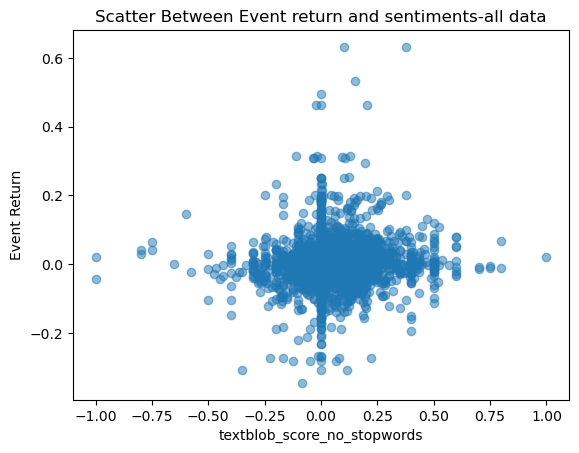

In [44]:
plt.scatter(data_df['textblob_score_no_stopwords'],data_df['eventRet'], alpha=0.5)
plt.title('Scatter Between Event return and sentiments-all data')
plt.ylabel('Event Return')
plt.xlabel('textblob_score_no_stopwords')
plt.show()

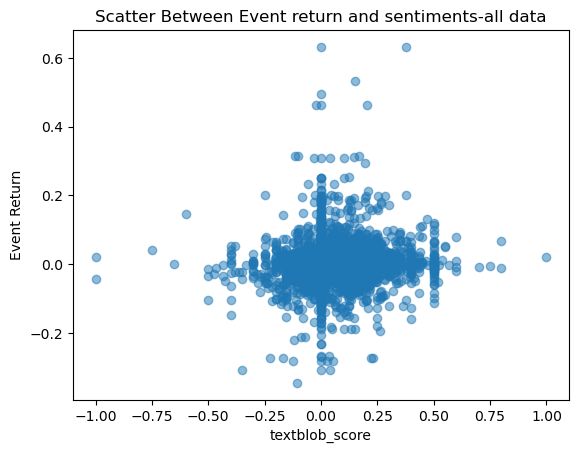

In [45]:
plt.scatter(data_df['textblob_score'],data_df['eventRet'], alpha=0.5)
plt.title('Scatter Between Event return and sentiments-all data')
plt.ylabel('Event Return')
plt.xlabel('textblob_score')
plt.show()

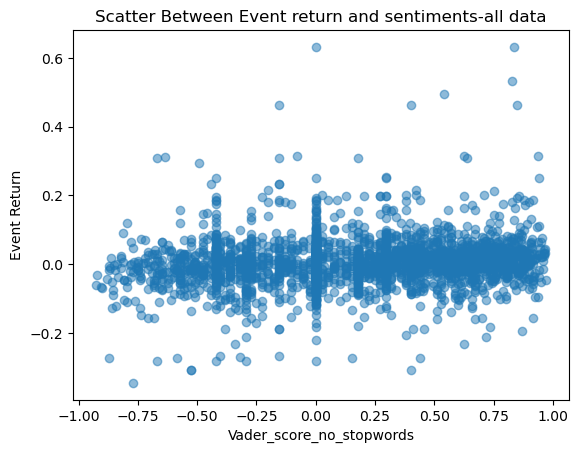

In [46]:
plt.scatter(data_df['Vader_score_no_stopwords'],data_df['eventRet'], alpha=0.5)
plt.title('Scatter Between Event return and sentiments-all data')
plt.ylabel('Event Return')
plt.xlabel('Vader_score_no_stopwords')
plt.show()

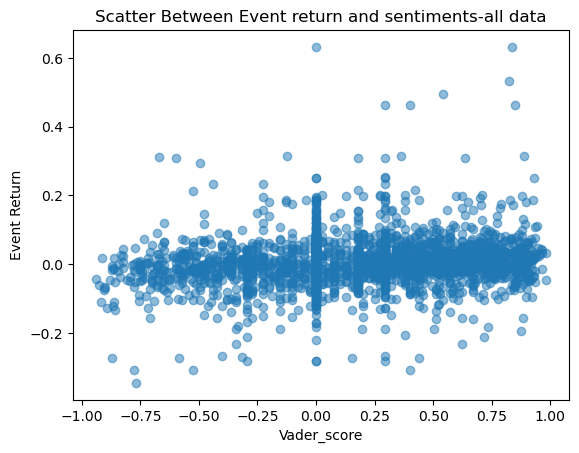

In [47]:
plt.scatter(data_df['Vader_score'],data_df['eventRet'], alpha=0.5)
plt.title('Scatter Between Event return and sentiments-all data')
plt.ylabel('Event Return')
plt.xlabel('Vader_score')
plt.show()

In [48]:
corrlation = data_df['eventRet'].corr(data_df['textblob_score_no_stopwords'])
print(corrlation)

0.07274668084287729


In [49]:
corrlation = data_df['eventRet'].corr(data_df['textblob_score'])
print(corrlation)

0.07444042435628269


In [50]:
corrlation = data_df['eventRet'].corr(data_df['Vader_score_no_stopwords'])
print(corrlation)

0.14107702093691027


In [51]:
corrlation = data_df['eventRet'].corr(data_df['Vader_score'])
print(corrlation)

0.16200655015089888


The correlation is positive, which means that news with positive sentiments lead to positive return and is expected. However,the correlation isn't very high.  We find that the correlation for the 'Vader_score' is the highest. this is a column where we have not removed the stop words

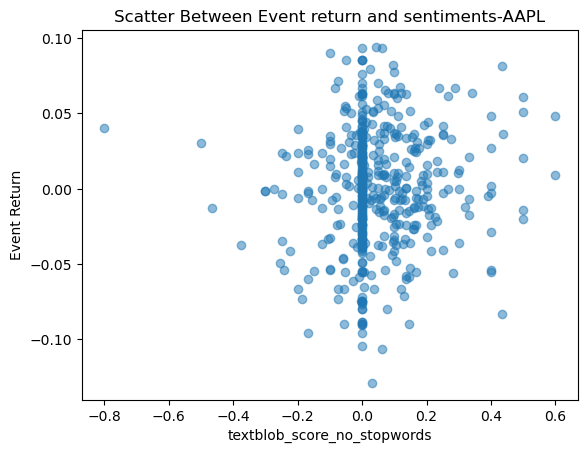

In [52]:
data_df_stock  = data_df[data_df['ticker'] == 'AAPL']
plt.scatter(data_df_stock['textblob_score_no_stopwords'],data_df_stock['eventRet'], alpha=0.5)
plt.title('Scatter Between Event return and sentiments-AAPL')
plt.ylabel('Event Return')
plt.xlabel('textblob_score_no_stopwords')
plt.show()

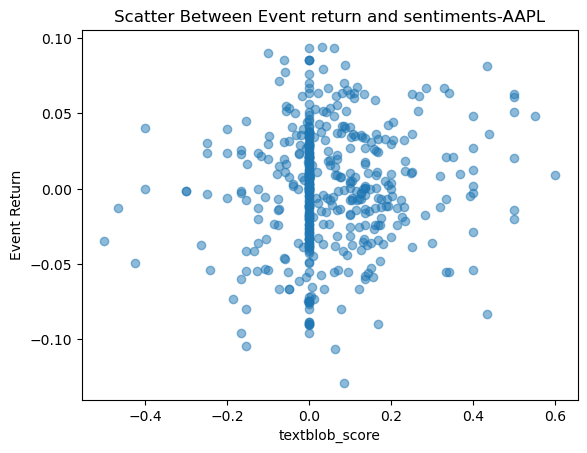

In [53]:
data_df_stock  = data_df[data_df['ticker'] == 'AAPL']
plt.scatter(data_df_stock['textblob_score'],data_df_stock['eventRet'], alpha=0.5)
plt.title('Scatter Between Event return and sentiments-AAPL')
plt.ylabel('Event Return')
plt.xlabel('textblob_score')
plt.show()

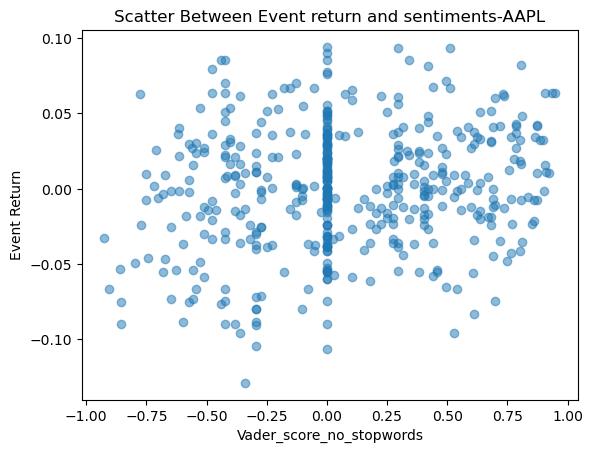

In [54]:
data_df_stock  = data_df[data_df['ticker'] == 'AAPL']
plt.scatter(data_df_stock['Vader_score_no_stopwords'],data_df_stock['eventRet'], alpha=0.5)
plt.title('Scatter Between Event return and sentiments-AAPL')
plt.ylabel('Event Return')
plt.xlabel('Vader_score_no_stopwords')
plt.show()

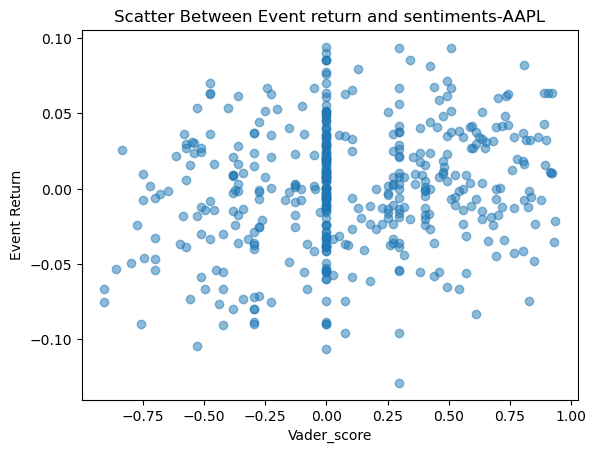

In [55]:
data_df_stock  = data_df[data_df['ticker'] == 'AAPL']
plt.scatter(data_df_stock['Vader_score'],data_df_stock['eventRet'], alpha=0.5)
plt.title('Scatter Between Event return and sentiments-AAPL')
plt.ylabel('Event Return')
plt.xlabel('Vader_score')
plt.show()

Overall, from the results we can see that there isn't a strong correlation between the news and the sentiments. Also, there are a lot of sentiments centred around 0. 

In [56]:
data_df['sentiment_textblob_subjectivity_no_stopwords'] = [TextBlob(s).sentiment.subjectivity for s in data_df['headline_without_stopwords']] 

In [57]:
data_df['sentiment_textblob_subjectivity'] = [TextBlob(s).sentiment.subjectivity for s in data_df['headline']] 

In [58]:
data_df

ticker                                           headline        date  \
0      AMZN  Whole Foods (WFMI) -5.2% following a downgrade...  2011-05-02   
1      NFLX  Netflix (NFLX +1.1%) shares post early gains a...  2011-05-02   
2      MSFT  The likely winners in Microsoft's (MSFT -1.4%)...  2011-05-10   
3      MSFT  Microsoft (MSFT -1.2%) and Skype signed their ...  2011-05-10   
5      AMZN  Amazon.com (AMZN -1.7%) shares slip as comment...  2011-05-12   
...     ...                                                ...         ...   
2639   TSLA  Morgan Stanley sees the rally in Tesla (NASDAQ...  2018-12-18   
2640   TSLA  Responding to a comment on Twitter, Elon Musk ...  2018-12-24   
2641   AMZN  Amazon (NASDAQ:AMZN) is among the companies th...  2018-12-24   
2642   AAPL  Chinese companies urge employees to boycott (N...  2018-12-24   
2643   TSLA  Elon Musk tweets that Tesla's (NASDAQ:TSLA) Su...  2018-12-26   

                             headline_without_stopwords  eventRet      Close  \
0     whole foods ( wfmi ) -5.2 % following downgrad...  0.017650  10.059500   
1     netflix ( nflx +1.1 % ) shares post early gain... -0.012912  33.884285   
2     likely winners microsoft 's ( msft -1.4 % ) sk... -0.019817  20.120020   
3     microsoft ( msft -1.2 % ) skype signed deal la... -0.019817  20.120020   
5     amazon.com ( amzn -1.7 % ) shares slip comment... -0.006607  10.303500   
...                                                 ...       ...        ...   
2639  morgan stanley sees rally tesla ( nasdaq : tsl... -0.092015  22.468666   
2640  responding comment twitter , elon musk weekend...  0.041608  19.692667   
2641  amazon ( nasdaq : amzn ) among companies sec p...  0.013062  67.197998   
2642  chinese companies urge employees boycott ( nas...  0.005652  35.375175   
2643  elon musk tweets tesla 's ( nasdaq : tsla ) su... -0.002856  21.739332   

      Vader_score  Vader_score_no_stopwords  textblob_score  \
0          0.0000                    0.0000        0.262500   
1          0.8360                    0.8360       -0.043750   
2          0.4767                    0.4767        0.166667   
3          0.3818                    0.3818       -0.030556   
5         -0.0516                   -0.0516        0.000000   
...           ...                       ...             ...   
2639       0.0000                    0.0000        0.000000   
2640       0.3818                    0.3818       -0.156250   
2641       0.1779                    0.1779        0.200000   
2642      -0.5719                   -0.5719       -0.012500   
2643       0.1779                    0.1779        0.000000   

      textblob_score_no_stopwords  score_diff  \
0                        0.262500   -0.262500   
1                       -0.043750    0.879750   
2                        0.000000    0.476700   
3                        0.011111    0.370689   
5                        0.000000   -0.051600   
...                           ...         ...   
2639                     0.000000    0.000000   
2640                    -0.156250    0.538050   
2641                    -0.100000    0.277900   
2642                    -0.012500   -0.559400   
2643                     0.000000    0.177900   

      sentiment_textblob_subjectivity_no_stopwords  \
0                                         0.462500   
1                                         0.400000   
2                                         0.708333   
3                                         0.044444   
5                                         0.000000   
...                                            ...   
2639                                      0.300000   
2640                                      0.343750   
2641                                      0.600000   
2642                                      0.025000   
2643                                      0.000000   

      sentiment_textblob_subjectivity  
0                            0.462500  
1                            0.4

We see that the statement has a positive sentiment of .5 but looking at the words that give rise to the sentiments, the word "touching" and not "high" causes positive sentiment. 

## Supervised Learning-Classification algorithms

In this step, we develop customised model for sentiment analysis, based on available labelled data. The label data for this is obtained from kaggle website. Let us look at the data.

In [59]:
#sentiments_data = pd.read_csv(r'LabelledNewsData.csv',encoding = "ISO-8859-1")
sentiments_data = data_df
#data_df

In [60]:
sentiments_data.head(10)

ticker                                           headline        date  \
0    AMZN  Whole Foods (WFMI) -5.2% following a downgrade...  2011-05-02   
1    NFLX  Netflix (NFLX +1.1%) shares post early gains a...  2011-05-02   
2    MSFT  The likely winners in Microsoft's (MSFT -1.4%)...  2011-05-10   
3    MSFT  Microsoft (MSFT -1.2%) and Skype signed their ...  2011-05-10   
5    AMZN  Amazon.com (AMZN -1.7%) shares slip as comment...  2011-05-12   
6    GOOG  It's been some time coming, but Google (GOOG -...  2011-05-16   
7      BA  In "a big win for Europe," the WTO partly over...  2011-05-18   
8    MSFT  Accusing underwriters of digging out their lat...  2011-05-19   
9    MSFT  If you bought LinkedIn (LNKD, now legging high...  2011-05-19   
10   MSFT  From Jens Heycke, the top 5 things you could b...  2011-05-19   

                           headline_without_stopwords  eventRet      Close  \
0   whole foods ( wfmi ) -5.2 % following downgrad...  0.017650  10.059500   
1   netflix ( nflx +1.1 % ) shares post early gain... -0.012912  33.884285   
2   likely winners microsoft 's ( msft -1.4 % ) sk... -0.019817  20.120020   
3   microsoft ( msft -1.2 % ) skype signed deal la... -0.019817  20.120020   
5   amazon.com ( amzn -1.7 % ) shares slip comment... -0.006607  10.303500   
6   's time coming , google ( goog -1.9 % ) makes ... -0.008073  12.912102   
7   " big win europe , " wto partly overturns ruli...  0.003391  62.297920   
8   accusing underwriters digging late 1990s playb... -0.001156  19.502411   
9   bought linkedin ( lnkd , legging higher , +155... -0.001156  19.502411   
10  jens heycke , top 5 things could buy $ 4b ( um... -0.001156  19.502411   

    Vader_score  Vader_score_no_stopwords  textblob_score  \
0        0.0000                    0.0000        0.262500   
1        0.8360                    0.8360       -0.043750   
2        0.4767                    0.4767        0.166667   
3        0.3818                    0.3818       -0.030556   
5       -0.0516                   -0.0516        0.000000   
6        0.2617                    0.1779        0.125000   
7       -0.5122                   -0.5122        0.100000   
8       -0.4404                   -0.4404       -0.650000   
9        0.4215                    0.4215       -0.052083   
10       0.2023                    0.2023        0.500000   

    textblob_score_no_stopwords  score_diff  \
0                      0.262500   -0.262500   
1                     -0.043750    0.879750   
2                      0.000000    0.476700   
3                      0.011111    0.370689   
5                      0.000000   -0.051600   
6                      0.083333    0.094567   
7                      0.100000   -0.612200   
8                     -0.650000    0.209600   
9                      0.019167    0.402333   
10                     0.500000   -0.297700   

    sentiment_textblob_subjectivity_no_stopwords  \
0                                       0.462500   
1                                       0.400000   
2                                       0.708333   
3                                       0.044444   
5                                       0.000000   
6                                       0.211111   
7                                       0.333333   
8                                       0.800000   
9                                       0.426667   
10                                      0.500000   

    sentiment_textblob_subjectivity  
0                          0.462500  
1                          0.400000  
2                          0.750000  
3                          0.169444  
5                          0.000000  
6                          0.166667  
7                          0.333333  
8                          0.800000  
9                          0.385417  
10                         0.500000

In [61]:
Vader_polarity_class = []
for score in data_df['Vader_score_no_stopwords']:
    if score < -0.5:
        s= -2
        Vader_polarity_class.append(s)
    elif -0.5 < score < -0.1:
        s=-1
        Vader_polarity_class.append(s)
    elif -0.1 < score < 0.1:
        s=0
        Vader_polarity_class.append(s)
    elif 0.1 < score < 0.5:
        s=1
        Vader_polarity_class.append(s)  
    else:
        s=2
        Vader_polarity_class.append(s)
        
sentiments_data['Vader_polarity_class_no_stopwords'] = Vader_polarity_class


In [62]:
Vader_polarity_class = []
for score in data_df['Vader_score']:
    if score < -0.5:
        s= -2
        Vader_polarity_class.append(s)
    elif -0.5 < score < -0.1:
        s=-1
        Vader_polarity_class.append(s)
    elif -0.1 < score < 0.1:
        s=0
        Vader_polarity_class.append(s)
    elif 0.1 < score < 0.5:
        s=1
        Vader_polarity_class.append(s)  
    else:
        s=2
        Vader_polarity_class.append(s)
        
sentiments_data['Vader_polarity_class'] = Vader_polarity_class

In [63]:
sentiments_data

ticker                                           headline        date  \
0      AMZN  Whole Foods (WFMI) -5.2% following a downgrade...  2011-05-02   
1      NFLX  Netflix (NFLX +1.1%) shares post early gains a...  2011-05-02   
2      MSFT  The likely winners in Microsoft's (MSFT -1.4%)...  2011-05-10   
3      MSFT  Microsoft (MSFT -1.2%) and Skype signed their ...  2011-05-10   
5      AMZN  Amazon.com (AMZN -1.7%) shares slip as comment...  2011-05-12   
...     ...                                                ...         ...   
2639   TSLA  Morgan Stanley sees the rally in Tesla (NASDAQ...  2018-12-18   
2640   TSLA  Responding to a comment on Twitter, Elon Musk ...  2018-12-24   
2641   AMZN  Amazon (NASDAQ:AMZN) is among the companies th...  2018-12-24   
2642   AAPL  Chinese companies urge employees to boycott (N...  2018-12-24   
2643   TSLA  Elon Musk tweets that Tesla's (NASDAQ:TSLA) Su...  2018-12-26   

                             headline_without_stopwords  eventRet      Close  \
0     whole foods ( wfmi ) -5.2 % following downgrad...  0.017650  10.059500   
1     netflix ( nflx +1.1 % ) shares post early gain... -0.012912  33.884285   
2     likely winners microsoft 's ( msft -1.4 % ) sk... -0.019817  20.120020   
3     microsoft ( msft -1.2 % ) skype signed deal la... -0.019817  20.120020   
5     amazon.com ( amzn -1.7 % ) shares slip comment... -0.006607  10.303500   
...                                                 ...       ...        ...   
2639  morgan stanley sees rally tesla ( nasdaq : tsl... -0.092015  22.468666   
2640  responding comment twitter , elon musk weekend...  0.041608  19.692667   
2641  amazon ( nasdaq : amzn ) among companies sec p...  0.013062  67.197998   
2642  chinese companies urge employees boycott ( nas...  0.005652  35.375175   
2643  elon musk tweets tesla 's ( nasdaq : tsla ) su... -0.002856  21.739332   

      Vader_score  Vader_score_no_stopwords  textblob_score  \
0          0.0000                    0.0000        0.262500   
1          0.8360                    0.8360       -0.043750   
2          0.4767                    0.4767        0.166667   
3          0.3818                    0.3818       -0.030556   
5         -0.0516                   -0.0516        0.000000   
...           ...                       ...             ...   
2639       0.0000                    0.0000        0.000000   
2640       0.3818                    0.3818       -0.156250   
2641       0.1779                    0.1779        0.200000   
2642      -0.5719                   -0.5719       -0.012500   
2643       0.1779                    0.1779        0.000000   

      textblob_score_no_stopwords  score_diff  \
0                        0.262500   -0.262500   
1                       -0.043750    0.879750   
2                        0.000000    0.476700   
3                        0.011111    0.370689   
5                        0.000000   -0.051600   
...                           ...         ...   
2639                     0.000000    0.000000   
2640                    -0.156250    0.538050   
2641                    -0.100000    0.277900   
2642                    -0.012500   -0.559400   
2643                     0.000000    0.177900   

      sentiment_textblob_subjectivity_no_stopwords  \
0                                         0.462500   
1                                         0.400000   
2                                         0.708333   
3                                         0.044444   
5                                         0.000000   
...                                            ...   
2639                                      0.300000   
2640                                      0.343750   
2641                                      0.600000   
2642                                      0.025000   
2643                                      0.000000   

      sentiment_textblob_subjectivity  Vader_polarity_class_no_stopwords  \
0                            0.46250

In [64]:
print(sentiments_data.shape[0],',', sentiments_data.ticker.unique().shape[0])

2635 , 10


The data has headlines for the news across 10 different stocks, with total 2635 rows, and has sentiments labelled -2,-1,0,1 and 2.

The intervals for the polarity score are selected such that if the VADER score was below -0.5 we would definitely make the decision to sell the stock. If the value of the score was between -0.5 and -0.1 we would maybe consider selling it. If the score was between -0.1 and 0.1 then we decide to hold the stock. If the polarity score was between 0.1 and 0.5 we could maybe buy the stock and if the polarity score was above 0.5 we would definitely buy. 

In order to run a supervised learning model, we first need to convert the news headlines into feature representation. 

In [65]:
# word-embedding
all_vectors = pd.np.array([pd.np.array([token.vector for token in nlp(s)]).mean(axis=0)*pd.np.ones((300)) \
                           for s in sentiments_data['headline_without_stopwords']])

Now that we have prepared the independent variable we train the classification model in a similar manner as discussed in chapter 6. We first divide the data into training set and test set and futher run the key classification models. 

In [66]:
# split out validation dataset for the end
Y= sentiments_data["Vader_polarity_class_no_stopwords"]
X = all_vectors

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
validation_size = 0.3
seed = 7
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=validation_size, random_state=seed)

# test options for classification
num_folds = 10
seed = 7
scoring = 'accuracy'

# spot check the algorithms
models = []
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('SVM', SVC()))
#Neural Network
models.append(('NN', MLPClassifier()))
#Ensemble Models 
models.append(('RF', RandomForestClassifier()))

Running all the classification models

In [67]:
results = []
names = []
kfold_results = []
test_results = []
train_results = []
for name, model in models:

    kfold = KFold(n_splits=num_folds)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    #msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    #print(msg)
   # Full Training period
    res = model.fit(X_train, Y_train)
    train_result = accuracy_score(res.predict(X_train), Y_train)
    train_results.append(train_result)
    
    # Test results
    test_result = accuracy_score(res.predict(X_test), Y_test)
    test_results.append(test_result)    
    
    msg = "%s: %f (%f) %f %f" % (name, cv_results.mean(), cv_results.std(), train_result, test_result)
    print(msg)
    print(confusion_matrix(res.predict(X_test), Y_test))
    print(classification_report(res.predict(X_test), Y_test))

LR: 0.484269 (0.028932) 0.683839 0.463970
[[ 18  17   6   6   5]
 [ 19  63  16  19  10]
 [ 11  27  76  33  13]
 [ 11  26  39  94  43]
 [  8  16  31  68 116]]
              precision    recall  f1-score   support

          -2       0.27      0.35      0.30        52
          -1       0.42      0.50      0.46       127
           0       0.45      0.47      0.46       160
           1       0.43      0.44      0.43       213
           2       0.62      0.49      0.54       239

    accuracy                           0.46       791
   macro avg       0.44      0.45      0.44       791
weighted avg       0.48      0.46      0.47       791

KNN: 0.361672 (0.037341) 0.567787 0.359039
[[  9  20  10  11   9]
 [  6  53  30  34  20]
 [  6  27  56  42  17]
 [ 13  18  32  62  37]
 [ 33  31  40  71 104]]
              precision    recall  f1-score   support

          -2       0.13      0.15      0.14        59
          -1       0.36      0.37      0.36       143
           0       0.33      0.

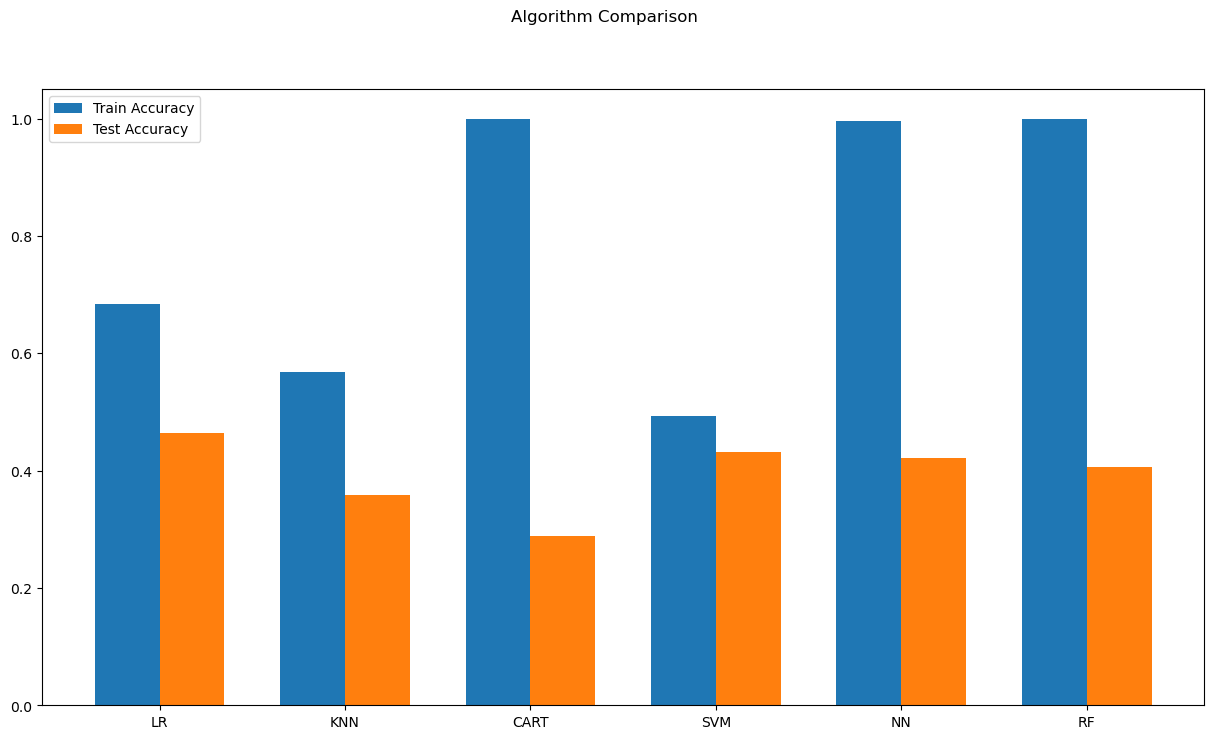

In [68]:
# compare algorithms
from matplotlib import pyplot
fig = pyplot.figure()
ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results,  width=width, label='Train Accuracy')
pyplot.bar(ind + width/2, test_results, width=width, label='Test Accuracy')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.show()


As we can see the NN, RF and CART model is the best performer with the a training accuracy of 99% However the test accuracy is very low. Therefore, we observe very high overfitting. Hence we decide to have a different method of clasifying our classes. This can be seen below in the trading strategy section.

In [69]:
# word-embedding of main headline data
all_vectors = pd.np.array([pd.np.array([token.vector for token in nlp(s) ]).mean(axis=0)*pd.np.ones((300)) \
                           for s in data_df['headline_without_stopwords']])

In [70]:
Y_NN = models[4][1].predict(all_vectors)

In [71]:
data_df['sentiment_NN'] = Y_NN 

In [72]:
corrlation = data_df['eventRet'].corr(data_df['sentiment_NN'])
print(corrlation)

0.1326588254209671


In [73]:
data_df.head()

ticker                                           headline        date  \
0   AMZN  Whole Foods (WFMI) -5.2% following a downgrade...  2011-05-02   
1   NFLX  Netflix (NFLX +1.1%) shares post early gains a...  2011-05-02   
2   MSFT  The likely winners in Microsoft's (MSFT -1.4%)...  2011-05-10   
3   MSFT  Microsoft (MSFT -1.2%) and Skype signed their ...  2011-05-10   
5   AMZN  Amazon.com (AMZN -1.7%) shares slip as comment...  2011-05-12   

                          headline_without_stopwords  eventRet      Close  \
0  whole foods ( wfmi ) -5.2 % following downgrad...  0.017650  10.059500   
1  netflix ( nflx +1.1 % ) shares post early gain... -0.012912  33.884285   
2  likely winners microsoft 's ( msft -1.4 % ) sk... -0.019817  20.120020   
3  microsoft ( msft -1.2 % ) skype signed deal la... -0.019817  20.120020   
5  amazon.com ( amzn -1.7 % ) shares slip comment... -0.006607  10.303500   

   Vader_score  Vader_score_no_stopwords  textblob_score  \
0       0.0000                    0.0000        0.262500   
1       0.8360                    0.8360       -0.043750   
2       0.4767                    0.4767        0.166667   
3       0.3818                    0.3818       -0.030556   
5      -0.0516                   -0.0516        0.000000   

   textblob_score_no_stopwords  score_diff  \
0                     0.262500   -0.262500   
1                    -0.043750    0.879750   
2                     0.000000    0.476700   
3                     0.011111    0.370689   
5                     0.000000   -0.051600   

   sentiment_textblob_subjectivity_no_stopwords  \
0                                      0.462500   
1                                      0.400000   
2                                      0.708333   
3                                      0.044444   
5                                      0.000000   

   sentiment_textblob_subjectivity  Vader_polarity_class_no_stopwords  \
0                         0.462500                                  0   
1                         0.400000                                  2   
2                         0.750000                                  1   
3                         0.169444                                  1   
5                         0.000000                                  0   

   Vader_polarity_class  sentiment_NN  
0                     0             0  
1                     2             2  
2                     1             1  
3                     1             1  
5                     0             0

## Unsupervised - Model based on financial lexicon

Lexicons are special dictionaries or vocabularies that have been created for analyzing sentiments.
VADER (Valence Aware Dictionary for Entiment Reasoning) is a pre-built sentiment analysis model included in the NLTK package. 

In [74]:
# stock market lexicon
sia = SentimentIntensityAnalyzer()
stock_lex = pd.read_csv('LexiconData.csv')
stock_lex['sentiment'] = (stock_lex['Aff_Score'] + stock_lex['Neg_Score'])/2
stock_lex = dict(zip(stock_lex.Item, stock_lex.sentiment))
stock_lex = {k:v for k,v in stock_lex.items() if len(k.split(' '))==1}
stock_lex_scaled = {}
for k, v in stock_lex.items():
    if v > 0:
        stock_lex_scaled[k] = v / max(stock_lex.values()) * 4
    else:
        stock_lex_scaled[k] = v / min(stock_lex.values()) * -4

final_lex = {}
final_lex.update(stock_lex_scaled)
final_lex.update(sia.lexicon)
sia.lexicon = final_lex

Example of extracting sentiment score for a sentence:

In [75]:
text = "AAPL is trading higher after reporting its October sales rose 12.6% M/M. It has seen a 20%+ jump in orders"

In [76]:
sia.polarity_scores(text)['compound']

0.4535

Now we extract the sentiment for the entire dataset.

In [77]:
vader_sentiments = pd.np.array([sia.polarity_scores(s)['compound'] for s in data_df['headline_without_stopwords']])
vader_sentiments.shape

(2635,)

In [78]:
data_df['sentiment_lex'] = vader_sentiments

Correlation of event returns with VADER score calculated

In [79]:
corrlation = data_df['eventRet'].corr(data_df['sentiment_lex'])
print(corrlation)

0.12573237622975506


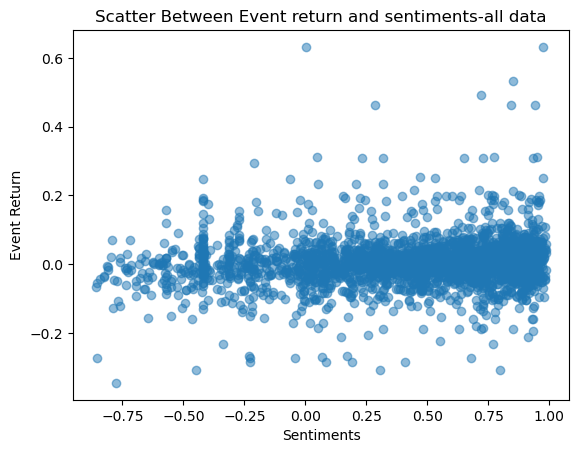

In [80]:
plt.scatter(data_df['sentiment_lex'],data_df['eventRet'], alpha=0.5)
plt.title('Scatter Between Event return and sentiments-all data')
plt.ylabel('Event Return')
plt.xlabel('Sentiments')
plt.show()

We don's see many high returns for lower sentiments, but the data may not be very clear. Let us look at the result for one of the stock tickers. 

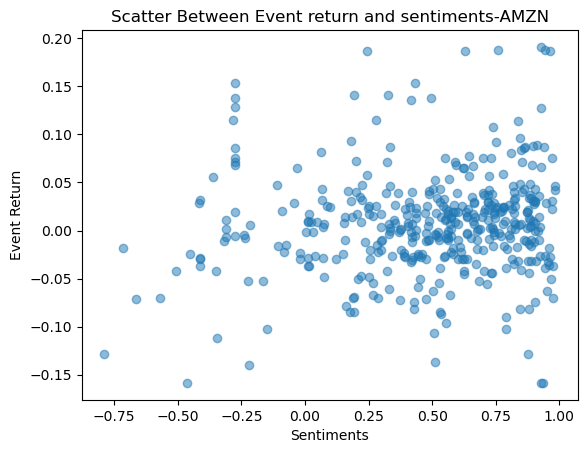

In [81]:
data_df_stock  = data_df[data_df['ticker'] == 'AMZN']
plt.scatter(data_df_stock['sentiment_lex'],data_df_stock['eventRet'], alpha=0.5)
plt.title('Scatter Between Event return and sentiments-AMZN')
plt.ylabel('Event Return')
plt.xlabel('Sentiments')
plt.show()

We see a positive correlation between the event return and sentiments. We will look deeper into the comparison of different types of the sentiment analysis in the next section.

In [82]:
data_df.to_csv(r'Data\Step4_DataWithSentimentsResults.csv', sep='|', index=False)

## Exploratory Data Analysis and comparison

In [83]:
data_df = pd.read_csv(r'Data\Step4_DataWithSentimentsResults.csv', sep='|')
data_df = data_df[data_df['ticker'].isin(tickers)]

Let us look at the sample headlines and the the sentiments from three different methodology, followed by the analysis using visualization. 

In [84]:
data_new_df_stock=data_df[data_df['ticker']== 'NFLX'][['ticker','headline_without_stopwords','textblob_score',
                                                       'sentiment_lex']]
from pandas import option_context

with option_context('display.max_colwidth', 400):
    display(data_new_df_stock.head(1))

ticker  \
1   NFLX   

                                                                                                                                                                                                                                                                                                              headline_without_stopwords  \
1  netflix ( nflx +1.1 % ) shares post early gains citigroup ups rating buy lifts price target $ 300 $ 245 . u.s. revenue growth sustainable , citi says , " path 50 subscribers 2013 , " adding nflx little competition price , selection   convenience ; mass market adoption tablets help , mass - market adoption phase still come .   

   textblob_score  sentiment_lex  
1        -0.04375         0.8669

Looking at one of the headlines, the sentiment from this sentence is positive. 

<AxesSubplot:title={'center':'Correlation Matrix'}>

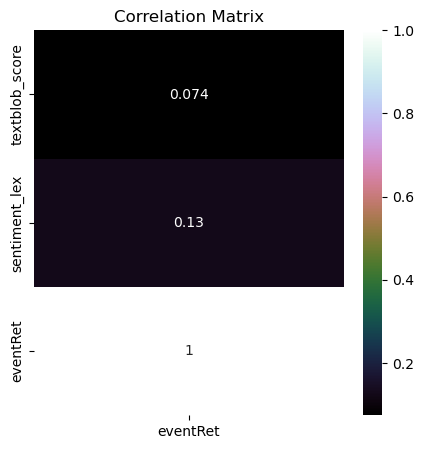

In [85]:
correlation = data_df[['textblob_score','sentiment_lex','eventRet']].dropna(axis=0).corr()

plt.figure(figsize=(5,5))
plt.title('Correlation Matrix')
sns.heatmap(correlation[['eventRet']], vmax=1, annot=True,cmap='cubehelix')

All the sentiments have positive relationship with the return which is intuitive and expected. 

In [86]:
corr_data = []
for ticker in data_df['ticker'].unique():
    data_new_df_stock=data_df[data_df['ticker']==ticker]
    #Only look for the stocks with sufficient data
    if data_new_df_stock.shape[0] > 40 : 
        corr_textblob= data_new_df_stock['eventRet'].corr(data_new_df_stock['textblob_score'])    
        corr_lex = data_new_df_stock['eventRet'].corr(data_new_df_stock['sentiment_lex'])
        corr_data.append([ticker,corr_textblob, corr_lex])
        print(ticker, corr_lex, corr_textblob)
    else:
        continue

AMZN 0.11136096850927953 0.019829667384321986
NFLX 0.1666878047770582 0.09259214103465102
MSFT -0.04401763056997374 -0.02543371022142204
GOOG 0.10716540937740579 0.04424681185783118
BA 0.2588134164113249 0.28877857198556134
JPM -0.021610259824101453 -0.16050831993653605
TSLA 0.17817713011072886 0.11839963853288304
AAPL 0.17812121392665323 0.10841079670725796
WMT 0.08458839193332324 0.1866738423875088
ADBE 0.05581522496654414 0.03378531996388107


In [87]:
corr_df = pd.DataFrame(corr_data, columns =  ['ticker','corr_textblob', 'corr_lex'])  
corr_df=corr_df.set_index('ticker')
corr_df.head(1)

corr_textblob  corr_lex
ticker                         
AMZN          0.01983  0.111361

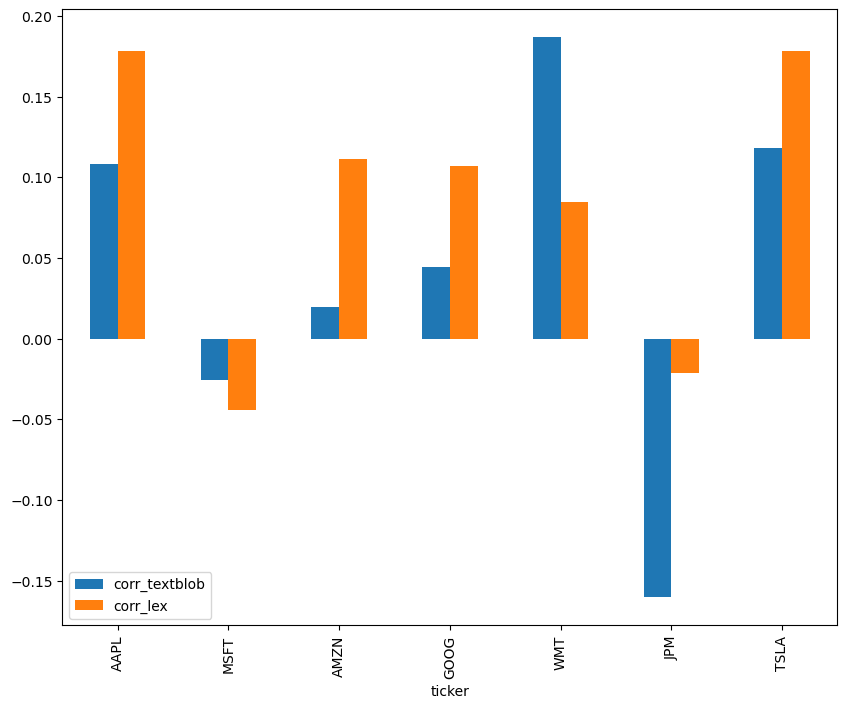

In [88]:
corr_df.to_csv("correlation.csv")     
tickers = ['AAPL','MSFT','AMZN','GOOG','WMT','JPM','TSLA']
corr_df.loc[tickers].plot.bar(figsize = (10,8))
plt.show()

Looking at the chart the corrlation from the lexicon methodology is highest across all the stock tickers, which corraborates the conclusion from the previous analysis.

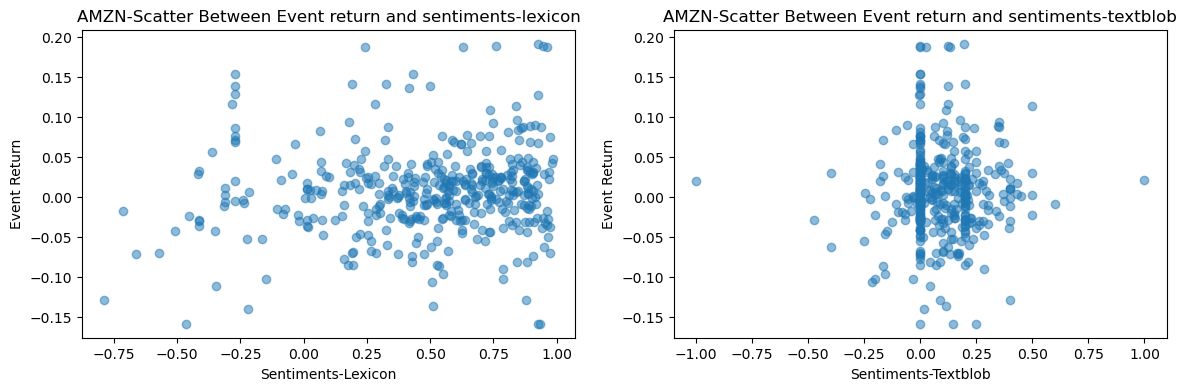

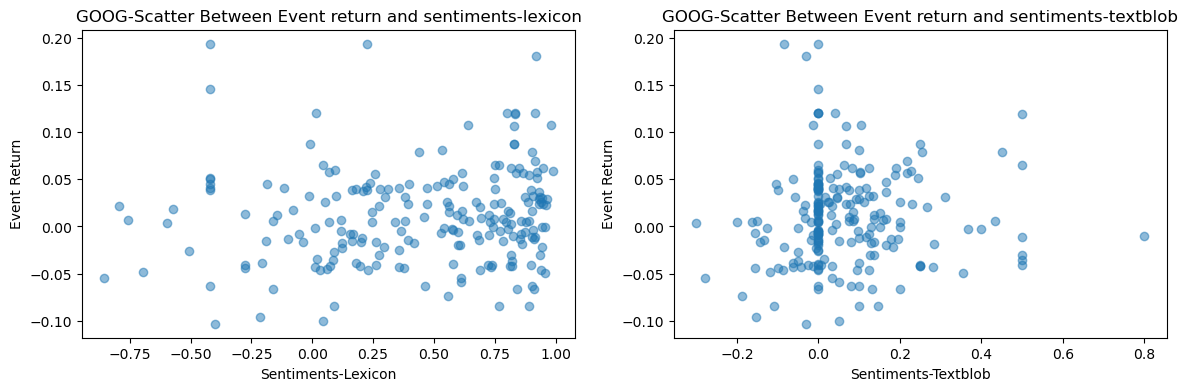

In [89]:
#tickers = corr_df.nlargest(5,'corr_lex').index
for ticker in tickers[2:4]:
    data_df_stock  = data_df[data_df['ticker'] == ticker]
    fig = plt.figure(figsize=(14, 4), constrained_layout=False)

    plt.subplot(1, 2, 1)
    plt.scatter(data_df_stock['sentiment_lex'],data_df_stock['eventRet'], alpha=0.5)
    plt.title(ticker + '-Scatter Between Event return and sentiments-lexicon')
    plt.ylabel('Event Return')
    plt.xlabel('Sentiments-Lexicon')

    
    plt.subplot(1, 2, 2)
    plt.scatter(data_df_stock['textblob_score'],data_df_stock['eventRet'], alpha=0.5)
    plt.title(ticker + '-Scatter Between Event return and sentiments-textblob')
    plt.ylabel('Event Return')
    plt.xlabel('Sentiments-Textblob')
    plt.show()
    

The lexicon based sentiments on the left definitely shows a positive relationship between the sentiments and return. We use lexicon based sentiments for the trading strategy in the next step.

In [90]:
data_df

ticker                                           headline        date  \
0      AMZN  Whole Foods (WFMI) -5.2% following a downgrade...  2011-05-02   
1      NFLX  Netflix (NFLX +1.1%) shares post early gains a...  2011-05-02   
2      MSFT  The likely winners in Microsoft's (MSFT -1.4%)...  2011-05-10   
3      MSFT  Microsoft (MSFT -1.2%) and Skype signed their ...  2011-05-10   
4      AMZN  Amazon.com (AMZN -1.7%) shares slip as comment...  2011-05-12   
...     ...                                                ...         ...   
2630   TSLA  Morgan Stanley sees the rally in Tesla (NASDAQ...  2018-12-18   
2631   TSLA  Responding to a comment on Twitter, Elon Musk ...  2018-12-24   
2632   AMZN  Amazon (NASDAQ:AMZN) is among the companies th...  2018-12-24   
2633   AAPL  Chinese companies urge employees to boycott (N...  2018-12-24   
2634   TSLA  Elon Musk tweets that Tesla's (NASDAQ:TSLA) Su...  2018-12-26   

                             headline_without_stopwords  eventRet      Close  \
0     whole foods ( wfmi ) -5.2 % following downgrad...  0.017650  10.059500   
1     netflix ( nflx +1.1 % ) shares post early gain... -0.012912  33.884285   
2     likely winners microsoft 's ( msft -1.4 % ) sk... -0.019817  20.120020   
3     microsoft ( msft -1.2 % ) skype signed deal la... -0.019817  20.120020   
4     amazon.com ( amzn -1.7 % ) shares slip comment... -0.006607  10.303500   
...                                                 ...       ...        ...   
2630  morgan stanley sees rally tesla ( nasdaq : tsl... -0.092015  22.468666   
2631  responding comment twitter , elon musk weekend...  0.041608  19.692667   
2632  amazon ( nasdaq : amzn ) among companies sec p...  0.013062  67.197998   
2633  chinese companies urge employees boycott ( nas...  0.005652  35.375175   
2634  elon musk tweets tesla 's ( nasdaq : tsla ) su... -0.002856  21.739332   

      Vader_score  Vader_score_no_stopwords  textblob_score  \
0          0.0000                    0.0000        0.262500   
1          0.8360                    0.8360       -0.043750   
2          0.4767                    0.4767        0.166667   
3          0.3818                    0.3818       -0.030556   
4         -0.0516                   -0.0516        0.000000   
...           ...                       ...             ...   
2630       0.0000                    0.0000        0.000000   
2631       0.3818                    0.3818       -0.156250   
2632       0.1779                    0.1779        0.200000   
2633      -0.5719                   -0.5719       -0.012500   
2634       0.1779                    0.1779        0.000000   

      textblob_score_no_stopwords  score_diff  \
0                        0.262500   -0.262500   
1                       -0.043750    0.879750   
2                        0.000000    0.476700   
3                        0.011111    0.370689   
4                        0.000000   -0.051600   
...                           ...         ...   
2630                     0.000000    0.000000   
2631                    -0.156250    0.538050   
2632                    -0.100000    0.277900   
2633                    -0.012500   -0.559400   
2634                     0.000000    0.177900   

      sentiment_textblob_subjectivity_no_stopwords  \
0                                         0.462500   
1                                         0.400000   
2                                         0.708333   
3                                         0.044444   
4                                         0.000000   
...                                            ...   
2630                                      0.300000   
2631                                      0.343750   
2632                                      0.600000   
2633                                      0.025000   
2634                                      0.000000   

      sentiment_textblob_subjectivity  Vader_polarity_class_no_stopwords  \
0                            0.46250

# Model Evaluation- Building a Trading Strategy

The sentiment data can be used in different ways for the trading strategy. Sentiment scores can be used as a directional signal and ideally create a long-short portfolio, by buying the stocks with positive score and selling the stocks with negative score. The sentiments can also be used as additional features over and above other features(such as correlated stocks, technical indicators) in a supervised learning model to predict the price or come up with a trading strategy. 

In the trading strategy in this case study we buy and sell stock as per the current stock sentiments : 
* Buy a stock when the change in sentiment score (Current sentiment score - previous sentiment score) is greater than .5 and sell a stock when the change in sentiment score is less than -.5.
* Additionally, we check for 15 days moving average while buying and selling and buy or sell in a unit of 100. 

We use lexicon based sentiments for the trading strategy.


In [91]:
data_df

ticker                                           headline        date  \
0      AMZN  Whole Foods (WFMI) -5.2% following a downgrade...  2011-05-02   
1      NFLX  Netflix (NFLX +1.1%) shares post early gains a...  2011-05-02   
2      MSFT  The likely winners in Microsoft's (MSFT -1.4%)...  2011-05-10   
3      MSFT  Microsoft (MSFT -1.2%) and Skype signed their ...  2011-05-10   
4      AMZN  Amazon.com (AMZN -1.7%) shares slip as comment...  2011-05-12   
...     ...                                                ...         ...   
2630   TSLA  Morgan Stanley sees the rally in Tesla (NASDAQ...  2018-12-18   
2631   TSLA  Responding to a comment on Twitter, Elon Musk ...  2018-12-24   
2632   AMZN  Amazon (NASDAQ:AMZN) is among the companies th...  2018-12-24   
2633   AAPL  Chinese companies urge employees to boycott (N...  2018-12-24   
2634   TSLA  Elon Musk tweets that Tesla's (NASDAQ:TSLA) Su...  2018-12-26   

                             headline_without_stopwords  eventRet      Close  \
0     whole foods ( wfmi ) -5.2 % following downgrad...  0.017650  10.059500   
1     netflix ( nflx +1.1 % ) shares post early gain... -0.012912  33.884285   
2     likely winners microsoft 's ( msft -1.4 % ) sk... -0.019817  20.120020   
3     microsoft ( msft -1.2 % ) skype signed deal la... -0.019817  20.120020   
4     amazon.com ( amzn -1.7 % ) shares slip comment... -0.006607  10.303500   
...                                                 ...       ...        ...   
2630  morgan stanley sees rally tesla ( nasdaq : tsl... -0.092015  22.468666   
2631  responding comment twitter , elon musk weekend...  0.041608  19.692667   
2632  amazon ( nasdaq : amzn ) among companies sec p...  0.013062  67.197998   
2633  chinese companies urge employees boycott ( nas...  0.005652  35.375175   
2634  elon musk tweets tesla 's ( nasdaq : tsla ) su... -0.002856  21.739332   

      Vader_score  Vader_score_no_stopwords  textblob_score  \
0          0.0000                    0.0000        0.262500   
1          0.8360                    0.8360       -0.043750   
2          0.4767                    0.4767        0.166667   
3          0.3818                    0.3818       -0.030556   
4         -0.0516                   -0.0516        0.000000   
...           ...                       ...             ...   
2630       0.0000                    0.0000        0.000000   
2631       0.3818                    0.3818       -0.156250   
2632       0.1779                    0.1779        0.200000   
2633      -0.5719                   -0.5719       -0.012500   
2634       0.1779                    0.1779        0.000000   

      textblob_score_no_stopwords  score_diff  \
0                        0.262500   -0.262500   
1                       -0.043750    0.879750   
2                        0.000000    0.476700   
3                        0.011111    0.370689   
4                        0.000000   -0.051600   
...                           ...         ...   
2630                     0.000000    0.000000   
2631                    -0.156250    0.538050   
2632                    -0.100000    0.277900   
2633                    -0.012500   -0.559400   
2634                     0.000000    0.177900   

      sentiment_textblob_subjectivity_no_stopwords  \
0                                         0.462500   
1                                         0.400000   
2                                         0.708333   
3                                         0.044444   
4                                         0.000000   
...                                            ...   
2630                                      0.300000   
2631                                      0.343750   
2632                                      0.600000   
2633                                      0.025000   
2634                                      0.000000   

      sentiment_textblob_subjectivity  Vader_polarity_class_no_stopwords  \
0                            0.46250

Creating a new dataframe for the purpose of trading

In [92]:
trade_df = data_df[['ticker','sentiment_lex','eventRet','Close','date']]

In [93]:
trade_df.head(50)

ticker  sentiment_lex  eventRet      Close        date
0    AMZN         0.2996  0.017650  10.059500  2011-05-02
1    NFLX         0.8669 -0.012912  33.884285  2011-05-02
2    MSFT         0.6435 -0.019817  20.120020  2011-05-10
3    MSFT         0.7413 -0.019817  20.120020  2011-05-10
4    AMZN        -0.3100 -0.006607  10.303500  2011-05-12
5    GOOG         0.1561 -0.008073  12.912102  2011-05-16
6      BA         0.3399  0.003391  62.297920  2011-05-18
7    MSFT        -0.5820 -0.001156  19.502411  2011-05-19
8    MSFT         0.7440 -0.001156  19.502411  2011-05-19
9    MSFT         0.3941 -0.001156  19.502411  2011-05-19
10   MSFT         0.8579 -0.001156  19.502411  2011-05-19
11   MSFT         0.1114 -0.001156  19.502411  2011-05-19
12   AMZN         0.5451 -0.028021   9.811000  2011-05-23
13    JPM         0.7376 -0.038156  30.618246  2011-05-23
14   MSFT        -0.3921 -0.023198  19.068502  2011-05-23
15   NFLX         0.6024  0.063507  37.067142  2011-05-25
16   TSLA         0.7538  0.098105   1.932000  2011-05-25
17   GOOG         0.0700  0.005103  12.904879  2011-05-26
18   MSFT         0.7052 -0.021690  19.273624  2011-06-01
19   TSLA         0.8036  0.008590   2.008667  2011-06-03
20   AAPL        -0.1439 -0.032870  10.093047  2011-06-07
21   AAPL         0.5653  0.002913  10.105207  2011-06-14
22   GOOG         0.8553 -0.012831  12.661791  2011-06-14
23   GOOG         0.6876 -0.046469  12.462537  2011-06-16
24   GOOG         0.8198 -0.036714  12.080220  2011-06-17
25   AMZN         0.7220  0.056734   9.386000  2011-06-20
26   AAPL         0.8929  0.001156   9.584808  2011-06-20
27    WMT         0.9135  0.008689  40.737019  2011-06-20
28    JPM         0.6953 -0.002598  29.438126  2011-06-21
29   GOOG         0.7287  0.004319  12.278975  2011-06-21
30   GOOG         0.2435  0.004319  12.278975  2011-06-21
31   ADBE         0.9081 -0.013903  30.010000  2011-06-22
32   NFLX         0.7051  0.013568  36.531429  2011-06-23
33   AMZN         0.9814  0.042357  10.062500  2011-06-27
34   AMZN         0.7224  0.042357  10.062500  2011-06-27
35   GOOG         0.5399  0.047092  12.295165  2011-06-28
36   MSFT         0.5640  0.053870  20.354460  2011-06-28
37   NFLX         0.8026  0.105517  41.375713  2011-07-05
38   GOOG         0.8654  0.056314  13.261293  2011-07-05
39   NFLX         0.8075  0.105517  41.375713  2011-07-05
40   GOOG         0.8351  0.056314  13.261293  2011-07-05
41   NFLX         0.6793  0.105517  41.375713  2011-07-05
42   MSFT         0.8009  0.012679  20.535913  2011-07-05
43   NFLX         0.5828  0.090359  41.565716  2011-07-06
44    JPM         0.6950 -0.006754  29.915852  2011-07-07
45   AAPL         0.6020  0.029160  10.857842  2011-07-07
46    JPM         0.2015 -0.006754  29.915852  2011-07-07
47   GOOG         0.6850 -0.014587  13.250085  2011-07-08
48    JPM        -0.0649 -0.047207  28.547482  2011-07-11
49   NFLX         0.7643 -0.003784  41.534286  2011-07-11

In [94]:
# sort the trade_df by ticker and date
trade_df = trade_df.sort_values(['ticker', 'date'])

# initialize a dictionary to store the previous sentiment scores for each ticker
prev_sentiments = {}

# loop through each row in the trade_df dataframe
for i, row in trade_df.iterrows():
    # get the ticker and sentiment score for this row
    ticker = row['ticker']
    sentiment = row['sentiment_lex']
    
    # get the previous sentiment score for this ticker
    prev_sentiment = prev_sentiments.get(ticker, None)
    
    # if there is a previous sentiment score for this ticker, calculate the difference
    if prev_sentiment is not None:
        sentiment_diff = sentiment - prev_sentiment
    else:
        sentiment_diff = None
        
    # store the current sentiment score as the previous sentiment score for the next iteration
    prev_sentiments[ticker] = sentiment
    
    # update the 'sentiment_diff' column in the trade_df dataframe
    trade_df.at[i, 'sentiment_diff'] = sentiment_diff


In [95]:
trade_df.head(50)

ticker  sentiment_lex  eventRet      Close        date  sentiment_diff
20    AAPL        -0.1439 -0.032870  10.093047  2011-06-07             NaN
21    AAPL         0.5653  0.002913  10.105207  2011-06-14          0.7092
26    AAPL         0.8929  0.001156   9.584808  2011-06-20          0.3276
45    AAPL         0.6020  0.029160  10.857842  2011-07-07         -0.2909
55    AAPL         0.9509  0.010666  10.882763  2011-07-13          0.3489
65    AAPL         0.9146  0.059162  11.455140  2011-07-19         -0.0363
70    AAPL         0.9255  0.035836  11.760632  2011-07-20          0.0109
71    AAPL         0.8930  0.035836  11.760632  2011-07-20         -0.0325
89    AAPL         0.9351 -0.007123  12.060043  2011-08-01          0.0421
98    AAPL         0.5842 -0.023332  11.368812  2011-08-09         -0.3509
100   AAPL         0.5566 -0.023332  11.368812  2011-08-09         -0.0276
116   AAPL         0.9619  0.048509  11.434779  2011-08-24          0.4053
117   AAPL         0.8380  0.026750  11.360000  2011-08-25         -0.1239
118   AAPL         0.5720  0.026750  11.360000  2011-08-25         -0.2660
119   AAPL         0.9091  0.026750  11.360000  2011-08-25          0.3371
120   AAPL         0.0301  0.036502  11.659714  2011-08-26         -0.8790
140   AAPL         0.9032  0.051399  12.512352  2011-09-19          0.8731
149   AAPL         0.4719 -0.006321  12.255194  2011-09-26         -0.4313
150   AAPL         0.6380 -0.006321  12.255194  2011-09-26          0.1661
151   AAPL         0.6684 -0.006321  12.255194  2011-09-26          0.0304
152   AAPL         0.8156 -0.006321  12.255194  2011-09-26          0.1472
164   AAPL         0.8717 -0.007793  11.322913  2011-10-04          0.0561
165   AAPL         0.5978 -0.007793  11.322913  2011-10-04         -0.2739
166   AAPL        -0.5630 -0.007793  11.322913  2011-10-04         -1.1608
167   AAPL         0.2826 -0.007793  11.322913  2011-10-04          0.8456
168   AAPL         0.9410 -0.007793  11.322913  2011-10-04          0.6584
169   AAPL         0.9451 -0.007793  11.322913  2011-10-04          0.0041
172   AAPL         0.5315  0.007504  11.497698  2011-10-05         -0.4136
176   AAPL         0.2960  0.060872  11.818691  2011-10-10         -0.2355
188   AAPL         0.8051  0.053486  12.415083  2011-10-13          0.5091
194   AAPL         0.9335  0.043977  12.827567  2011-10-14          0.1284
198   AAPL         0.7325 -0.055345  12.834864  2011-10-18         -0.2010
199   AAPL         0.9066 -0.055345  12.834864  2011-10-18          0.1741
200   AAPL         0.6890 -0.055345  12.834864  2011-10-18         -0.2176
201   AAPL         0.8649 -0.055345  12.834864  2011-10-18          0.1759
202   AAPL         0.4059 -0.055345  12.834864  2011-10-18         -0.4590
203   AAPL        -0.3204 -0.055345  12.834864  2011-10-18         -0.7263
204   AAPL         0.7883 -0.058887  12.116885  2011-10-19          1.1087
206   AAPL         0.9400 -0.058887  12.116885  2011-10-19          0.1517
208   AAPL         0.8904  0.018359  11.942101  2011-10-21         -0.0496
222   AAPL         0.9385 -0.020208  12.304131  2011-10-31          0.0481
233   AAPL         0.4519 -0.053963  11.709566  2011-11-10         -0.4866
234   AAPL         0.4394 -0.053963  11.709566  2011-11-10         -0.0125
235   AAPL         0.8531 -0.053963  11.709566  2011-11-10          0.4137
236   AAPL        -0.6590  0.009740  11.528399  2011-11-14         -1.5121
266   AAPL         0.8797 -0.034425  11.818691  2011-12-13          1.5387
275   AAPL         0.9118  0.040335  12.035728  2011-12-20          0.0321
279   AAPL         0.1735  0.025225  12.260055  2011-12-23         -0.7383
311   AAPL        -0.1461  0.062978  12.779237  2012-01-24         -0.3196
312   AAPL         0.6016  0.062978  12.779237  2012-01-24          0.7477

In [96]:
trade_df = trade_df.sort_values('date', ascending=True)

In [97]:
trade_df.head(50)

ticker  sentiment_lex  eventRet      Close        date  sentiment_diff
0    AMZN         0.2996  0.017650  10.059500  2011-05-02             NaN
1    NFLX         0.8669 -0.012912  33.884285  2011-05-02             NaN
2    MSFT         0.6435 -0.019817  20.120020  2011-05-10             NaN
3    MSFT         0.7413 -0.019817  20.120020  2011-05-10          0.0978
4    AMZN        -0.3100 -0.006607  10.303500  2011-05-12         -0.6096
5    GOOG         0.1561 -0.008073  12.912102  2011-05-16             NaN
6      BA         0.3399  0.003391  62.297920  2011-05-18             NaN
11   MSFT         0.1114 -0.001156  19.502411  2011-05-19         -0.7465
8    MSFT         0.7440 -0.001156  19.502411  2011-05-19          1.3260
7    MSFT        -0.5820 -0.001156  19.502411  2011-05-19         -1.3233
9    MSFT         0.3941 -0.001156  19.502411  2011-05-19         -0.3499
10   MSFT         0.8579 -0.001156  19.502411  2011-05-19          0.4638
14   MSFT        -0.3921 -0.023198  19.068502  2011-05-23         -0.5035
12   AMZN         0.5451 -0.028021   9.811000  2011-05-23          0.8551
13    JPM         0.7376 -0.038156  30.618246  2011-05-23             NaN
15   NFLX         0.6024  0.063507  37.067142  2011-05-25         -0.2645
16   TSLA         0.7538  0.098105   1.932000  2011-05-25             NaN
17   GOOG         0.0700  0.005103  12.904879  2011-05-26         -0.0861
18   MSFT         0.7052 -0.021690  19.273624  2011-06-01          1.0973
19   TSLA         0.8036  0.008590   2.008667  2011-06-03          0.0498
20   AAPL        -0.1439 -0.032870  10.093047  2011-06-07             NaN
21   AAPL         0.5653  0.002913  10.105207  2011-06-14          0.7092
22   GOOG         0.8553 -0.012831  12.661791  2011-06-14          0.7853
23   GOOG         0.6876 -0.046469  12.462537  2011-06-16         -0.1677
24   GOOG         0.8198 -0.036714  12.080220  2011-06-17          0.1322
27    WMT         0.9135  0.008689  40.737019  2011-06-20             NaN
26   AAPL         0.8929  0.001156   9.584808  2011-06-20          0.3276
25   AMZN         0.7220  0.056734   9.386000  2011-06-20          0.1769
28    JPM         0.6953 -0.002598  29.438126  2011-06-21         -0.0423
29   GOOG         0.7287  0.004319  12.278975  2011-06-21         -0.0911
30   GOOG         0.2435  0.004319  12.278975  2011-06-21         -0.4852
31   ADBE         0.9081 -0.013903  30.010000  2011-06-22             NaN
32   NFLX         0.7051  0.013568  36.531429  2011-06-23          0.1027
34   AMZN         0.7224  0.042357  10.062500  2011-06-27         -0.2590
33   AMZN         0.9814  0.042357  10.062500  2011-06-27          0.2594
36   MSFT         0.5640  0.053870  20.354460  2011-06-28         -0.1412
35   GOOG         0.5399  0.047092  12.295165  2011-06-28          0.2964
38   GOOG         0.8654  0.056314  13.261293  2011-07-05          0.3255
40   GOOG         0.8351  0.056314  13.261293  2011-07-05         -0.0303
37   NFLX         0.8026  0.105517  41.375713  2011-07-05          0.0975
39   NFLX         0.8075  0.105517  41.375713  2011-07-05          0.0049
41   NFLX         0.6793  0.105517  41.375713  2011-07-05         -0.1282
42   MSFT         0.8009  0.012679  20.535913  2011-07-05          0.2369
43   NFLX         0.5828  0.090359  41.565716  2011-07-06         -0.0965
44    JPM         0.6950 -0.006754  29.915852  2011-07-07         -0.0003
45   AAPL         0.6020  0.029160  10.857842  2011-07-07         -0.2909
46    JPM         0.2015 -0.006754  29.915852  2011-07-07         -0.4935
47   GOOG         0.6850 -0.014587  13.250085  2011-07-08         -0.1501
48    JPM        -0.0649 -0.047207  28.547482  2011-07-11         -0.2664
49   NFLX         0.7643 -0.003784  41.534286  2011-07-11          0.1815

In [98]:
trade_df['sentiment_diff'] = trade_df['sentiment_diff'].fillna(0)

In [99]:
trade_df['number_of_shares'] = 0

In [100]:
trade_df.loc[trade_df['sentiment_diff'] > 0.5, 'number_of_shares'] = 1
trade_df.loc[trade_df['sentiment_diff'] < -0.5, 'number_of_shares'] = -1

In [101]:
trade_df.head(50)

ticker  sentiment_lex  eventRet      Close        date  sentiment_diff  \
0    AMZN         0.2996  0.017650  10.059500  2011-05-02          0.0000   
1    NFLX         0.8669 -0.012912  33.884285  2011-05-02          0.0000   
2    MSFT         0.6435 -0.019817  20.120020  2011-05-10          0.0000   
3    MSFT         0.7413 -0.019817  20.120020  2011-05-10          0.0978   
4    AMZN        -0.3100 -0.006607  10.303500  2011-05-12         -0.6096   
5    GOOG         0.1561 -0.008073  12.912102  2011-05-16          0.0000   
6      BA         0.3399  0.003391  62.297920  2011-05-18          0.0000   
11   MSFT         0.1114 -0.001156  19.502411  2011-05-19         -0.7465   
8    MSFT         0.7440 -0.001156  19.502411  2011-05-19          1.3260   
7    MSFT        -0.5820 -0.001156  19.502411  2011-05-19         -1.3233   
9    MSFT         0.3941 -0.001156  19.502411  2011-05-19         -0.3499   
10   MSFT         0.8579 -0.001156  19.502411  2011-05-19          0.4638   
14   MSFT        -0.3921 -0.023198  19.068502  2011-05-23         -0.5035   
12   AMZN         0.5451 -0.028021   9.811000  2011-05-23          0.8551   
13    JPM         0.7376 -0.038156  30.618246  2011-05-23          0.0000   
15   NFLX         0.6024  0.063507  37.067142  2011-05-25         -0.2645   
16   TSLA         0.7538  0.098105   1.932000  2011-05-25          0.0000   
17   GOOG         0.0700  0.005103  12.904879  2011-05-26         -0.0861   
18   MSFT         0.7052 -0.021690  19.273624  2011-06-01          1.0973   
19   TSLA         0.8036  0.008590   2.008667  2011-06-03          0.0498   
20   AAPL        -0.1439 -0.032870  10.093047  2011-06-07          0.0000   
21   AAPL         0.5653  0.002913  10.105207  2011-06-14          0.7092   
22   GOOG         0.8553 -0.012831  12.661791  2011-06-14          0.7853   
23   GOOG         0.6876 -0.046469  12.462537  2011-06-16         -0.1677   
24   GOOG         0.8198 -0.036714  12.080220  2011-06-17          0.1322   
27    WMT         0.9135  0.008689  40.737019  2011-06-20          0.0000   
26   AAPL         0.8929  0.001156   9.584808  2011-06-20          0.3276   
25   AMZN         0.7220  0.056734   9.386000  2011-06-20          0.1769   
28    JPM         0.6953 -0.002598  29.438126  2011-06-21         -0.0423   
29   GOOG         0.7287  0.004319  12.278975  2011-06-21         -0.0911   
30   GOOG         0.2435  0.004319  12.278975  2011-06-21         -0.4852   
31   ADBE         0.9081 -0.013903  30.010000  2011-06-22          0.0000   
32   NFLX         0.7051  0.013568  36.531429  2011-06-23          0.1027   
34   AMZN         0.7224  0.042357  10.062500  2011-06-27         -0.2590   
33   AMZN         0.9814  0.042357  10.062500  2011-06-27          0.2594   
36   MSFT         0.5640  0.053870  20.354460  2011-06-28         -0.1412   
35   GOOG         0.5399  0.047092  12.295165  2011-06-28          0.2964   
38   GOOG         0.8654  0.056314  13.261293  2011-07-05          0.3255   
40   GOOG         0.8351  0.056314  13.261293  2011-07-05         -0.0303   
37   NFLX         0.8026  0.105517  41.375713  2011-07-05          0.0975   
39   NFLX         0.8075  0.105517  41.375713  2011-07-05          0.0049   
41   NFLX         0.6793  0.105517  41.375713  2011-07-05         -0.1282   
42   MSFT         0.8009  0.012679  20.535913  2011-07-05          0.2369   
43   NFLX         0.5828  0.090359  41.565716  2011-07-06         -0.0965   
44    JPM         0.6950 -0.006754  29.915852  2011-07-07         -0.0003   
45   AAPL         0.6020  0.029160  10.857842  2011-07-07         -0.2909   
46    JPM         0.2015 -0.006754  29.915852  2011-07-07         -0.4935   
47   GOOG         0.6850 -0.014587  13.250085  2011-07-08         -0.1501   
48    JPM        -0.0649 -0.047207  28.547482  2011-07-11         -0.2664   
49   NFLX         0.7643 -0.003784  41.534286  2011-07-11          0.1815   

    number_of_shares  
0                  0  
1                  0  
2     

In [102]:
non_null_df = trade_df[trade_df['number_of_shares'].notnull()]
non_null_df = trade_df.loc[trade_df['number_of_shares'] != 0]

In [103]:
non_null_df.head(50)

ticker  sentiment_lex  eventRet      Close        date  sentiment_diff  \
4     AMZN        -0.3100 -0.006607  10.303500  2011-05-12         -0.6096   
11    MSFT         0.1114 -0.001156  19.502411  2011-05-19         -0.7465   
8     MSFT         0.7440 -0.001156  19.502411  2011-05-19          1.3260   
7     MSFT        -0.5820 -0.001156  19.502411  2011-05-19         -1.3233   
14    MSFT        -0.3921 -0.023198  19.068502  2011-05-23         -0.5035   
12    AMZN         0.5451 -0.028021   9.811000  2011-05-23          0.8551   
18    MSFT         0.7052 -0.021690  19.273624  2011-06-01          1.0973   
21    AAPL         0.5653  0.002913  10.105207  2011-06-14          0.7092   
22    GOOG         0.8553 -0.012831  12.661791  2011-06-14          0.7853   
59    GOOG         0.0151  0.120488  13.174120  2011-07-14         -0.7848   
61    GOOG         0.9823  0.108045  14.884708  2011-07-15          0.9672   
76    NFLX         0.0948 -0.031242  40.218571  2011-07-25         -0.7406   
81    AMZN        -0.4185  0.028177  10.709000  2011-07-26         -1.3675   
82    NFLX         0.9123 -0.024629  38.130001  2011-07-26          0.9749   
80    AMZN         0.9490  0.028177  10.709000  2011-07-26          0.5436   
84    AMZN         0.8471  0.048373  11.126000  2011-07-27          1.2656   
91    GOOG        -0.6946 -0.048219  14.973127  2011-08-03         -1.6506   
94    GOOG         0.2961 -0.021904  14.384085  2011-08-04          0.9907   
95    MSFT         0.9009 -0.093156  20.259792  2011-08-05          0.6140   
97      BA         0.9172 -0.007942  47.413940  2011-08-08          0.7987   
96    MSFT        -0.5279 -0.011818  19.313068  2011-08-08         -1.4288   
99    GOOG         0.9564 -0.049415  14.281719  2011-08-09          0.6603   
101   MSFT         0.9062 -0.055743  20.180895  2011-08-09          1.4341   
104   TSLA        -0.2912  0.099013   1.754000  2011-08-12         -1.0547   
103     BA        -0.5205  0.089745  50.207283  2011-08-12         -1.4727   
106   GOOG         0.7224 -0.041398  13.878729  2011-08-15          0.9969   
105   GOOG        -0.2745 -0.041398  13.878729  2011-08-15         -1.2309   
110   GOOG        -0.2158 -0.096593  13.278977  2011-08-17         -0.8289   
114   NFLX         0.1095  0.053843  31.362858  2011-08-23         -0.8280   
120   AAPL         0.0301  0.036502  11.659714  2011-08-26         -0.8790   
123   NFLX         0.9181  0.058768  33.754288  2011-08-30          0.8086   
124     BA         0.8560  0.063368  53.687233  2011-08-30          1.3765   
128   NFLX        -0.8106 -0.008325  30.857143  2011-09-07         -1.3163   
129   NFLX         0.5827 -0.008325  30.857143  2011-09-07          1.3933   
130    JPM         0.8570  0.022299  23.522890  2011-09-13          0.9219   
132   MSFT         0.9890  0.041949  21.038675  2011-09-14          0.6475   
134   NFLX         0.6812 -0.272330  24.178572  2011-09-15          1.5353   
135   NFLX        -0.2266 -0.272330  24.178572  2011-09-15         -0.9078   
133   NFLX        -0.8541 -0.272330  24.178572  2011-09-15         -1.4368   
139   NFLX        -0.7748 -0.345855  22.170000  2011-09-16         -0.7317   
140   AAPL         0.9032  0.051399  12.512352  2011-09-19          0.8731   
142   NFLX         0.7008 -0.180926  18.575714  2011-09-20          1.4756   
143   TSLA         0.9692 -0.005349   1.723333  2011-09-21          1.2604   
147   NFLX        -0.6534  0.028800  18.480000  2011-09-23         -1.0847   
153   NFLX         0.8161 -0.007207  18.888571  2011-09-26          1.4695   
160   NFLX        -0.2987 -0.111760  16.170000  2011-09-29         -1.0377   
162   NFLX        -0.4942 -0.111760  16.170000  2011-09-29         -0.6954   
163   NFLX         0.8576  0.015100  16.178572  2011-10-03          1.3518   
168   AAPL         0.9410 -0.007793  11.322913  2011-10-04          0.6584   
166   AAPL        -0.5630 -0.007793  11.322913  2011-10-04         -1.1608   

     number_of_shares  
4

In [104]:
import pandas as pd


# Create an empty dictionary to store the current position for each ticker
positions = {}
#positions_list = []
cash_balance=[]
# Initialize the starting value of the portfolio
cash = 100000
value=0
# Loop through the rows of the DataFrame
index=1
for index, row in non_null_df.iterrows():
    # Check if this is the first time we've seen this ticker
    if row['ticker'] not in positions:
        # If it is, initialize the position to 0
        positions[row['ticker']] = 0
        
    # Check if we need to buy or sell this ticker
    if row['number_of_shares'] == 1:
        # If we need to buy, calculate the total value to invest
        positions[row['ticker']] += 100
        cash += -100 * row['Close'] 
        cash_balance.append(cash) 
    elif row['number_of_shares'] == -1:
        # If we need to sell, calculate the total value of the current position
        positions[row['ticker']] -= 100
        cash += 100 * row['Close']
        cash_balance.append(cash) 
    # Print out the portfolio position for each ticker at the end of each day
    print(f"End of day {row['date']}: {positions}")
    
    # Print out the portfolio value at the end of each day
    print(f"Cash value: {cash}")
    #positions_list.append(positions)
    
print(f"Final cash value: {cash}")




End of day 2011-05-12: {'AMZN': -100}
Cash value: 101030.35001754761
End of day 2011-05-19: {'AMZN': -100, 'MSFT': -100}
Cash value: 102980.5911064148
End of day 2011-05-19: {'AMZN': -100, 'MSFT': 0}
Cash value: 101030.35001754761
End of day 2011-05-19: {'AMZN': -100, 'MSFT': -100}
Cash value: 102980.5911064148
End of day 2011-05-23: {'AMZN': -100, 'MSFT': -200}
Cash value: 104887.44134902954
End of day 2011-05-23: {'AMZN': 0, 'MSFT': -200}
Cash value: 103906.34136199951
End of day 2011-06-01: {'AMZN': 0, 'MSFT': -100}
Cash value: 101978.97891998291
End of day 2011-06-14: {'AMZN': 0, 'MSFT': -100, 'AAPL': 100}
Cash value: 100968.45817565918
End of day 2011-06-14: {'AMZN': 0, 'MSFT': -100, 'AAPL': 100, 'GOOG': 100}
Cash value: 99702.27909088135
End of day 2011-07-14: {'AMZN': 0, 'MSFT': -100, 'AAPL': 100, 'GOOG': 0}
Cash value: 101019.69108581543
End of day 2011-07-15: {'AMZN': 0, 'MSFT': -100, 'AAPL': 100, 'GOOG': 100}
Cash value: 99531.22024536133
End of day 2011-07-25: {'AMZN': 0, 'M

In [105]:
import pandas as pd

portfolio2 = {}
cash = 100000
positions_list2 = []

for index, row in non_null_df.iterrows():
    # Check if this is the first time we've seen this ticker
    if row['ticker'] not in portfolio2:
        portfolio2[row['ticker']] = 0
        
    # Check if we need to buy or sell this ticker
    if row['number_of_shares'] == 1:
        # If we need to buy, calculate the total value to invest
        portfolio2[row['ticker']] += 100
        cash += -100 * row['Close']
    elif row['number_of_shares'] == -1:
        # If we need to sell, calculate the total value of the current position
        portfolio2[row['ticker']] -= 100
        cash += 100 * row['Close']
    
    # Record the portfolio position for each ticker at the end of each day
    positions_list2.append({
        'date': row['date'],
        'portfolio': portfolio2.copy()
    })

In [106]:
positions_list2

[{'date': '2011-05-12', 'portfolio': {'AMZN': -100}},
 {'date': '2011-05-19', 'portfolio': {'AMZN': -100, 'MSFT': -100}},
 {'date': '2011-05-19', 'portfolio': {'AMZN': -100, 'MSFT': 0}},
 {'date': '2011-05-19', 'portfolio': {'AMZN': -100, 'MSFT': -100}},
 {'date': '2011-05-23', 'portfolio': {'AMZN': -100, 'MSFT': -200}},
 {'date': '2011-05-23', 'portfolio': {'AMZN': 0, 'MSFT': -200}},
 {'date': '2011-06-01', 'portfolio': {'AMZN': 0, 'MSFT': -100}},
 {'date': '2011-06-14', 'portfolio': {'AMZN': 0, 'MSFT': -100, 'AAPL': 100}},
 {'date': '2011-06-14',
  'portfolio': {'AMZN': 0, 'MSFT': -100, 'AAPL': 100, 'GOOG': 100}},
 {'date': '2011-07-14',
  'portfolio': {'AMZN': 0, 'MSFT': -100, 'AAPL': 100, 'GOOG': 0}},
 {'date': '2011-07-15',
  'portfolio': {'AMZN': 0, 'MSFT': -100, 'AAPL': 100, 'GOOG': 100}},
 {'date': '2011-07-25',
  'portfolio': {'AMZN': 0,
   'MSFT': -100,
   'AAPL': 100,
   'GOOG': 100,
   'NFLX': -100}},
 {'date': '2011-07-26',
  'portfolio': {'AMZN': -100,
   'MSFT': -100,
  

In [107]:
pd_positions2 = pd.DataFrame(positions_list2)
pd_positions2

date                                          portfolio
0    2011-05-12                                     {'AMZN': -100}
1    2011-05-19                       {'AMZN': -100, 'MSFT': -100}
2    2011-05-19                          {'AMZN': -100, 'MSFT': 0}
3    2011-05-19                       {'AMZN': -100, 'MSFT': -100}
4    2011-05-23                       {'AMZN': -100, 'MSFT': -200}
..          ...                                                ...
950  2018-12-13  {'AMZN': 600, 'MSFT': 200, 'AAPL': 600, 'GOOG'...
951  2018-12-13  {'AMZN': 600, 'MSFT': 200, 'AAPL': 600, 'GOOG'...
952  2018-12-13  {'AMZN': 600, 'MSFT': 200, 'AAPL': 600, 'GOOG'...
953  2018-12-13  {'AMZN': 600, 'MSFT': 200, 'AAPL': 600, 'GOOG'...
954  2018-12-18  {'AMZN': 600, 'MSFT': 200, 'AAPL': 600, 'GOOG'...

[955 rows x 2 columns]

Creating a dataframe to calculate the portfolio value

In [108]:
import pandas as pd
from pandas import json_normalize

# Create example dataframe
Portfolio = pd_positions2

# Use json_normalize to create columns for each item in the dictionary
Portfolio= pd.concat([Portfolio.drop(['portfolio'], axis=1), json_normalize(Portfolio['portfolio'])], axis=1)

# Print the resulting dataframe
Portfolio

date  AMZN   MSFT   AAPL   GOOG   NFLX     BA   TSLA    JPM   ADBE  \
0    2011-05-12  -100    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
1    2011-05-19  -100 -100.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2    2011-05-19  -100    0.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
3    2011-05-19  -100 -100.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
4    2011-05-23  -100 -200.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
..          ...   ...    ...    ...    ...    ...    ...    ...    ...    ...   
950  2018-12-13   600  200.0  600.0  100.0  100.0 -300.0  500.0  200.0  100.0   
951  2018-12-13   600  200.0  600.0  100.0  100.0 -300.0  600.0  200.0  100.0   
952  2018-12-13   600  200.0  600.0  100.0  100.0 -300.0  600.0  200.0  200.0   
953  2018-12-13   600  200.0  600.0  100.0  100.0 -300.0  600.0  200.0  100.0   
954  2018-12-18   600  200.0  600.0  100.0  200.0 -300.0  600.0  200.0  100.0   

       WMT  
0      NaN  
1      NaN  
2      NaN  
3      NaN  
4      NaN  
..     ...  
950  200.0  
951  200.0  
952  200.0  
953  200.0  
954  200.0  

[955 rows x 11 columns]

In [109]:
Portfolio.fillna(0,inplace=True)

In [110]:
Portfolio['date'] = pd.to_datetime(Portfolio['date'])

In [111]:
df_ticker_return

Date        Open        High         Low  \
0     2010-01-04 00:00:00-05:00    6.487648    6.520173    6.455731   
1     2010-01-05 00:00:00-05:00    6.523214    6.553307    6.482177   
2     2010-01-06 00:00:00-05:00    6.516526    6.542364    6.406185   
3     2010-01-07 00:00:00-05:00    6.436583    6.444182    6.354510   
4     2010-01-08 00:00:00-05:00    6.392506    6.444181    6.354814   
...                         ...         ...         ...         ...   
22503 2018-12-21 00:00:00-05:00  219.550003  222.259995  207.369995   
22504 2018-12-24 00:00:00-05:00  206.899994  212.580002  204.949997   
22505 2018-12-26 00:00:00-05:00  206.529999  222.960007  206.250000   
22506 2018-12-27 00:00:00-05:00  219.990005  225.169998  214.160004   
22507 2018-12-28 00:00:00-05:00  227.580002  228.110001  220.869995   

            Close     Volume  Dividends  Stock Splits ticker  ret_curr  \
0        6.505279  493729600        0.0           0.0   AAPL       NaN   
1        6.516526  601904800        0.0           0.0   AAPL  0.001729   
2        6.412872  552160000        0.0           0.0   AAPL -0.015906   
3        6.401018  477131200        0.0           0.0   AAPL -0.001849   
4        6.443573  447610800        0.0           0.0   AAPL  0.006648   
...           ...        ...        ...           ...    ...       ...   
22503  208.800003    8828100        0.0           0.0   ADBE -0.045049   
22504  205.160004    2940500        0.0           0.0   ADBE -0.017433   
22505  222.949997    5897900        0.0           0.0   ADBE  0.086713   
22506  225.139999    3931100        0.0           0.0   ADBE  0.009823   
22507  223.130005    3160200        0.0           0.0   ADBE -0.008928   

       eventRet        date  
0           NaN  2010-01-04  
1           NaN  2010-01-05  
2     -0.016026  2010-01-06  
3     -0.011107  2010-01-07  
4     -0.004022  2010-01-08  
...         ...         ...  
22503 -0.089190  2018-12-21  
22504  0.024231  2018-12-24  
22505  0.079103  2018-12-26  
22506  0.087608  2018-12-27  
22507       NaN  2018-12-28  

[22508 rows x 12 columns]

Creating a combined dataframe with close prices and positions to calculate the final portfolio value

In [112]:
# create a pivot table with Date as the index, ticker as the columns, and Close as the values
pivot_df_ticker_return = pd.pivot_table(df_ticker_return, index='date', columns='ticker', values='Close')

# reset the index to make Date a column again
pivot_df_ticker_return = pivot_df_ticker_return.reset_index()

# print the resulting DataFrame
pivot_df_ticker_return.columns=["date",'AAPL_close','ADBE_close','AMZN_close','BA_close','GOOG_close','JPM_close','MSFT_close','NFLX_close','TSLA_close','WMT_close']
pivot_df_ticker_return['date'] = pd.to_datetime(pivot_df_ticker_return['date'])

In [113]:
pivot_df_ticker_return

date  AAPL_close  ADBE_close  AMZN_close    BA_close  GOOG_close  \
0    2010-01-04    6.505279   37.090000    6.695000   43.777550   15.610239   
1    2010-01-05    6.516526   37.700001    6.734500   45.211353   15.541497   
2    2010-01-06    6.412872   37.619999    6.612500   46.582798   15.149715   
3    2010-01-07    6.401018   36.889999    6.500000   48.468563   14.797037   
4    2010-01-08    6.443573   36.689999    6.676000   48.001015   14.994298   
...         ...         ...         ...         ...         ...         ...   
2258 2018-12-21   36.314793  208.800003   68.872498  295.930267   48.977001   
2259 2018-12-24   35.375175  205.160004   67.197998  285.834320   48.811001   
2260 2018-12-26   37.866348  222.949997   73.544998  305.044800   51.973000   
2261 2018-12-27   37.620609  225.139999   73.082001  308.163940   52.194000   
2262 2018-12-28   37.639874  223.130005   73.901001  307.425446   51.854000   

      JPM_close  MSFT_close  NFLX_close  TSLA_close  WMT_close  
0     30.517244   23.623898    7.640000         NaN  40.165062  
1     31.108364   23.631531    7.358571         NaN  39.765114  
2     31.279291   23.486500    7.617143         NaN  39.676243  
3     31.898901   23.242252    7.485714         NaN  39.698448  
4     31.820545   23.402548    7.614286         NaN  39.498489  
...         ...         ...         ...         ...        ...  
2258  82.719009   93.870903  246.389999   21.318001  81.071449  
2259  80.935837   89.952850  233.880005   19.692667  79.852539  
2260  84.291344   96.097496  253.669998   21.739332  84.123383  
2261  85.240005   96.689987  255.570007   21.075333  85.221336  
2262  85.055565   95.935059  256.079987   22.257999  85.723785  

[2263 rows x 11 columns]

In [114]:
combinedDataFrame1 = pd.merge(Portfolio, pivot_df_ticker_return, how='left', left_on=['date'], right_on=['date'])
combinedDataFrame = combinedDataFrame[combinedDataFrame['date'].isin([date])]
data_df_port = combinedDataFrame1[['date','AAPL','ADBE','AMZN','BA','GOOG','JPM','MSFT','NFLX','TSLA','WMT','AAPL_close','ADBE_close','AMZN_close','BA_close','GOOG_close','JPM_close','MSFT_close','NFLX_close','TSLA_close','WMT_close']]
data_df_port

date   AAPL   ADBE  AMZN     BA   GOOG    JPM   MSFT   NFLX   TSLA  \
0   2011-05-12    0.0    0.0  -100    0.0    0.0    0.0    0.0    0.0    0.0   
1   2011-05-19    0.0    0.0  -100    0.0    0.0    0.0 -100.0    0.0    0.0   
2   2011-05-19    0.0    0.0  -100    0.0    0.0    0.0    0.0    0.0    0.0   
3   2011-05-19    0.0    0.0  -100    0.0    0.0    0.0 -100.0    0.0    0.0   
4   2011-05-23    0.0    0.0  -100    0.0    0.0    0.0 -200.0    0.0    0.0   
..         ...    ...    ...   ...    ...    ...    ...    ...    ...    ...   
950 2018-12-13  600.0  100.0   600 -300.0  100.0  200.0  200.0  100.0  500.0   
951 2018-12-13  600.0  100.0   600 -300.0  100.0  200.0  200.0  100.0  600.0   
952 2018-12-13  600.0  200.0   600 -300.0  100.0  200.0  200.0  100.0  600.0   
953 2018-12-13  600.0  100.0   600 -300.0  100.0  200.0  200.0  100.0  600.0   
954 2018-12-18  600.0  100.0   600 -300.0  100.0  200.0  200.0  200.0  600.0   

     ...  AAPL_close  ADBE_close  AMZN_close    BA_close  GOOG_close  \
0    ...   10.534719   35.860001   10.303500   64.131172   13.326300   
1    ...   10.351116   35.410000    9.940000   63.008602   13.231655   
2    ...   10.351116   35.410000    9.940000   63.008602   13.231655   
3    ...   10.351116   35.410000    9.940000   63.008602   13.231655   
4    ...   10.164785   34.430000    9.811000   61.603390   12.911355   
..   ...         ...         ...         ...         ...         ...   
950  ...   41.186317  248.080002   82.918999  316.258148   53.095001   
951  ...   41.186317  248.080002   82.918999  316.258148   53.095001   
952  ...   41.186317  248.080002   82.918999  316.258148   53.095001   
953  ...   41.186317  248.080002   82.918999  316.258148   53.095001   
954  ...   40.010597  226.179993   77.573997  318.774872   51.435501   

     JPM_close  MSFT_close  NFLX_close  TSLA_close  WMT_close  
0    31.726406   19.845699   35.110001    1.844667  42.795345  
1    31.661650   19.502411   34.675713    1.880000  42.611031  
2    31.661650   19.502411   34.675713    1.880000  42.611031  
3    31.661650   19.502411   34.675713    1.880000  42.611031  
4    30.618246   19.068502   35.404285    1.788000  42.411339  
..         ...         ...         ...         ...        ...  
950  88.823898  104.593010  276.019989   25.119333  86.496056  
951  88.823898  104.593010  276.019989   25.119333  86.496056  
952  88.823898  104.593010  276.019989   25.119333  86.496056  
953  88.823898  104.593010  276.019989   25.119333  86.496056  
954  86.557632   99.356194  270.940002   22.468666  84.746788  

[955 rows x 21 columns]

In [115]:
data_df_port['portfolio'] = data_df_port['AAPL'] * data_df_port['AAPL_close'] + data_df_port['ADBE'] * data_df_port['ADBE_close'] + data_df_port['AMZN'] * data_df_port['AMZN_close'] + data_df_port['BA'] * data_df_port['BA_close'] + data_df_port['GOOG'] * data_df_port['GOOG_close'] + data_df_port['JPM'] * data_df_port['JPM_close'] + data_df_port['MSFT'] * data_df_port['MSFT_close'] + data_df_port['NFLX'] * data_df_port['NFLX_close'] + data_df_port['TSLA'] * data_df_port['TSLA_close'] + data_df_port['WMT'] * data_df_port['WMT_close']

In [116]:
data_df_port

date   AAPL   ADBE  AMZN     BA   GOOG    JPM   MSFT   NFLX   TSLA  \
0   2011-05-12    0.0    0.0  -100    0.0    0.0    0.0    0.0    0.0    0.0   
1   2011-05-19    0.0    0.0  -100    0.0    0.0    0.0 -100.0    0.0    0.0   
2   2011-05-19    0.0    0.0  -100    0.0    0.0    0.0    0.0    0.0    0.0   
3   2011-05-19    0.0    0.0  -100    0.0    0.0    0.0 -100.0    0.0    0.0   
4   2011-05-23    0.0    0.0  -100    0.0    0.0    0.0 -200.0    0.0    0.0   
..         ...    ...    ...   ...    ...    ...    ...    ...    ...    ...   
950 2018-12-13  600.0  100.0   600 -300.0  100.0  200.0  200.0  100.0  500.0   
951 2018-12-13  600.0  100.0   600 -300.0  100.0  200.0  200.0  100.0  600.0   
952 2018-12-13  600.0  200.0   600 -300.0  100.0  200.0  200.0  100.0  600.0   
953 2018-12-13  600.0  100.0   600 -300.0  100.0  200.0  200.0  100.0  600.0   
954 2018-12-18  600.0  100.0   600 -300.0  100.0  200.0  200.0  200.0  600.0   

     ...  ADBE_close  AMZN_close    BA_close  GOOG_close  JPM_close  \
0    ...   35.860001   10.303500   64.131172   13.326300  31.726406   
1    ...   35.410000    9.940000   63.008602   13.231655  31.661650   
2    ...   35.410000    9.940000   63.008602   13.231655  31.661650   
3    ...   35.410000    9.940000   63.008602   13.231655  31.661650   
4    ...   34.430000    9.811000   61.603390   12.911355  30.618246   
..   ...         ...         ...         ...         ...        ...   
950  ...  248.080002   82.918999  316.258148   53.095001  88.823898   
951  ...  248.080002   82.918999  316.258148   53.095001  88.823898   
952  ...  248.080002   82.918999  316.258148   53.095001  88.823898   
953  ...  248.080002   82.918999  316.258148   53.095001  88.823898   
954  ...  226.179993   77.573997  318.774872   51.435501  86.557632   

     MSFT_close  NFLX_close  TSLA_close  WMT_close      portfolio  
0     19.845699   35.110001    1.844667  42.795345   -1030.350018  
1     19.502411   34.675713    1.880000  42.611031   -2944.241047  
2     19.502411   34.675713    1.880000  42.611031    -993.999958  
3     19.502411   34.675713    1.880000  42.611031   -2944.241047  
4     19.068502   35.404285    1.788000  42.411339   -4794.800472  
..          ...         ...         ...        ...            ...  
950  104.593010  276.019989   25.119333  86.496056  105847.503853  
951  104.593010  276.019989   25.119333  86.496056  108359.437180  
952  104.593010  276.019989   25.119333  86.496056  133167.437363  
953  104.593010  276.019989   25.119333  86.496056  108359.437180  
954   99.356194  270.940002   22.468666  84.746788  124481.167603  

[955 rows x 22 columns]

In [117]:
data_df_port['cash_balance']=cash_balance

In [118]:
data_df_port['Total_value']=data_df_port['cash_balance']+data_df_port['portfolio']

In [119]:
data_df_port

date   AAPL   ADBE  AMZN     BA   GOOG    JPM   MSFT   NFLX   TSLA  \
0   2011-05-12    0.0    0.0  -100    0.0    0.0    0.0    0.0    0.0    0.0   
1   2011-05-19    0.0    0.0  -100    0.0    0.0    0.0 -100.0    0.0    0.0   
2   2011-05-19    0.0    0.0  -100    0.0    0.0    0.0    0.0    0.0    0.0   
3   2011-05-19    0.0    0.0  -100    0.0    0.0    0.0 -100.0    0.0    0.0   
4   2011-05-23    0.0    0.0  -100    0.0    0.0    0.0 -200.0    0.0    0.0   
..         ...    ...    ...   ...    ...    ...    ...    ...    ...    ...   
950 2018-12-13  600.0  100.0   600 -300.0  100.0  200.0  200.0  100.0  500.0   
951 2018-12-13  600.0  100.0   600 -300.0  100.0  200.0  200.0  100.0  600.0   
952 2018-12-13  600.0  200.0   600 -300.0  100.0  200.0  200.0  100.0  600.0   
953 2018-12-13  600.0  100.0   600 -300.0  100.0  200.0  200.0  100.0  600.0   
954 2018-12-18  600.0  100.0   600 -300.0  100.0  200.0  200.0  200.0  600.0   

     ...    BA_close  GOOG_close  JPM_close  MSFT_close  NFLX_close  \
0    ...   64.131172   13.326300  31.726406   19.845699   35.110001   
1    ...   63.008602   13.231655  31.661650   19.502411   34.675713   
2    ...   63.008602   13.231655  31.661650   19.502411   34.675713   
3    ...   63.008602   13.231655  31.661650   19.502411   34.675713   
4    ...   61.603390   12.911355  30.618246   19.068502   35.404285   
..   ...         ...         ...        ...         ...         ...   
950  ...  316.258148   53.095001  88.823898  104.593010  276.019989   
951  ...  316.258148   53.095001  88.823898  104.593010  276.019989   
952  ...  316.258148   53.095001  88.823898  104.593010  276.019989   
953  ...  316.258148   53.095001  88.823898  104.593010  276.019989   
954  ...  318.774872   51.435501  86.557632   99.356194  270.940002   

     TSLA_close  WMT_close      portfolio   cash_balance    Total_value  
0      1.844667  42.795345   -1030.350018  101030.350018  100000.000000  
1      1.880000  42.611031   -2944.241047  102980.591106  100036.350060  
2      1.880000  42.611031    -993.999958  101030.350018  100036.350060  
3      1.880000  42.611031   -2944.241047  102980.591106  100036.350060  
4      1.788000  42.411339   -4794.800472  104887.441349  100092.640877  
..          ...        ...            ...            ...            ...  
950   25.119333  86.496056  105847.503853   21965.780854  127813.284707  
951   25.119333  86.496056  108359.437180   19453.847528  127813.284707  
952   25.119333  86.496056  133167.437363   -5354.152656  127813.284707  
953   25.119333  86.496056  108359.437180   19453.847528  127813.284707  
954   22.468666  84.746788  124481.167603   -7640.152717  116841.014886  

[955 rows x 24 columns]

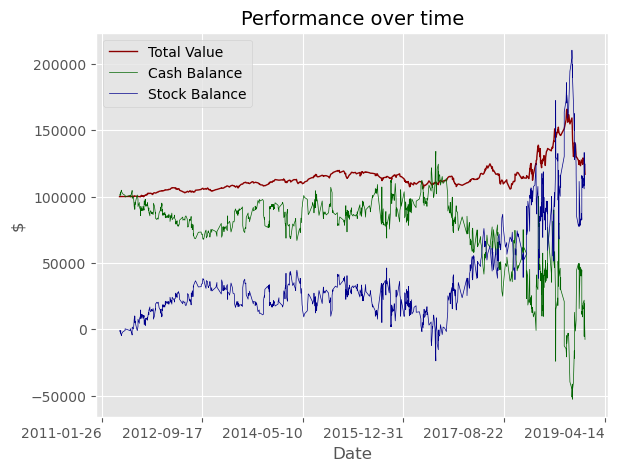

<Figure size 2000x1500 with 0 Axes>

In [120]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

plt.style.use('ggplot')

# Plot the data
plt.plot(data_df_port['date'], data_df_port['Total_value'], color='darkred', linewidth=1,label='Total Value')
plt.plot(data_df_port['date'], data_df_port['cash_balance'], color='darkgreen', linewidth=0.5,label='Cash Balance')
plt.plot(data_df_port['date'], data_df_port['portfolio'], color='darkblue', linewidth=0.5,label='Stock Balance')
# Add axis labels and title
plt.title('Performance over time', fontsize=14)
plt.ylabel('$', fontsize=12)
plt.xlabel('Date', fontsize=12)

# Format the x-axis labels
plt.xticks(rotation=0, ha='right')
plt.gca().xaxis.set_major_locator(MaxNLocator(6))
                                            
# Add gridlines and legend
plt.legend(loc='best', fontsize=10)

# Adjust plot margins and size
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.2)
plt.figure(figsize=(20, 15))

# Display the plot
plt.show()

In [121]:
trade_df2 = data_df[['ticker','headline_without_stopwords','sentiment_lex','eventRet','Close','date']]

In [122]:
trade_df2

ticker                         headline_without_stopwords  sentiment_lex  \
0      AMZN  whole foods ( wfmi ) -5.2 % following downgrad...         0.2996   
1      NFLX  netflix ( nflx +1.1 % ) shares post early gain...         0.8669   
2      MSFT  likely winners microsoft 's ( msft -1.4 % ) sk...         0.6435   
3      MSFT  microsoft ( msft -1.2 % ) skype signed deal la...         0.7413   
4      AMZN  amazon.com ( amzn -1.7 % ) shares slip comment...        -0.3100   
...     ...                                                ...            ...   
2630   TSLA  morgan stanley sees rally tesla ( nasdaq : tsl...         0.3019   
2631   TSLA  responding comment twitter , elon musk weekend...         0.6790   
2632   AMZN  amazon ( nasdaq : amzn ) among companies sec p...         0.4361   
2633   AAPL  chinese companies urge employees boycott ( nas...        -0.5884   
2634   TSLA  elon musk tweets tesla 's ( nasdaq : tsla ) su...         0.6362   

      eventRet      Close        date  
0     0.017650  10.059500  2011-05-02  
1    -0.012912  33.884285  2011-05-02  
2    -0.019817  20.120020  2011-05-10  
3    -0.019817  20.120020  2011-05-10  
4    -0.006607  10.303500  2011-05-12  
...        ...        ...         ...  
2630 -0.092015  22.468666  2018-12-18  
2631  0.041608  19.692667  2018-12-24  
2632  0.013062  67.197998  2018-12-24  
2633  0.005652  35.375175  2018-12-24  
2634 -0.002856  21.739332  2018-12-26  

[2635 rows x 6 columns]

In [123]:
# sort the trade_df by ticker and date
trade_df2 = trade_df2.sort_values(['ticker', 'date'])

# initialize a dictionary to store the previous sentiment scores for each ticker
prev_sentiments = {}

# loop through each row in the trade_df dataframe
for i, row in trade_df2.iterrows():
    # get the ticker and sentiment score for this row
    ticker = row['ticker']
    sentiment = row['sentiment_lex']
    
    # get the previous sentiment score for this ticker
    prev_sentiment = prev_sentiments.get(ticker, None)
    
    # if there is a previous sentiment score for this ticker, calculate the difference
    if prev_sentiment is not None:
        sentiment_diff = sentiment - prev_sentiment
    else:
        sentiment_diff = None
        
    # store the current sentiment score as the previous sentiment score for the next iteration
    prev_sentiments[ticker] = sentiment
    
    # update the 'sentiment_diff' column in the trade_df dataframe
    trade_df2.at[i, 'sentiment_diff'] = sentiment_diff


In [124]:
trade_df2.head(50)

ticker                         headline_without_stopwords  sentiment_lex  \
20    AAPL  despite wave analyst love regarding yesterday ...        -0.1439   
21    AAPL  bill ackman 's hedge fund made ~$490 one day ,...         0.5653   
26    AAPL  apple ( aapl -1.5 % ) shares continue perplexi...         0.8929   
45    AAPL  lagging months , tech bellwethers apple ( aapl...         0.6020   
55    AAPL  looking " refresh virtually every product line...         0.9509   
65    AAPL  additional details apple 's ( nasdaq : aapl ) ...         0.9146   
70    AAPL  estimates price targets predictably rising fol...         0.9255   
71    AAPL  apple 's ( nasdaq : aapl ) earnings prowess sp...         0.8930   
89    AAPL  apple ( aapl +1 % ) shares gain piper jaffray ...         0.9351   
98    AAPL  apple ( aapl +3.6 % ) passes exxon mobil ( xom...         0.5842   
100   AAPL  tech stocks bounce back , pushing nasdaq ahead...         0.5566   
116   AAPL  jobs resigns aapl ceo post : 's next investors...         0.9619   
117   AAPL  let us get real : long run , apple ( aapl -1.6...         0.8380   
118   AAPL  apple ( nasdaq : aapl ) 1.6 % wake steve jobs ...         0.5720   
119   AAPL  u.s. stock index futures rebounded best level ...         0.9091   
120   AAPL  apple ( aapl +2.6 % ) shares rallied today ful...         0.0301   
140   AAPL  apple ( aapl +2 % ) outperforming strongly tod...         0.9032   
149   AAPL  u.s. shares higher across board , nasdaq - 1.7...         0.4719   
150   AAPL  many apple 's ( nasdaq : aapl ) key chip suppl...         0.6380   
151   AAPL  apple ( aapl -3.1 % ) takes nasdaq lower follo...         0.6684   
152   AAPL  apple ( aapl -2.3 % ) drops following j.p. mor...         0.8156   
164   AAPL  apple ( aapl -4.5 % ) selling harder following...         0.8717   
165   AAPL  rumored , apple ( aapl -2.2 % ) offer 64 gb ip...         0.5978   
166   AAPL  disappointing reaction new iphone sinking appl...        -0.5630   
167   AAPL  shares pandora 12 % today , losing traction ea...         0.2826   
168   AAPL  apple ( aapl -1.8 % ) introduces iphone 4s , "...         0.9410   
169   AAPL  wells fargo 's jennifer fritsche says ( video ...         0.9451   
172   AAPL  different take yesterday 's jaw - dropping tur...         0.5315   
176   AAPL                                             " ok ,         0.2960   
188   AAPL  ifixit 's teardown iphone 4s ( nasdaq : aapl )...         0.8051   
194   AAPL  isi group initiates coverage hardware data net...         0.9335   
198   AAPL  several iphone component suppliers taking hit ...         0.7325   
199   AAPL  eric savitz 's advice everyone shocked apple '...         0.9066   
200   AAPL  mentioned apple 's ( nasdaq : aapl ) fq4 call ...         0.6890   
201   AAPL  apple 's ( nasdaq : aapl ) fq4 : $ 5.4b cash g...         0.8649   
202   AAPL  apple 's ( nasdaq : aapl ) fq4 results : 17.1 ...         0.4059   
203   AAPL  apple ( nasdaq : aapl ): fq4 eps $ 7.05 misses...        -0.3204   
204   AAPL  pros follow apple ( aapl -5 % ) sanguine earni...         0.7883   
206   AAPL  though analysts defending apple ( nasdaq : aap...         0.9400   
208   AAPL  perhaps still hungover rare earnings miss , ap...         0.8904   
222   AAPL  apple ( aapl +0.8 % ) outperforming r.w. baird...         0.9385   
233   AAPL  rumors cuts iphone ipad ( aapl -2.7 % ) produc...         0.4519   
234   AAPL  apple ( aapl -2.3 % ) continues moving lower (...         0.4394   
235   AAPL  technicians keeping close eye apple ( aapl -1....         0.8531   
236   AAPL  apple ( aapl -1.4 % ) sold 5 - week low , bear...        -0.6590   
266   AAPL  apple 's ( nasdaq : aapl ) reported interest a...         0.8797   
275   AAPL  apple ( aapl +2.9 % ) rises patent victory , w...         0.9118   
279   AAPL  week good apple ( aapl +1.2 % ) , closed back ...         0.1735   
311   AAPL  apple ( nasdaq : aapl ): fq1 gross margin 44.7...        -0.1461   
312 

In [125]:
trade_df2 = trade_df2.sort_values('date', ascending=True)

In [126]:
trade_df2.head(50)

ticker                         headline_without_stopwords  sentiment_lex  \
0    AMZN  whole foods ( wfmi ) -5.2 % following downgrad...         0.2996   
1    NFLX  netflix ( nflx +1.1 % ) shares post early gain...         0.8669   
2    MSFT  likely winners microsoft 's ( msft -1.4 % ) sk...         0.6435   
3    MSFT  microsoft ( msft -1.2 % ) skype signed deal la...         0.7413   
4    AMZN  amazon.com ( amzn -1.7 % ) shares slip comment...        -0.3100   
5    GOOG  's time coming , google ( goog -1.9 % ) makes ...         0.1561   
6      BA  " big win europe , " wto partly overturns ruli...         0.3399   
11   MSFT  linkedin ( lnkd ) astonishing start ipo debut ...         0.1114   
8    MSFT  bought linkedin ( lnkd , legging higher , +155...         0.7440   
7    MSFT  accusing underwriters digging late 1990s playb...        -0.5820   
9    MSFT  jens heycke , top 5 things could buy $ 4b ( um...         0.3941   
10   MSFT  " ok . almost hilarious . p / e ratio $ lnkd r...         0.8579   
14   MSFT  linkedin ( lnkd ) shares could fall 50 % , sug...        -0.3921   
12   AMZN  amazon ( amzn -1.2 % ) moves nicely low day fo...         0.5451   
13    JPM  investigation new york ag eric schneiderman mo...         0.7376   
15   NFLX  today 's strength netflix ( nflx +4.8 % ) attr...         0.6024   
16   TSLA  tesla motors ( tsla +3.6 % ) announces follow ...         0.7538   
17   GOOG  google ( nasdaq : goog ) taken " failed approa...         0.0700   
18   MSFT  phone industry blogger boy genius report cites...         0.7052   
19   TSLA  tesla motors ( tsla +6.3 % ) jumps premarket p...         0.8036   
20   AAPL  despite wave analyst love regarding yesterday ...        -0.1439   
21   AAPL  bill ackman 's hedge fund made ~$490 one day ,...         0.5653   
22   GOOG  google ( goog +1.4 % ) announces enhancements ...         0.8553   
23   GOOG  wireless spectrum u.s. limited - americans ' a...         0.6876   
24   GOOG  google ( goog -2.1 % ) shares slump nine - mon...         0.8198   
27    WMT  wal - mart ( wmt +1.1 % ) wins supreme court s...         0.9135   
26   AAPL  apple ( aapl -1.5 % ) shares continue perplexi...         0.8929   
25   AMZN  bmo raises whole foods ( wfm +3.5 % ) outperfo...         0.7220   
28    JPM  jpmorgan chase ( jpm +0.8 % ) settles sec $ 15...         0.6953   
29   GOOG  along turning negative motorola mobility ( nys...         0.7287   
30   GOOG  credit suisse downgrades motorola mobility ( m...         0.2435   
31   ADBE  despite earnings beat , adobe ( adbe -6.8 % ) ...         0.9081   
32   NFLX  netflix ( nflx +3.4 % ) ceo reed hastings jump...         0.7051   
34   AMZN  amazon ( nasdaq : amzn ) +1.1 % premarket , ch...         0.7224   
33   AMZN  amazon ( amzn +4.2 % ) tops s&p leader board m...         0.9814   
36   MSFT  linkedin ( lnkd ) initiated buy ubs , $ 90 pri...         0.5640   
35   GOOG  motorola mobility ( mmi -3.5 % ) continues sev...         0.5399   
38   GOOG  canaccord 's heath terry one - upping evercore...         0.8654   
40   GOOG  evercore 's ken sena upgrading google ( goog +...         0.8351   
37   NFLX  reasons netflix ( nflx +7.9 % ) could profit l...         0.8026   
39   NFLX  dawson james boldly initiates coverage netflix...         0.8075   
41   NFLX  netflix ( nasdaq : nflx ) +3.2 % premarket con...         0.6793   
42   MSFT  microsoft ( nasdaq : msft ) signs deal grow pr...         0.8009   
43   NFLX  ? netflix ( nflx -0.8 % ) downgrade ? merriman...         0.5828   
44    JPM  new york appeals court dismissed rico lawsuit ...         0.6950   
45   AAPL  lagging months , tech bellwethers apple ( aapl...         0.6020   
46    JPM                               quite boo - boo : ny         0.2015   
47   GOOG  morgan stanley downgrading google ( goog -1.4 ...         0.6850   
48    JPM  " cheap " bank stocks ( xlf -2.3 % ) keep gett...        -0.0649   
49   NFLX  firms worry competition , goldman lifting 

In [127]:
trade_df2['sentiment_diff'] = trade_df2['sentiment_diff'].fillna(0)

In [128]:
trade_df2['number_of_shares'] = 0

Assigning a buy signal if the sentiment score difference is more than 0.5 and a sell signal if the sentinent score difference is less than -0.5

In [129]:
trade_df2.loc[trade_df2['sentiment_diff'] > 0.5, 'number_of_shares'] = 1
trade_df2.loc[trade_df2['sentiment_diff'] < -0.5, 'number_of_shares'] = -1

In [130]:
trade_df2.head(50)

ticker                         headline_without_stopwords  sentiment_lex  \
0    AMZN  whole foods ( wfmi ) -5.2 % following downgrad...         0.2996   
1    NFLX  netflix ( nflx +1.1 % ) shares post early gain...         0.8669   
2    MSFT  likely winners microsoft 's ( msft -1.4 % ) sk...         0.6435   
3    MSFT  microsoft ( msft -1.2 % ) skype signed deal la...         0.7413   
4    AMZN  amazon.com ( amzn -1.7 % ) shares slip comment...        -0.3100   
5    GOOG  's time coming , google ( goog -1.9 % ) makes ...         0.1561   
6      BA  " big win europe , " wto partly overturns ruli...         0.3399   
11   MSFT  linkedin ( lnkd ) astonishing start ipo debut ...         0.1114   
8    MSFT  bought linkedin ( lnkd , legging higher , +155...         0.7440   
7    MSFT  accusing underwriters digging late 1990s playb...        -0.5820   
9    MSFT  jens heycke , top 5 things could buy $ 4b ( um...         0.3941   
10   MSFT  " ok . almost hilarious . p / e ratio $ lnkd r...         0.8579   
14   MSFT  linkedin ( lnkd ) shares could fall 50 % , sug...        -0.3921   
12   AMZN  amazon ( amzn -1.2 % ) moves nicely low day fo...         0.5451   
13    JPM  investigation new york ag eric schneiderman mo...         0.7376   
15   NFLX  today 's strength netflix ( nflx +4.8 % ) attr...         0.6024   
16   TSLA  tesla motors ( tsla +3.6 % ) announces follow ...         0.7538   
17   GOOG  google ( nasdaq : goog ) taken " failed approa...         0.0700   
18   MSFT  phone industry blogger boy genius report cites...         0.7052   
19   TSLA  tesla motors ( tsla +6.3 % ) jumps premarket p...         0.8036   
20   AAPL  despite wave analyst love regarding yesterday ...        -0.1439   
21   AAPL  bill ackman 's hedge fund made ~$490 one day ,...         0.5653   
22   GOOG  google ( goog +1.4 % ) announces enhancements ...         0.8553   
23   GOOG  wireless spectrum u.s. limited - americans ' a...         0.6876   
24   GOOG  google ( goog -2.1 % ) shares slump nine - mon...         0.8198   
27    WMT  wal - mart ( wmt +1.1 % ) wins supreme court s...         0.9135   
26   AAPL  apple ( aapl -1.5 % ) shares continue perplexi...         0.8929   
25   AMZN  bmo raises whole foods ( wfm +3.5 % ) outperfo...         0.7220   
28    JPM  jpmorgan chase ( jpm +0.8 % ) settles sec $ 15...         0.6953   
29   GOOG  along turning negative motorola mobility ( nys...         0.7287   
30   GOOG  credit suisse downgrades motorola mobility ( m...         0.2435   
31   ADBE  despite earnings beat , adobe ( adbe -6.8 % ) ...         0.9081   
32   NFLX  netflix ( nflx +3.4 % ) ceo reed hastings jump...         0.7051   
34   AMZN  amazon ( nasdaq : amzn ) +1.1 % premarket , ch...         0.7224   
33   AMZN  amazon ( amzn +4.2 % ) tops s&p leader board m...         0.9814   
36   MSFT  linkedin ( lnkd ) initiated buy ubs , $ 90 pri...         0.5640   
35   GOOG  motorola mobility ( mmi -3.5 % ) continues sev...         0.5399   
38   GOOG  canaccord 's heath terry one - upping evercore...         0.8654   
40   GOOG  evercore 's ken sena upgrading google ( goog +...         0.8351   
37   NFLX  reasons netflix ( nflx +7.9 % ) could profit l...         0.8026   
39   NFLX  dawson james boldly initiates coverage netflix...         0.8075   
41   NFLX  netflix ( nasdaq : nflx ) +3.2 % premarket con...         0.6793   
42   MSFT  microsoft ( nasdaq : msft ) signs deal grow pr...         0.8009   
43   NFLX  ? netflix ( nflx -0.8 % ) downgrade ? merriman...         0.5828   
44    JPM  new york appeals court dismissed rico lawsuit ...         0.6950   
45   AAPL  lagging months , tech bellwethers apple ( aapl...         0.6020   
46    JPM                               quite boo - boo : ny         0.2015   
47   GOOG  morgan stanley downgrading google ( goog -1.4 ...         0.6850   
48    JPM  " cheap " bank stocks ( xlf -2.3 % ) keep gett...        -0.0649   
49   NFLX  firms worry competition , goldman lifting 

In [131]:
non_null_df2 = trade_df2[trade_df2['number_of_shares'].notnull()]
non_null_df2 = trade_df2.loc[trade_df2['number_of_shares'] != 0]

In [132]:
non_null_df2

ticker                         headline_without_stopwords  sentiment_lex  \
4      AMZN  amazon.com ( amzn -1.7 % ) shares slip comment...        -0.3100   
11     MSFT  linkedin ( lnkd ) astonishing start ipo debut ...         0.1114   
8      MSFT  bought linkedin ( lnkd , legging higher , +155...         0.7440   
7      MSFT  accusing underwriters digging late 1990s playb...        -0.5820   
14     MSFT  linkedin ( lnkd ) shares could fall 50 % , sug...        -0.3921   
...     ...                                                ...            ...   
2622   TSLA  wired magazine posts deep dive tesla 's ( nasd...        -0.4755   
2623   TSLA  robert w. baird lifts price target tesla ( nas...         0.5384   
2618   ADBE  adobe ( nasdaq : adbe ) shares   gain 0.4 %   ...         0.6399   
2619   ADBE  adobe systems ( nasdaq : adbe ): q4 non - gaap...        -0.4452   
2628   NFLX  bernstein analyst   todd juenger maintains out...         0.5084   

      eventRet       Close        date  sentiment_diff  number_of_shares  
4    -0.006607   10.303500  2011-05-12         -0.6096                -1  
11   -0.001156   19.502411  2011-05-19         -0.7465                -1  
8    -0.001156   19.502411  2011-05-19          1.3260                 1  
7    -0.001156   19.502411  2011-05-19         -1.3233                -1  
14   -0.023198   19.068502  2011-05-23         -0.5035                -1  
...        ...         ...         ...             ...               ...  
2622 -0.002047   25.119333  2018-12-13         -1.2514                -1  
2623 -0.002047   25.119333  2018-12-13          1.0139                 1  
2618 -0.061720  248.080002  2018-12-13          0.6136                 1  
2619 -0.061720  248.080002  2018-12-13         -1.0851                -1  
2628  0.000443  270.940002  2018-12-18          0.7291                 1  

[955 rows x 8 columns]

We use a 80% of the data to train our model and the rest of the 20% is used to test our strategy

In [133]:
import pandas as pd
from sklearn.model_selection import train_test_split


# Sort your data based on the chronological order of the observations
data = non_null_df2.sort_values('date')

# Define the proportion of the data to be used for testing
test_size = 0.2

# Calculate the index of the split between training and testing data
split_index = int(len(data) * (1 - test_size))

# Split the data into training and testing datasets
train_data = data[:split_index]
test_data = data[split_index:]

# Use the train_data and test_data for your modeling tasks

In [134]:
train_data.tail(10)

ticker                         headline_without_stopwords  sentiment_lex  \
1940   TSLA  tesla ( nasdaq : tsla ): q2 eps -$1.33 beats $...        -0.4215   
1941   GOOG  live google , dip google ? day moving higher b...         0.9423   
1942   NFLX  netflix ( nasdaq : nflx ) 2.57 % investors dig...         0.7288   
1944   AAPL           cnbc reports apple ( nasdaq : aapl ) ...         0.7556   
1947    WMT  wal - mart ( nyse : wmt ) reports comparable s...         0.2874   
1952   NFLX  disney , worries netflix says bernstein backin...        -0.5357   
1955   TSLA  morgan stanley takes deep dive impact tesla ( ...         0.5846   
1957    WMT  target lower 3 %   announcing price cuts thous...        -0.5128   
1978   NFLX  wells fargo jumps netflix ( nasdaq : nflx ) ba...         0.7689   
1979   TSLA  tesla ( tsla -1.7 % ) lower pace model 3 produ...        -0.5486   

      eventRet       Close        date  sentiment_diff  number_of_shares  
1940  0.072772   21.726000  2017-08-02         -1.2393                -1  
1941 -0.001069   46.397999  2017-08-04          0.5237                 1  
1942 -0.068619  175.779999  2017-08-09          0.5082                 1  
1944  0.039904   37.806492  2017-08-14          1.0672                 1  
1947 -0.018099   72.058983  2017-08-17         -0.5641                -1  
1952  0.045059  174.690002  2017-08-30         -1.2645                -1  
1955 -0.017391   23.374001  2017-09-07          0.5347                 1  
1957 -0.012442   71.317596  2017-09-08         -0.8002                -1  
1978  0.012108  181.970001  2017-09-27          1.3046                 1  
1979  0.040348   23.209333  2017-10-03         -1.0292                -1

In [135]:
test_data.head(10)

ticker                         headline_without_stopwords  sentiment_lex  \
1984   AMZN           amazon ( nasdaq : amzn ) announces ge...         0.3551   
1985    WMT  wal - mart ( nyse : wmt ) 4.35 % company 's ag...         0.7316   
1988   NFLX  netflix ( nasdaq : nflx ): q3 eps $ 0.29 misse...        -0.5719   
1990   AAPL           keybanc upgrades apple ( nasdaq : aap...        -0.2294   
1991   MSFT           saint regis mohawk tribe suing micros...        -0.4134   
1995   TSLA  tesla ( nasdaq : tsla ) could face hurdles str...         0.8556   
2000   GOOG  alphabet ( nasdaq : goog ): q3 eps $ 9.57 beat...        -0.4215   
2001   AMZN  amazon ( nasdaq : amzn ): q3 eps $ 0.52 beats ...        -0.2732   
2003   GOOG  facebook ( fb +4.3 % ) , twitter ( twtr +6.8 %...         0.3966   
2007   TSLA  tesla ( nasdaq : tsla ) -2.4 % premarket everc...         0.4472   

      eventRet       Close        date  sentiment_diff  number_of_shares  
1984  0.026276   49.479000  2017-10-06         -0.5329                -1  
1985  0.083089   76.064262  2017-10-10          1.2444                 1  
1988  0.018736  202.679993  2017-10-16         -0.8444                -1  
1990  0.028445   37.813583  2017-10-16         -0.5553                -1  
1991  0.003351   72.539581  2017-10-18         -0.7434                -1  
1995 -0.041537   22.468000  2017-10-23          1.4042                 1  
2000  0.050111   48.627998  2017-10-26         -1.0017                -1  
2001  0.128607   48.621498  2017-10-26         -0.7560                -1  
2003  0.045118   50.963501  2017-10-27          0.8181                 1  
2007 -0.017699   21.391333  2017-10-27          0.8486                 1

In [136]:
# word-embedding
X_train = pd.np.array([pd.np.array([token.vector for token in nlp(s)]).mean(axis=0)*pd.np.ones((300)) \
                           for s in train_data['headline_without_stopwords']])

In [137]:
X_test = pd.np.array([pd.np.array([token.vector for token in nlp(s)]).mean(axis=0)*pd.np.ones((300)) \
                           for s in test_data['headline_without_stopwords']])

In [138]:
# split out validation dataset for the end
Y_train= train_data["number_of_shares"]
Y_test=test_data["number_of_shares"]


from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
#seed = 7
#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=validation_size, random_state=seed)

# test options for classification
num_folds = 10
seed = 7
scoring = 'accuracy'

# spot check the algorithms
models = []
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('SVM', SVC()))
#Neural Network
models.append(('NN', MLPClassifier()))
#Ensemble Models 
models.append(('RF', RandomForestClassifier()))

In [139]:
results = []
names = []
kfold_results = []
test_results = []
train_results = []
for name, model in models:

    kfold = KFold(n_splits=num_folds)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    #msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    #print(msg)
   # Full Training period
    res = model.fit(X_train, Y_train)
    train_result = accuracy_score(res.predict(X_train), Y_train)
    train_results.append(train_result)
    
    # Test results
    test_result = accuracy_score(res.predict(X_test), Y_test)
    test_results.append(test_result)    
    
    msg = "%s: %f (%f) %f %f" % (name, cv_results.mean(), cv_results.std(), train_result, test_result)
    print(msg)
    print(confusion_matrix(res.predict(X_test), Y_test))
    print(classification_report(res.predict(X_test), Y_test))

LR: 0.742242 (0.038497) 0.930628 0.638743
[[56 32]
 [37 66]]
              precision    recall  f1-score   support

          -1       0.60      0.64      0.62        88
           1       0.67      0.64      0.66       103

    accuracy                           0.64       191
   macro avg       0.64      0.64      0.64       191
weighted avg       0.64      0.64      0.64       191

KNN: 0.655878 (0.072951) 0.782723 0.602094
[[47 30]
 [46 68]]
              precision    recall  f1-score   support

          -1       0.51      0.61      0.55        77
           1       0.69      0.60      0.64       114

    accuracy                           0.60       191
   macro avg       0.60      0.60      0.60       191
weighted avg       0.62      0.60      0.61       191

CART: 0.587748 (0.041424) 1.000000 0.528796
[[50 47]
 [43 51]]
              precision    recall  f1-score   support

          -1       0.54      0.52      0.53        97
           1       0.52      0.54      0.53        

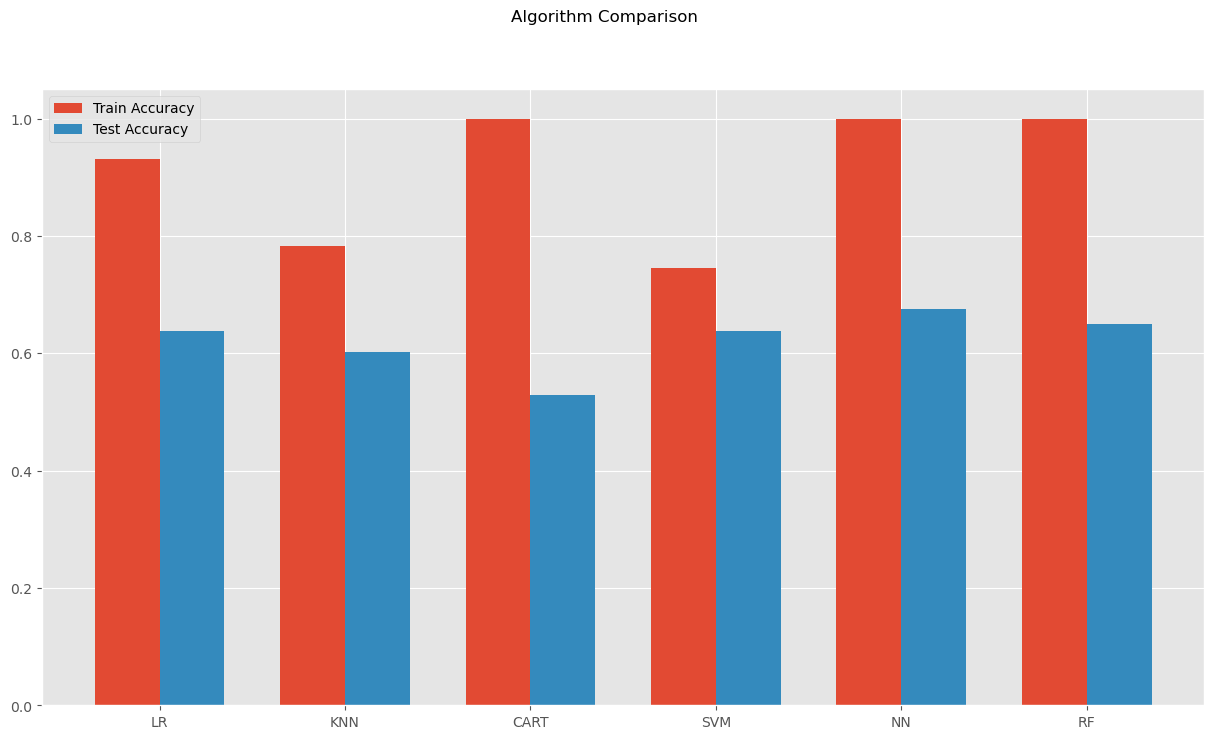

In [140]:
# compare algorithms
from matplotlib import pyplot
fig = pyplot.figure()
ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results,  width=width, label='Train Accuracy')
pyplot.bar(ind + width/2, test_results, width=width, label='Test Accuracy')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.show()

In [141]:
X_test

array([[-2.10381055, -2.11198282,  3.44555402, ..., -1.52259243,
         1.36519754, -0.08284382],
       [-1.42561507, -0.87021589, -1.60120165, ..., -0.81204534,
         0.78377587,  1.3085146 ],
       [-1.50809753, -2.35886979, -2.69125605, ..., -1.22966862,
         0.74134719,  1.31593525],
       ...,
       [ 0.10260438, -0.97314811,  0.7885862 , ..., -1.67354763,
         0.01549758, -0.14402919],
       [-0.86039126, -0.91444385, -2.11903358, ..., -0.72595078,
         0.1028791 ,  1.7513082 ],
       [-1.54906404, -1.96442449, -2.23421669, ..., -1.17286086,
         1.2615701 ,  2.03168535]])

In [142]:
nn = MLPClassifier()

# Fit the model on the entire training dataset
nn.fit(X_train,Y_train)

# Use the trained model to make predictions on the test dataset
Y_predict = nn.predict(X_test)

# Evaluate the performance of the model on the test dataset
accuracy = accuracy_score(Y_test, Y_predict)
print('Test Accuracy: %.3f' % accuracy)


Test Accuracy: 0.686


In [143]:
test_data["Predicted"]=Y_predict

In [144]:
test_data

ticker                         headline_without_stopwords  sentiment_lex  \
1984   AMZN           amazon ( nasdaq : amzn ) announces ge...         0.3551   
1985    WMT  wal - mart ( nyse : wmt ) 4.35 % company 's ag...         0.7316   
1988   NFLX  netflix ( nasdaq : nflx ): q3 eps $ 0.29 misse...        -0.5719   
1990   AAPL           keybanc upgrades apple ( nasdaq : aap...        -0.2294   
1991   MSFT           saint regis mohawk tribe suing micros...        -0.4134   
...     ...                                                ...            ...   
2618   ADBE  adobe ( nasdaq : adbe ) shares   gain 0.4 %   ...         0.6399   
2619   ADBE  adobe systems ( nasdaq : adbe ): q4 non - gaap...        -0.4452   
2622   TSLA  wired magazine posts deep dive tesla 's ( nasd...        -0.4755   
2623   TSLA  robert w. baird lifts price target tesla ( nas...         0.5384   
2628   NFLX  bernstein analyst   todd juenger maintains out...         0.5084   

      eventRet       Close        date  sentiment_diff  number_of_shares  \
1984  0.026276   49.479000  2017-10-06         -0.5329                -1   
1985  0.083089   76.064262  2017-10-10          1.2444                 1   
1988  0.018736  202.679993  2017-10-16         -0.8444                -1   
1990  0.028445   37.813583  2017-10-16         -0.5553                -1   
1991  0.003351   72.539581  2017-10-18         -0.7434                -1   
...        ...         ...         ...             ...               ...   
2618 -0.061720  248.080002  2018-12-13          0.6136                 1   
2619 -0.061720  248.080002  2018-12-13         -1.0851                -1   
2622 -0.002047   25.119333  2018-12-13         -1.2514                -1   
2623 -0.002047   25.119333  2018-12-13          1.0139                 1   
2628  0.000443  270.940002  2018-12-18          0.7291                 1   

      Predicted  
1984         -1  
1985          1  
1988         -1  
1990         -1  
1991          1  
...         ...  
2618         -1  
2619         -1  
2622         -1  
2623          1  
2628         -1  

[191 rows x 9 columns]

In [145]:
import pandas as pd


# Create an empty dictionary to store the current position for each ticker
positions = {}
#positions_list = []
cash_balance=[]
# Initialize the starting value of the portfolio
cash = 100000
value=0
# Loop through the rows of the DataFrame
index=1
for index, row in test_data.iterrows():
    # Check if this is the first time we've seen this ticker
    if row['ticker'] not in positions:
        # If it is, initialize the position to 0
        positions[row['ticker']] = 0
        
    # Check if we need to buy or sell this ticker
    if row['Predicted'] == 1:
        # If we need to buy, calculate the total value to invest
        positions[row['ticker']] += 100
        cash += -100 * row['Close'] 
        cash_balance.append(cash) 
    elif row['Predicted'] == -1:
        # If we need to sell, calculate the total value of the current position
        positions[row['ticker']] -= 100
        cash += 100 * row['Close']
        cash_balance.append(cash) 
    # Print out the portfolio position for each ticker at the end of each day
    print(f"End of day {row['date']}: {positions}")
    
    # Print out the portfolio value at the end of each day
    print(f"Cash value: {cash}")
    #positions_list.append(positions)
    
print(f"Final cash value: {cash}")




End of day 2017-10-06: {'AMZN': -100}
Cash value: 104947.90000915527
End of day 2017-10-10: {'AMZN': -100, 'WMT': 100}
Cash value: 97341.4737701416
End of day 2017-10-16: {'AMZN': -100, 'WMT': 100, 'NFLX': -100}
Cash value: 117609.47303771973
End of day 2017-10-16: {'AMZN': -100, 'WMT': 100, 'NFLX': -100, 'AAPL': -100}
Cash value: 121390.83137512207
End of day 2017-10-18: {'AMZN': -100, 'WMT': 100, 'NFLX': -100, 'AAPL': -100, 'MSFT': 100}
Cash value: 114136.87324523926
End of day 2017-10-23: {'AMZN': -100, 'WMT': 100, 'NFLX': -100, 'AAPL': -100, 'MSFT': 100, 'TSLA': 100}
Cash value: 111890.07320404053
End of day 2017-10-26: {'AMZN': -100, 'WMT': 100, 'NFLX': -100, 'AAPL': -100, 'MSFT': 100, 'TSLA': 100, 'GOOG': -100}
Cash value: 116752.8730392456
End of day 2017-10-26: {'AMZN': -200, 'WMT': 100, 'NFLX': -100, 'AAPL': -100, 'MSFT': 100, 'TSLA': 100, 'GOOG': -100}
Cash value: 121615.02285003662
End of day 2017-10-27: {'AMZN': -200, 'WMT': 100, 'NFLX': -100, 'AAPL': -100, 'MSFT': 100, 'TS

In [146]:
test_data["cash_balance"]=cash_balance

In [147]:
test_data

ticker                         headline_without_stopwords  sentiment_lex  \
1984   AMZN           amazon ( nasdaq : amzn ) announces ge...         0.3551   
1985    WMT  wal - mart ( nyse : wmt ) 4.35 % company 's ag...         0.7316   
1988   NFLX  netflix ( nasdaq : nflx ): q3 eps $ 0.29 misse...        -0.5719   
1990   AAPL           keybanc upgrades apple ( nasdaq : aap...        -0.2294   
1991   MSFT           saint regis mohawk tribe suing micros...        -0.4134   
...     ...                                                ...            ...   
2618   ADBE  adobe ( nasdaq : adbe ) shares   gain 0.4 %   ...         0.6399   
2619   ADBE  adobe systems ( nasdaq : adbe ): q4 non - gaap...        -0.4452   
2622   TSLA  wired magazine posts deep dive tesla 's ( nasd...        -0.4755   
2623   TSLA  robert w. baird lifts price target tesla ( nas...         0.5384   
2628   NFLX  bernstein analyst   todd juenger maintains out...         0.5084   

      eventRet       Close        date  sentiment_diff  number_of_shares  \
1984  0.026276   49.479000  2017-10-06         -0.5329                -1   
1985  0.083089   76.064262  2017-10-10          1.2444                 1   
1988  0.018736  202.679993  2017-10-16         -0.8444                -1   
1990  0.028445   37.813583  2017-10-16         -0.5553                -1   
1991  0.003351   72.539581  2017-10-18         -0.7434                -1   
...        ...         ...         ...             ...               ...   
2618 -0.061720  248.080002  2018-12-13          0.6136                 1   
2619 -0.061720  248.080002  2018-12-13         -1.0851                -1   
2622 -0.002047   25.119333  2018-12-13         -1.2514                -1   
2623 -0.002047   25.119333  2018-12-13          1.0139                 1   
2628  0.000443  270.940002  2018-12-18          0.7291                 1   

      Predicted   cash_balance  
1984         -1  104947.900009  
1985          1   97341.473770  
1988         -1  117609.473038  
1990         -1  121390.831375  
1991          1  114136.873245  
...         ...            ...  
2618         -1  296835.581779  
2619         -1  321643.581963  
2622         -1  324155.515289  
2623          1  321643.581963  
2628         -1  348737.582207  

[191 rows x 10 columns]

In [148]:
import pandas as pd

portfolio3 = {}
cash = 100000
positions_list3 = []

for index, row in test_data.iterrows():
    # Check if this is the first time we've seen this ticker
    if row['ticker'] not in portfolio3:
        portfolio3[row['ticker']] = 0
        
    # Check if we need to buy or sell this ticker
    if row['Predicted'] == 1:
        # If we need to buy, calculate the total value to invest
        portfolio3[row['ticker']] += 100
        cash += -100 * row['Close']
    elif row['Predicted'] == -1:
        # If we need to sell, calculate the total value of the current position
        portfolio3[row['ticker']] -= 100
        cash += 100 * row['Close']
    
    # Record the portfolio position for each ticker at the end of each day
    positions_list3.append({
        'date': row['date'],
        'portfolio': portfolio3.copy()
    })

In [149]:
pd_positions3 = pd.DataFrame(positions_list3)
pd_positions3

date                                          portfolio
0    2017-10-06                                     {'AMZN': -100}
1    2017-10-10                         {'AMZN': -100, 'WMT': 100}
2    2017-10-16           {'AMZN': -100, 'WMT': 100, 'NFLX': -100}
3    2017-10-16  {'AMZN': -100, 'WMT': 100, 'NFLX': -100, 'AAPL...
4    2017-10-18  {'AMZN': -100, 'WMT': 100, 'NFLX': -100, 'AAPL...
..          ...                                                ...
186  2018-12-13  {'AMZN': 300, 'WMT': 0, 'NFLX': -200, 'AAPL': ...
187  2018-12-13  {'AMZN': 300, 'WMT': 0, 'NFLX': -200, 'AAPL': ...
188  2018-12-13  {'AMZN': 300, 'WMT': 0, 'NFLX': -200, 'AAPL': ...
189  2018-12-13  {'AMZN': 300, 'WMT': 0, 'NFLX': -200, 'AAPL': ...
190  2018-12-18  {'AMZN': 300, 'WMT': 0, 'NFLX': -300, 'AAPL': ...

[191 rows x 2 columns]

In [150]:
import pandas as pd
from pandas import json_normalize

# Create example dataframe
Portfolio1 = pd_positions3

# Use json_normalize to create columns for each item in the dictionary
Portfolio1= pd.concat([Portfolio1.drop(['portfolio'], axis=1), json_normalize(Portfolio1['portfolio'])], axis=1)

# Print the resulting dataframe
Portfolio1

date  AMZN    WMT   NFLX   AAPL   MSFT   TSLA   GOOG   ADBE    JPM  \
0    2017-10-06  -100    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
1    2017-10-10  -100  100.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2    2017-10-16  -100  100.0 -100.0    NaN    NaN    NaN    NaN    NaN    NaN   
3    2017-10-16  -100  100.0 -100.0 -100.0    NaN    NaN    NaN    NaN    NaN   
4    2017-10-18  -100  100.0 -100.0 -100.0  100.0    NaN    NaN    NaN    NaN   
..          ...   ...    ...    ...    ...    ...    ...    ...    ...    ...   
186  2018-12-13   300    0.0 -200.0  400.0  600.0  200.0 -200.0 -500.0 -200.0   
187  2018-12-13   300    0.0 -200.0  400.0  600.0  200.0 -200.0 -600.0 -200.0   
188  2018-12-13   300    0.0 -200.0  400.0  600.0  100.0 -200.0 -600.0 -200.0   
189  2018-12-13   300    0.0 -200.0  400.0  600.0  200.0 -200.0 -600.0 -200.0   
190  2018-12-18   300    0.0 -300.0  400.0  600.0  200.0 -200.0 -600.0 -200.0   

        BA  
0      NaN  
1      NaN  
2      NaN  
3      NaN  
4      NaN  
..     ...  
186 -100.0  
187 -100.0  
188 -100.0  
189 -100.0  
190 -100.0  

[191 rows x 11 columns]

In [151]:
Portfolio1.fillna(0,inplace=True)

In [152]:
Portfolio1['date'] = pd.to_datetime(Portfolio1['date'])

In [153]:
pivot_df_ticker_return

date  AAPL_close  ADBE_close  AMZN_close    BA_close  GOOG_close  \
0    2010-01-04    6.505279   37.090000    6.695000   43.777550   15.610239   
1    2010-01-05    6.516526   37.700001    6.734500   45.211353   15.541497   
2    2010-01-06    6.412872   37.619999    6.612500   46.582798   15.149715   
3    2010-01-07    6.401018   36.889999    6.500000   48.468563   14.797037   
4    2010-01-08    6.443573   36.689999    6.676000   48.001015   14.994298   
...         ...         ...         ...         ...         ...         ...   
2258 2018-12-21   36.314793  208.800003   68.872498  295.930267   48.977001   
2259 2018-12-24   35.375175  205.160004   67.197998  285.834320   48.811001   
2260 2018-12-26   37.866348  222.949997   73.544998  305.044800   51.973000   
2261 2018-12-27   37.620609  225.139999   73.082001  308.163940   52.194000   
2262 2018-12-28   37.639874  223.130005   73.901001  307.425446   51.854000   

      JPM_close  MSFT_close  NFLX_close  TSLA_close  WMT_close  
0     30.517244   23.623898    7.640000         NaN  40.165062  
1     31.108364   23.631531    7.358571         NaN  39.765114  
2     31.279291   23.486500    7.617143         NaN  39.676243  
3     31.898901   23.242252    7.485714         NaN  39.698448  
4     31.820545   23.402548    7.614286         NaN  39.498489  
...         ...         ...         ...         ...        ...  
2258  82.719009   93.870903  246.389999   21.318001  81.071449  
2259  80.935837   89.952850  233.880005   19.692667  79.852539  
2260  84.291344   96.097496  253.669998   21.739332  84.123383  
2261  85.240005   96.689987  255.570007   21.075333  85.221336  
2262  85.055565   95.935059  256.079987   22.257999  85.723785  

[2263 rows x 11 columns]

In [154]:
combinedDataFrame2 = pd.merge(Portfolio1, pivot_df_ticker_return, how='left', left_on=['date'], right_on=['date'])
data_df_port2 = combinedDataFrame2[['date','AAPL','ADBE','AMZN','BA','GOOG','JPM','MSFT','NFLX','TSLA','WMT','AAPL_close','ADBE_close','AMZN_close','BA_close','GOOG_close','JPM_close','MSFT_close','NFLX_close','TSLA_close','WMT_close']]
data_df_port2

date   AAPL   ADBE  AMZN     BA   GOOG    JPM   MSFT   NFLX   TSLA  \
0   2017-10-06    0.0    0.0  -100    0.0    0.0    0.0    0.0    0.0    0.0   
1   2017-10-10    0.0    0.0  -100    0.0    0.0    0.0    0.0    0.0    0.0   
2   2017-10-16    0.0    0.0  -100    0.0    0.0    0.0    0.0 -100.0    0.0   
3   2017-10-16 -100.0    0.0  -100    0.0    0.0    0.0    0.0 -100.0    0.0   
4   2017-10-18 -100.0    0.0  -100    0.0    0.0    0.0  100.0 -100.0    0.0   
..         ...    ...    ...   ...    ...    ...    ...    ...    ...    ...   
186 2018-12-13  400.0 -500.0   300 -100.0 -200.0 -200.0  600.0 -200.0  200.0   
187 2018-12-13  400.0 -600.0   300 -100.0 -200.0 -200.0  600.0 -200.0  200.0   
188 2018-12-13  400.0 -600.0   300 -100.0 -200.0 -200.0  600.0 -200.0  100.0   
189 2018-12-13  400.0 -600.0   300 -100.0 -200.0 -200.0  600.0 -200.0  200.0   
190 2018-12-18  400.0 -600.0   300 -100.0 -200.0 -200.0  600.0 -300.0  200.0   

     ...  AAPL_close  ADBE_close  AMZN_close    BA_close  GOOG_close  \
0    ...   36.730354  151.119995   49.479000  245.107254   48.944500   
1    ...   36.872265  152.149994   49.360001  247.334839   48.630001   
2    ...   37.813583  150.460007   50.317001  246.216293   49.599998   
3    ...   37.813583  150.460007   50.317001  246.216293   49.599998   
4    ...   37.785198  153.000000   49.849998  246.491211   49.640499   
..   ...         ...         ...         ...         ...         ...   
186  ...   41.186317  248.080002   82.918999  316.258148   53.095001   
187  ...   41.186317  248.080002   82.918999  316.258148   53.095001   
188  ...   41.186317  248.080002   82.918999  316.258148   53.095001   
189  ...   41.186317  248.080002   82.918999  316.258148   53.095001   
190  ...   40.010597  226.179993   77.573997  318.774872   51.435501   

     JPM_close  MSFT_close  NFLX_close  TSLA_close  WMT_close  
0    83.227837   71.034775  198.020004   23.792000  71.426086  
1    83.408142   71.305840  195.080002   23.705999  76.064262  
2    84.017845   72.576950  202.679993   23.373333  77.519882  
3    84.017845   72.576950  202.679993   23.373333  77.519882  
4    84.146652   72.539581  195.539993   23.976667  77.953873  
..         ...         ...         ...         ...        ...  
186  88.823898  104.593010  276.019989   25.119333  86.496056  
187  88.823898  104.593010  276.019989   25.119333  86.496056  
188  88.823898  104.593010  276.019989   25.119333  86.496056  
189  88.823898  104.593010  276.019989   25.119333  86.496056  
190  86.557632   99.356194  270.940002   22.468666  84.746788  

[191 rows x 21 columns]

In [155]:
data_df_port2['portfolio'] = data_df_port2['AAPL'] * data_df_port2['AAPL_close'] + data_df_port2['ADBE'] * data_df_port2['ADBE_close'] + data_df_port2['AMZN'] * data_df_port2['AMZN_close'] + data_df_port2['BA'] * data_df_port2['BA_close'] + data_df_port2['GOOG'] * data_df_port2['GOOG_close'] + data_df_port2['JPM'] * data_df_port2['JPM_close'] + data_df_port2['MSFT'] * data_df_port2['MSFT_close'] + data_df_port2['NFLX'] * data_df_port2['NFLX_close'] + data_df_port2['TSLA'] * data_df_port2['TSLA_close'] + data_df_port2['WMT'] * data_df_port2['WMT_close']

In [156]:
data_df_port2

date   AAPL   ADBE  AMZN     BA   GOOG    JPM   MSFT   NFLX   TSLA  \
0   2017-10-06    0.0    0.0  -100    0.0    0.0    0.0    0.0    0.0    0.0   
1   2017-10-10    0.0    0.0  -100    0.0    0.0    0.0    0.0    0.0    0.0   
2   2017-10-16    0.0    0.0  -100    0.0    0.0    0.0    0.0 -100.0    0.0   
3   2017-10-16 -100.0    0.0  -100    0.0    0.0    0.0    0.0 -100.0    0.0   
4   2017-10-18 -100.0    0.0  -100    0.0    0.0    0.0  100.0 -100.0    0.0   
..         ...    ...    ...   ...    ...    ...    ...    ...    ...    ...   
186 2018-12-13  400.0 -500.0   300 -100.0 -200.0 -200.0  600.0 -200.0  200.0   
187 2018-12-13  400.0 -600.0   300 -100.0 -200.0 -200.0  600.0 -200.0  200.0   
188 2018-12-13  400.0 -600.0   300 -100.0 -200.0 -200.0  600.0 -200.0  100.0   
189 2018-12-13  400.0 -600.0   300 -100.0 -200.0 -200.0  600.0 -200.0  200.0   
190 2018-12-18  400.0 -600.0   300 -100.0 -200.0 -200.0  600.0 -300.0  200.0   

     ...  ADBE_close  AMZN_close    BA_close  GOOG_close  JPM_close  \
0    ...  151.119995   49.479000  245.107254   48.944500  83.227837   
1    ...  152.149994   49.360001  247.334839   48.630001  83.408142   
2    ...  150.460007   50.317001  246.216293   49.599998  84.017845   
3    ...  150.460007   50.317001  246.216293   49.599998  84.017845   
4    ...  153.000000   49.849998  246.491211   49.640499  84.146652   
..   ...         ...         ...         ...         ...        ...   
186  ...  248.080002   82.918999  316.258148   53.095001  88.823898   
187  ...  248.080002   82.918999  316.258148   53.095001  88.823898   
188  ...  248.080002   82.918999  316.258148   53.095001  88.823898   
189  ...  248.080002   82.918999  316.258148   53.095001  88.823898   
190  ...  226.179993   77.573997  318.774872   51.435501  86.557632   

     MSFT_close  NFLX_close  TSLA_close  WMT_close      portfolio  
0     71.034775  198.020004   23.792000  71.426086   -4947.900009  
1     71.305840  195.080002   23.705999  76.064262    2670.426178  
2     72.576950  202.679993   23.373333  77.519882  -17547.711182  
3     72.576950  202.679993   23.373333  77.519882  -21329.069519  
4     72.539581  195.539993   23.976667  77.953873  -13268.173599  
..          ...         ...         ...        ...            ...  
186  104.593010  276.019989   25.119333  86.496056 -130123.694229  
187  104.593010  276.019989   25.119333  86.496056 -154931.694412  
188  104.593010  276.019989   25.119333  86.496056 -157443.627739  
189  104.593010  276.019989   25.119333  86.496056 -154931.694412  
190   99.356194  270.940002   22.468666  84.746788 -173082.222748  

[191 rows x 22 columns]

In [157]:
data_df_port2['cash_balance']=cash_balance
data_df_port2['Total_value']=data_df_port2['cash_balance']+data_df_port2['portfolio']

In [158]:
data_df_port2

date   AAPL   ADBE  AMZN     BA   GOOG    JPM   MSFT   NFLX   TSLA  \
0   2017-10-06    0.0    0.0  -100    0.0    0.0    0.0    0.0    0.0    0.0   
1   2017-10-10    0.0    0.0  -100    0.0    0.0    0.0    0.0    0.0    0.0   
2   2017-10-16    0.0    0.0  -100    0.0    0.0    0.0    0.0 -100.0    0.0   
3   2017-10-16 -100.0    0.0  -100    0.0    0.0    0.0    0.0 -100.0    0.0   
4   2017-10-18 -100.0    0.0  -100    0.0    0.0    0.0  100.0 -100.0    0.0   
..         ...    ...    ...   ...    ...    ...    ...    ...    ...    ...   
186 2018-12-13  400.0 -500.0   300 -100.0 -200.0 -200.0  600.0 -200.0  200.0   
187 2018-12-13  400.0 -600.0   300 -100.0 -200.0 -200.0  600.0 -200.0  200.0   
188 2018-12-13  400.0 -600.0   300 -100.0 -200.0 -200.0  600.0 -200.0  100.0   
189 2018-12-13  400.0 -600.0   300 -100.0 -200.0 -200.0  600.0 -200.0  200.0   
190 2018-12-18  400.0 -600.0   300 -100.0 -200.0 -200.0  600.0 -300.0  200.0   

     ...    BA_close  GOOG_close  JPM_close  MSFT_close  NFLX_close  \
0    ...  245.107254   48.944500  83.227837   71.034775  198.020004   
1    ...  247.334839   48.630001  83.408142   71.305840  195.080002   
2    ...  246.216293   49.599998  84.017845   72.576950  202.679993   
3    ...  246.216293   49.599998  84.017845   72.576950  202.679993   
4    ...  246.491211   49.640499  84.146652   72.539581  195.539993   
..   ...         ...         ...        ...         ...         ...   
186  ...  316.258148   53.095001  88.823898  104.593010  276.019989   
187  ...  316.258148   53.095001  88.823898  104.593010  276.019989   
188  ...  316.258148   53.095001  88.823898  104.593010  276.019989   
189  ...  316.258148   53.095001  88.823898  104.593010  276.019989   
190  ...  318.774872   51.435501  86.557632   99.356194  270.940002   

     TSLA_close  WMT_close      portfolio   cash_balance    Total_value  
0     23.792000  71.426086   -4947.900009  104947.900009  100000.000000  
1     23.705999  76.064262    2670.426178   97341.473770  100011.899948  
2     23.373333  77.519882  -17547.711182  117609.473038  100061.761856  
3     23.373333  77.519882  -21329.069519  121390.831375  100061.761856  
4     23.976667  77.953873  -13268.173599  114136.873245  100868.699646  
..          ...        ...            ...            ...            ...  
186   25.119333  86.496056 -130123.694229  296835.581779  166711.887550  
187   25.119333  86.496056 -154931.694412  321643.581963  166711.887550  
188   25.119333  86.496056 -157443.627739  324155.515289  166711.887550  
189   25.119333  86.496056 -154931.694412  321643.581963  166711.887550  
190   22.468666  84.746788 -173082.222748  348737.582207  175655.359459  

[191 rows x 24 columns]

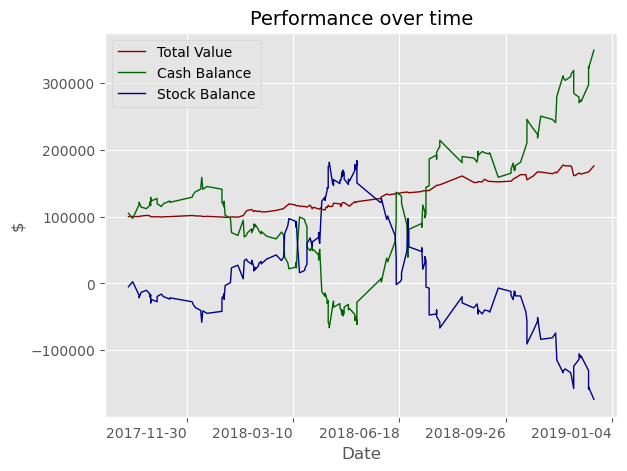

<Figure size 2000x1500 with 0 Axes>

In [159]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

plt.style.use('ggplot')

# Plot the data
plt.plot(data_df_port2['date'], data_df_port2['Total_value'], color='darkred', linewidth=1,label='Total Value')
plt.plot(data_df_port2['date'], data_df_port2['cash_balance'], color='darkgreen', linewidth=1,label='Cash Balance')
plt.plot(data_df_port2['date'], data_df_port2['portfolio'], color='darkblue', linewidth=1,label='Stock Balance')
# Add axis labels and title
plt.title('Performance over time', fontsize=14)
plt.ylabel('$', fontsize=12)
plt.xlabel('Date', fontsize=12)

# Format the x-axis labels
plt.xticks(rotation=0, ha='right')
plt.gca().xaxis.set_major_locator(MaxNLocator(6))
                                            
# Add gridlines and legend
plt.legend(loc='best', fontsize=10)

# Adjust plot margins and size
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.2)
plt.figure(figsize=(20, 15))

# Display the plot
plt.show()

Calculating the moving average over 15 days and deciding to buy or sell a stock depending upon the open price of the 15th day

In [160]:
# Calculate moving average and buy/sell signals
df_ticker_return['Ma'] = df_ticker_return.groupby('ticker')['Close'].rolling(15).mean().reset_index(0, drop=True)
df_ticker_return['signal'] = df_ticker_return.apply(lambda row: 'Buy' if row['Open'] > row['Ma'] else 'Sell', axis=1)
df_ticker_return['Buy_Sell'] = df_ticker_return.apply(lambda row: 1 if row['signal'] == 'Buy' else -1, axis=1)
df_ticker_return=df_ticker_return[(df_ticker_return.Date != '2010-01-04 00:00:00-05:00') & (df_ticker_return.Date != '2010-01-05 00:00:00-05:00')& (df_ticker_return.Date != '2010-01-06 00:00:00-05:00')& (df_ticker_return.Date != '2010-01-07 00:00:00-05:00')& (df_ticker_return.Date != '2010-01-08 00:00:00-05:00')& (df_ticker_return.Date != '2010-01-11 00:00:00-05:00')& (df_ticker_return.Date != '2010-01-12 00:00:00-05:00')& (df_ticker_return.Date != '2010-01-13 00:00:00-05:00')& (df_ticker_return.Date != '2010-01-14 00:00:00-05:00')& (df_ticker_return.Date != '2010-01-15 00:00:00-05:00')& (df_ticker_return.Date != '2010-01-19 00:00:00-05:00')& (df_ticker_return.Date != '2010-01-20 00:00:00-05:00')& (df_ticker_return.Date != '2010-01-21 00:00:00-05:00')& (df_ticker_return.Date != '2010-01-22 00:00:00-05:00')]
# Save data to CSV
df_ticker_return.to_csv('Data\Step2ZZ.2_ReturnData.csv', index=False)

In [161]:
df_ticker_return.tail(50)

Date        Open        High         Low  \
22458 2018-10-17 00:00:00-04:00  261.209991  261.890015  255.259995   
22459 2018-10-18 00:00:00-04:00  256.190002  257.209991  246.009995   
22460 2018-10-19 00:00:00-04:00  252.729996  252.889999  243.639999   
22461 2018-10-22 00:00:00-04:00  246.000000  251.639999  242.800003   
22462 2018-10-23 00:00:00-04:00  246.190002  254.910004  242.559998   
22463 2018-10-24 00:00:00-04:00  250.610001  254.600006  238.229996   
22464 2018-10-25 00:00:00-04:00  242.169998  253.589996  241.660004   
22465 2018-10-26 00:00:00-04:00  243.850006  252.179993  241.410004   
22466 2018-10-29 00:00:00-04:00  250.669998  254.529999  233.399994   
22467 2018-10-30 00:00:00-04:00  238.990005  242.500000  231.699997   
22468 2018-10-31 00:00:00-04:00  245.410004  249.600006  243.669998   
22469 2018-11-01 00:00:00-04:00  245.690002  247.550003  241.490005   
22470 2018-11-02 00:00:00-04:00  246.570007  247.470001  237.800003   
22471 2018-11-05 00:00:00-05:00  240.000000  241.000000  233.619995   
22472 2018-11-06 00:00:00-05:00  240.479996  244.639999  237.759995   
22473 2018-11-07 00:00:00-05:00  244.800003  253.960007  243.809998   
22474 2018-11-08 00:00:00-05:00  253.309998  254.130005  247.740005   
22475 2018-11-09 00:00:00-05:00  247.559998  248.289993  241.160004   
22476 2018-11-12 00:00:00-05:00  244.139999  244.800003  235.360001   
22477 2018-11-13 00:00:00-05:00  238.380005  243.000000  235.850006   
22478 2018-11-14 00:00:00-05:00  242.160004  242.910004  231.910004   
22479 2018-11-15 00:00:00-05:00  233.979996  241.429993  231.330002   
22480 2018-11-16 00:00:00-05:00  239.520004  240.139999  235.369995   
22481 2018-11-19 00:00:00-05:00  237.500000  238.649994  218.720001   
22482 2018-11-20 00:00:00-05:00  209.410004  222.839996  207.020004   
22483 2018-11-21 00:00:00-05:00  225.330002  228.990005  222.240005   
22484 2018-11-23 00:00:00-05:00  222.710007  227.740005  222.509995   
22485 2018-11-26 00:00:00-05:00  229.190002  233.300003  227.910004   
22486 2018-11-27 00:00:00-05:00  230.770004  232.779999  228.679993   
22487 2018-11-28 00:00:00-05:00  237.899994  250.410004  237.740005   
22488 2018-11-29 00:00:00-05:00  246.360001  252.250000  244.309998   
22489 2018-11-30 00:00:00-05:00  250.229996  251.570007  247.089996   
22490 2018-12-03 00:00:00-05:00  260.709991  260.720001  251.820007   
22491 2018-12-04 00:00:00-05:00  253.220001  254.710007  244.979996   
22492 2018-12-06 00:00:00-05:00  240.000000  250.679993  237.960007   
22493 2018-12-07 00:00:00-05:00  248.389999  249.259995  237.649994   
22494 2018-12-10 00:00:00-05:00  237.460007  245.399994  237.009995   
22495 2018-12-11 00:00:00-05:00  251.429993  251.750000  242.779999   
22496 2018-12-12 00:00:00-05:00  249.990005  251.559998  245.039993   
22497 2018-12-13 00:00:00-05:00  248.149994  251.600006  245.199997   
22498 2018-12-14 00:00:00-05:00  240.759995  240.919998  229.910004   
22499 2018-12-17 00:00:00-05:00  226.929993  230.630005  220.479996   
22500 2018-12-18 00:00:00-05:00  222.529999  228.130005  221.550003   
22501 2018-12-19 00:00:00-05:00  225.919998  231.020004  221.110001   
22502 2018-12-20 00:00:00-05:00  223.000000  224.850006  212.830002   
22503 2018-12-21 00:00:00-05:00  219.550003  222.259995  207.369995   
22504 2018-12-24 00:00:00-05:00  206.899994  212.580002  204.949997   
22505 2018-12-26 00:00:00-05:00  206.529999  222.960007  206.250000   
22506 2018-12-27 00:00:00-05:00  219.990005  225.169998  214.160004   
22507 2018-12-28 00:00:00-05:00  227.580002  228.110001  220.869995   

            Close    Volume  Dividends  Stock Splits ticker  ret_curr  \
22458  258.910004   4405100        0.0           0.0   ADBE -0.006752   
22459  250.350006   5378900        0.0           0.0   ADBE -0.033062   
22460  245.029999   4070600        0.0           0.0   ADBE -0.021250   
22461  251.059998   3487000        0.0           0.0   ADBE  0.024609   
22462  251.759995   5006300        0.0  

In [162]:
data_df3 = df_ticker_return[['ticker','Buy_Sell','eventRet','Close','date']]

In [163]:
data_df3['date'] = pd.to_datetime(data_df3['date'])
data_df3 = data_df3.sort_values('date', ascending=True)

In [164]:
start_date = '2017-10-06'
end_date = '2018-12-18'
data_df3 = data_df3.loc[(data_df3['date'] >= start_date) & (data_df3['date'] <= end_date)]

In [165]:
data_df3

ticker  Buy_Sell  eventRet       Close       date
17673   TSLA        -1 -0.033797   23.792000 2017-10-06
13269    WMT        -1  0.018250   71.426086 2017-10-06
6480    AMZN         1  0.026276   49.479000 2017-10-06
22199   ADBE         1  0.023851  151.119995 2017-10-06
8743    GOOG         1  0.026484   48.944500 2017-10-06
...      ...       ...       ...         ...        ...
6781    AMZN        -1 -0.060853   77.573997 2018-12-18
13570    WMT        -1 -0.014162   84.746788 2018-12-18
22500   ADBE        -1 -0.022561  226.179993 2018-12-18
4518    MSFT        -1 -0.021811   99.356194 2018-12-18
9044    GOOG        -1 -0.018096   51.435501 2018-12-18

[3020 rows x 5 columns]

In [166]:
import pandas as pd


# Create an empty dictionary to store the current position for each ticker
MA_positions = {}
#positions_list = []
cash_balance=[]
# Initialize the starting value of the portfolio
cash = 100000
value=0
# Loop through the rows of the DataFrame
index=1
for index, row in data_df3.iterrows():
    # Check if this is the first time we've seen this ticker
    if row['ticker'] not in MA_positions:
        # If it is, initialize the position to 0
        MA_positions[row['ticker']] = 0
        
    # Check if we need to buy or sell this ticker
    if row['Buy_Sell'] == 1:
        # If we need to buy, calculate the total value to invest
        MA_positions[row['ticker']] += 100
        cash += -100 * row['Close'] 
        cash_balance.append(cash) 
    elif row['Buy_Sell'] == -1:
        # If we need to sell, calculate the total value of the current position
        MA_positions[row['ticker']] -= 100
        cash += 100 * row['Close']
        cash_balance.append(cash) 
    # Print out the portfolio position for each ticker at the end of each day
    print(f"End of day {row['date']}: {MA_positions}")
    
    # Print out the portfolio value at the end of each day
    print(f"Cash value: {cash}")
    #positions_list.append(positions)
    
print(f"Final cash value: {cash}")




End of day 2017-10-06 00:00:00: {'TSLA': -100}
Cash value: 102379.19998168945
End of day 2017-10-06 00:00:00: {'TSLA': -100, 'WMT': -100}
Cash value: 109521.80862426758
End of day 2017-10-06 00:00:00: {'TSLA': -100, 'WMT': -100, 'AMZN': 100}
Cash value: 104573.9086151123
End of day 2017-10-06 00:00:00: {'TSLA': -100, 'WMT': -100, 'AMZN': 100, 'ADBE': 100}
Cash value: 89461.90910339355
End of day 2017-10-06 00:00:00: {'TSLA': -100, 'WMT': -100, 'AMZN': 100, 'ADBE': 100, 'GOOG': 100}
Cash value: 84567.45910644531
End of day 2017-10-06 00:00:00: {'TSLA': -100, 'WMT': -100, 'AMZN': 100, 'ADBE': 100, 'GOOG': 100, 'BA': 100}
Cash value: 60056.73370361328
End of day 2017-10-06 00:00:00: {'TSLA': -100, 'WMT': -100, 'AMZN': 100, 'ADBE': 100, 'GOOG': 100, 'BA': 100, 'AAPL': 100}
Cash value: 56383.69827270508
End of day 2017-10-06 00:00:00: {'TSLA': -100, 'WMT': -100, 'AMZN': 100, 'ADBE': 100, 'GOOG': 100, 'BA': 100, 'AAPL': 100, 'MSFT': 100}
Cash value: 49280.220794677734
End of day 2017-10-06 0

End of day 2018-04-27 00:00:00: {'TSLA': -700, 'WMT': 3600, 'AMZN': 8000, 'ADBE': 7600, 'GOOG': 4500, 'BA': 7000, 'AAPL': 3200, 'MSFT': 7400, 'NFLX': 4300, 'JPM': 5600}
Cash value: -6855281.7735672
End of day 2018-04-27 00:00:00: {'TSLA': -800, 'WMT': 3600, 'AMZN': 8000, 'ADBE': 7600, 'GOOG': 4500, 'BA': 7000, 'AAPL': 3200, 'MSFT': 7400, 'NFLX': 4300, 'JPM': 5600}
Cash value: -6853321.240234375
End of day 2018-04-27 00:00:00: {'TSLA': -800, 'WMT': 3600, 'AMZN': 8000, 'ADBE': 7600, 'GOOG': 4500, 'BA': 7000, 'AAPL': 3200, 'MSFT': 7400, 'NFLX': 4400, 'JPM': 5600}
Cash value: -6884497.2412109375
End of day 2018-04-27 00:00:00: {'TSLA': -800, 'WMT': 3600, 'AMZN': 8000, 'ADBE': 7600, 'GOOG': 4600, 'BA': 7000, 'AAPL': 3200, 'MSFT': 7400, 'NFLX': 4400, 'JPM': 5600}
Cash value: -6889647.491073608
End of day 2018-04-30 00:00:00: {'TSLA': -800, 'WMT': 3600, 'AMZN': 8000, 'ADBE': 7600, 'GOOG': 4600, 'BA': 7000, 'AAPL': 3200, 'MSFT': 7400, 'NFLX': 4400, 'JPM': 5500}
Cash value: -6880209.980392456
E

End of day 2018-10-02 00:00:00: {'TSLA': -1300, 'WMT': 6500, 'AMZN': 14000, 'ADBE': 11400, 'GOOG': 6700, 'BA': 10000, 'AAPL': 8600, 'MSFT': 13200, 'NFLX': 7000, 'JPM': 4600}
Cash value: -11661441.200065613
End of day 2018-10-02 00:00:00: {'TSLA': -1300, 'WMT': 6500, 'AMZN': 14000, 'ADBE': 11400, 'GOOG': 6700, 'BA': 10000, 'AAPL': 8600, 'MSFT': 13200, 'NFLX': 7100, 'JPM': 4600}
Cash value: -11699155.201530457
End of day 2018-10-02 00:00:00: {'TSLA': -1300, 'WMT': 6500, 'AMZN': 14100, 'ADBE': 11400, 'GOOG': 6700, 'BA': 10000, 'AAPL': 8600, 'MSFT': 13200, 'NFLX': 7100, 'JPM': 4600}
Cash value: -11709011.751365662
End of day 2018-10-02 00:00:00: {'TSLA': -1300, 'WMT': 6500, 'AMZN': 14100, 'ADBE': 11400, 'GOOG': 6700, 'BA': 10000, 'AAPL': 8600, 'MSFT': 13200, 'NFLX': 7100, 'JPM': 4500}
Cash value: -11699070.23601532
End of day 2018-10-02 00:00:00: {'TSLA': -1300, 'WMT': 6500, 'AMZN': 14100, 'ADBE': 11500, 'GOOG': 6700, 'BA': 10000, 'AAPL': 8600, 'MSFT': 13200, 'NFLX': 7100, 'JPM': 4500}
Cas

In [167]:
data_df3["cash_balance"]=cash_balance

In [168]:
import pandas as pd

portfolio5 = {}
cash = 100000
positions_list5 = []

for index, row in data_df3.iterrows():
    # Check if this is the first time we've seen this ticker
    if row['ticker'] not in portfolio5:
        portfolio5[row['ticker']] = 0
        
    # Check if we need to buy or sell this ticker
    if row['Buy_Sell'] == 1:
        # If we need to buy, calculate the total value to invest
        portfolio5[row['ticker']] += 100
        cash += -100 * row['Close']
    elif row['Buy_Sell'] == -1:
        # If we need to sell, calculate the total value of the current position
        portfolio5[row['ticker']] -= 100
        cash += 100 * row['Close']
    
    # Record the portfolio position for each ticker at the end of each day
    positions_list5.append({
        'date': row['date'],
        'portfolio': portfolio5.copy()
    })

In [169]:
pd_positions5 = pd.DataFrame(positions_list5)
pd_positions5

date                                          portfolio
0    2017-10-06                                     {'TSLA': -100}
1    2017-10-06                        {'TSLA': -100, 'WMT': -100}
2    2017-10-06           {'TSLA': -100, 'WMT': -100, 'AMZN': 100}
3    2017-10-06  {'TSLA': -100, 'WMT': -100, 'AMZN': 100, 'ADBE...
4    2017-10-06  {'TSLA': -100, 'WMT': -100, 'AMZN': 100, 'ADBE...
...         ...                                                ...
3015 2018-12-18  {'TSLA': 0, 'WMT': 7300, 'AMZN': 12000, 'ADBE'...
3016 2018-12-18  {'TSLA': 0, 'WMT': 7200, 'AMZN': 12000, 'ADBE'...
3017 2018-12-18  {'TSLA': 0, 'WMT': 7200, 'AMZN': 12000, 'ADBE'...
3018 2018-12-18  {'TSLA': 0, 'WMT': 7200, 'AMZN': 12000, 'ADBE'...
3019 2018-12-18  {'TSLA': 0, 'WMT': 7200, 'AMZN': 12000, 'ADBE'...

[3020 rows x 2 columns]

In [170]:
import pandas as pd
from pandas import json_normalize

# Create example dataframe
Portfolio2 = pd_positions5

# Use json_normalize to create columns for each item in the dictionary
Portfolio2= pd.concat([Portfolio2.drop(['portfolio'], axis=1), json_normalize(Portfolio2['portfolio'])], axis=1)

# Print the resulting dataframe
Portfolio2

date  TSLA     WMT     AMZN    ADBE    GOOG      BA    AAPL  \
0    2017-10-06  -100     NaN      NaN     NaN     NaN     NaN     NaN   
1    2017-10-06  -100  -100.0      NaN     NaN     NaN     NaN     NaN   
2    2017-10-06  -100  -100.0    100.0     NaN     NaN     NaN     NaN   
3    2017-10-06  -100  -100.0    100.0   100.0     NaN     NaN     NaN   
4    2017-10-06  -100  -100.0    100.0   100.0   100.0     NaN     NaN   
...         ...   ...     ...      ...     ...     ...     ...     ...   
3015 2018-12-18     0  7300.0  12000.0  9700.0  4300.0  8800.0  5000.0   
3016 2018-12-18     0  7200.0  12000.0  9700.0  4300.0  8800.0  5000.0   
3017 2018-12-18     0  7200.0  12000.0  9600.0  4300.0  8800.0  5000.0   
3018 2018-12-18     0  7200.0  12000.0  9600.0  4300.0  8800.0  5000.0   
3019 2018-12-18     0  7200.0  12000.0  9600.0  4200.0  8800.0  5000.0   

         MSFT    NFLX     JPM  
0         NaN     NaN     NaN  
1         NaN     NaN     NaN  
2         NaN     NaN     NaN  
3         NaN     NaN     NaN  
4         NaN     NaN     NaN  
...       ...     ...     ...  
3015  12500.0  4400.0  3600.0  
3016  12500.0  4400.0  3600.0  
3017  12500.0  4400.0  3600.0  
3018  12400.0  4400.0  3600.0  
3019  12400.0  4400.0  3600.0  

[3020 rows x 11 columns]

In [171]:
Portfolio2.fillna(0,inplace=True)

In [172]:
Portfolio2['date'] = pd.to_datetime(Portfolio2['date'])

In [173]:
combinedDataFrame2 = pd.merge(Portfolio2, pivot_df_ticker_return, how='left', left_on=['date'], right_on=['date'])
data_df_port3 = combinedDataFrame2[['date','AAPL','ADBE','AMZN','BA','GOOG','JPM','MSFT','NFLX','TSLA','WMT','AAPL_close','ADBE_close','AMZN_close','BA_close','GOOG_close','JPM_close','MSFT_close','NFLX_close','TSLA_close','WMT_close']]
data_df_port3

date    AAPL    ADBE     AMZN      BA    GOOG     JPM     MSFT  \
0    2017-10-06     0.0     0.0      0.0     0.0     0.0     0.0      0.0   
1    2017-10-06     0.0     0.0      0.0     0.0     0.0     0.0      0.0   
2    2017-10-06     0.0     0.0    100.0     0.0     0.0     0.0      0.0   
3    2017-10-06     0.0   100.0    100.0     0.0     0.0     0.0      0.0   
4    2017-10-06     0.0   100.0    100.0     0.0   100.0     0.0      0.0   
...         ...     ...     ...      ...     ...     ...     ...      ...   
3015 2018-12-18  5000.0  9700.0  12000.0  8800.0  4300.0  3600.0  12500.0   
3016 2018-12-18  5000.0  9700.0  12000.0  8800.0  4300.0  3600.0  12500.0   
3017 2018-12-18  5000.0  9600.0  12000.0  8800.0  4300.0  3600.0  12500.0   
3018 2018-12-18  5000.0  9600.0  12000.0  8800.0  4300.0  3600.0  12400.0   
3019 2018-12-18  5000.0  9600.0  12000.0  8800.0  4200.0  3600.0  12400.0   

        NFLX  TSLA  ...  AAPL_close  ADBE_close  AMZN_close    BA_close  \
0        0.0  -100  ...   36.730354  151.119995   49.479000  245.107254   
1        0.0  -100  ...   36.730354  151.119995   49.479000  245.107254   
2        0.0  -100  ...   36.730354  151.119995   49.479000  245.107254   
3        0.0  -100  ...   36.730354  151.119995   49.479000  245.107254   
4        0.0  -100  ...   36.730354  151.119995   49.479000  245.107254   
...      ...   ...  ...         ...         ...         ...         ...   
3015  4400.0     0  ...   40.010597  226.179993   77.573997  318.774872   
3016  4400.0     0  ...   40.010597  226.179993   77.573997  318.774872   
3017  4400.0     0  ...   40.010597  226.179993   77.573997  318.774872   
3018  4400.0     0  ...   40.010597  226.179993   77.573997  318.774872   
3019  4400.0     0  ...   40.010597  226.179993   77.573997  318.774872   

      GOOG_close  JPM_close  MSFT_close  NFLX_close  TSLA_close  WMT_close  
0      48.944500  83.227837   71.034775  198.020004   23.792000  71.426086  
1      48.944500  83.227837   71.034775  198.020004   23.792000  71.426086  
2      48.944500  83.227837   71.034775  198.020004   23.792000  71.426086  
3      48.944500  83.227837   71.034775  198.020004   23.792000  71.426086  
4      48.944500  83.227837   71.034775  198.020004   23.792000  71.426086  
...          ...        ...         ...         ...         ...        ...  
3015   51.435501  86.557632   99.356194  270.940002   22.468666  84.746788  
3016   51.435501  86.557632   99.356194  270.940002   22.468666  84.746788  
3017   51.435501  86.557632   99.356194  270.940002   22.468666  84.746788  
3018   51.435501  86.557632   99.356194  270.940002   22.468666  84.746788  
3019   51.435501  86.557632   99.356194  270.940002   22.468666  84.746788  

[3020 rows x 21 columns]

In [174]:
data_df_port3['portfolio'] = data_df_port3['AAPL'] * data_df_port3['AAPL_close'] + data_df_port3['ADBE'] * data_df_port3['ADBE_close'] + data_df_port3['AMZN'] * data_df_port3['AMZN_close'] + data_df_port3['BA'] * data_df_port3['BA_close'] + data_df_port3['GOOG'] * data_df_port3['GOOG_close'] + data_df_port3['JPM'] * data_df_port3['JPM_close'] + data_df_port3['MSFT'] * data_df_port3['MSFT_close'] + data_df_port3['NFLX'] * data_df_port3['NFLX_close'] + data_df_port3['TSLA'] * data_df_port3['TSLA_close'] + data_df_port3['WMT'] * data_df_port3['WMT_close']

In [175]:
data_df_port3['cash_balance']=cash_balance
data_df_port3['Total_value']=data_df_port3['cash_balance']+data_df_port3['portfolio']

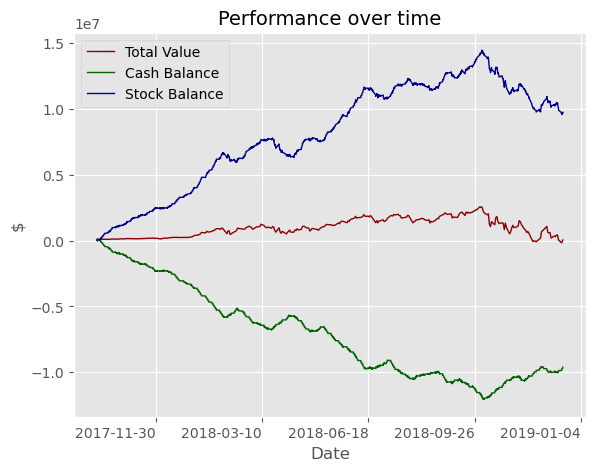

<Figure size 2000x1500 with 0 Axes>

In [176]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

plt.style.use('ggplot')

# Plot the data
plt.plot(data_df_port3['date'], data_df_port3['Total_value'], color='darkred', linewidth=1,label='Total Value')
plt.plot(data_df_port3['date'], data_df_port3['cash_balance'], color='darkgreen', linewidth=1,label='Cash Balance')
plt.plot(data_df_port3['date'], data_df_port3['portfolio'], color='darkblue', linewidth=1,label='Stock Balance')
# Add axis labels and title
plt.title('Performance over time', fontsize=14)
plt.ylabel('$', fontsize=12)
plt.xlabel('Date', fontsize=12)

# Format the x-axis labels
plt.xticks(rotation=0, ha='right')
plt.gca().xaxis.set_major_locator(MaxNLocator(6))
                                            
# Add gridlines and legend
plt.legend(loc='best', fontsize=10)

# Adjust plot margins and size
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.2)
plt.figure(figsize=(20, 15))

# Display the plot
plt.show()

In [177]:
data_df_port3

date    AAPL    ADBE     AMZN      BA    GOOG     JPM     MSFT  \
0    2017-10-06     0.0     0.0      0.0     0.0     0.0     0.0      0.0   
1    2017-10-06     0.0     0.0      0.0     0.0     0.0     0.0      0.0   
2    2017-10-06     0.0     0.0    100.0     0.0     0.0     0.0      0.0   
3    2017-10-06     0.0   100.0    100.0     0.0     0.0     0.0      0.0   
4    2017-10-06     0.0   100.0    100.0     0.0   100.0     0.0      0.0   
...         ...     ...     ...      ...     ...     ...     ...      ...   
3015 2018-12-18  5000.0  9700.0  12000.0  8800.0  4300.0  3600.0  12500.0   
3016 2018-12-18  5000.0  9700.0  12000.0  8800.0  4300.0  3600.0  12500.0   
3017 2018-12-18  5000.0  9600.0  12000.0  8800.0  4300.0  3600.0  12500.0   
3018 2018-12-18  5000.0  9600.0  12000.0  8800.0  4300.0  3600.0  12400.0   
3019 2018-12-18  5000.0  9600.0  12000.0  8800.0  4200.0  3600.0  12400.0   

        NFLX  TSLA  ...    BA_close  GOOG_close  JPM_close  MSFT_close  \
0        0.0  -100  ...  245.107254   48.944500  83.227837   71.034775   
1        0.0  -100  ...  245.107254   48.944500  83.227837   71.034775   
2        0.0  -100  ...  245.107254   48.944500  83.227837   71.034775   
3        0.0  -100  ...  245.107254   48.944500  83.227837   71.034775   
4        0.0  -100  ...  245.107254   48.944500  83.227837   71.034775   
...      ...   ...  ...         ...         ...        ...         ...   
3015  4400.0     0  ...  318.774872   51.435501  86.557632   99.356194   
3016  4400.0     0  ...  318.774872   51.435501  86.557632   99.356194   
3017  4400.0     0  ...  318.774872   51.435501  86.557632   99.356194   
3018  4400.0     0  ...  318.774872   51.435501  86.557632   99.356194   
3019  4400.0     0  ...  318.774872   51.435501  86.557632   99.356194   

      NFLX_close  TSLA_close  WMT_close     portfolio  cash_balance  \
0     198.020004   23.792000  71.426086 -2.379200e+03  1.023792e+05   
1     198.020004   23.792000  71.426086 -9.521809e+03  1.095218e+05   
2     198.020004   23.792000  71.426086 -4.573909e+03  1.045739e+05   
3     198.020004   23.792000  71.426086  1.053809e+04  8.946191e+04   
4     198.020004   23.792000  71.426086  1.543254e+04  8.456746e+04   
...          ...         ...        ...           ...           ...   
3015  270.940002   22.468666  84.746788  9.715626e+06 -9.666840e+06   
3016  270.940002   22.468666  84.746788  9.707151e+06 -9.658365e+06   
3017  270.940002   22.468666  84.746788  9.684533e+06 -9.635747e+06   
3018  270.940002   22.468666  84.746788  9.674598e+06 -9.625812e+06   
3019  270.940002   22.468666  84.746788  9.669454e+06 -9.620668e+06   

        Total_value  
0     100000.000000  
1     100000.000000  
2     100000.000000  
3     100000.000000  
4     100000.000000  
...             ...  
3015   48786.009979  
3016   48786.009979  
3017   48786.009979  
3018   48786.009979  
3019   48786.009979  

[3020 rows x 24 columns]